# Morning Glory Experiments in Publication
This Jupyter notebook can make examples used in publication https://doi.org/10.1093/insilicoplants/diaa001.

There are two parts:
1. Calibration of loading and unloading rates (on 7 meter plants)  
Code block \[1\] - \[9\], they have to be run consecutively
2. Validation of the carlibrated loading and unloading rates (on 2.5, 3.5, 9, 10, 14 meter plants)  
Change file name in \[1\] then run code block \[1\] - \[9\] for each plants  
then run code-blocks \[10\] - \[14\]  

In [1]:
# loading libraries 
import scipy.sparse.linalg as LA
from scipy import sparse
import matplotlib.pylab as plt
import os
import py_plantbox as pb
from rb_tools import *
import xylem_flux 
import timeit
import numpy as np
from scipy.integrate import odeint



name = "morning_glory_7m" # Simulate a 7 meter morning glory
# name = 'Anagallis_femina_Leitner_2010'
#name = "morning_glory_2.5m_d" # Simulate a 2.5 meter morning glory
#name = "morning_glory_3.5m_d" # Simulate a 3.5 meter morning glory
#name = "morning_glory_9m_d" # Simulate a 9 meter morning glory
#name = "morning_glory_10m_d" # Simulate a 10 meter morning glory
#name = "morning_glory_14m_d" #Simulate a 14 meter morning glory


plant = pb.Plant()
plant.openXML(name)
plant.initialize()
plant.simulate(360)

plant.write("../results/{}.vtp".format(name),15)

# Convert the connected nodes in CPlantBox to PiafMunch arbitary numbers.
nodes = vv2a(plant.getNodes())/100 # convert from cm to m 
rseg = seg2a(plant.getSegments(15)) # root system segments
sseg = seg2a(plant.getSegments(4)) # strm system segments
lseg = v2ai(plant.getNodesOrganType())
plant_ana = pb.SegmentAnalyser(plant) 
nodes = vv2a(plant.getNodes())/100 # convert from cm to m 
node_connection_o = seg2a(plant.getSegments(15)) # plant segments
#sseg = seg2a(plant.getSegments(4)) #
node_organtype = v2ai(plant.getNodesOrganType())
nodes_with_organtype = np.column_stack([node_connection_o, node_organtype]) #make the node has organtype, to know the source sink relation
node_connection1, node_connection2 = np.split(node_connection_o.T,2)
node_connection1 = np.row_stack([node_connection1, node_organtype])
node_connection2 = np.row_stack([node_connection2, node_organtype])
nodes_organtype = np.column_stack([node_connection1,node_connection2])
_, indices = np.unique(nodes_organtype.T[:,0], return_index=True)
nodes_organtype = nodes_organtype.T[indices,:]
nodes_cor = np.column_stack([nodes_organtype, nodes])
node_connection = np.copy(node_connection_o)
unq, unq_idx, unq_cnt = np.unique(node_connection, return_inverse=True, return_counts=True)# check if all the connections are unique
nodes_organtype = np.column_stack((nodes_organtype,unq_cnt ))
nodes_organtype.astype(np.int_)
node_connection.astype(np.int_)
nodes_cor = np.column_stack([nodes_organtype, nodes])
stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 8)|(nodes_organtype[:,1]== 4)][:,0]
index_stem= list(range(1, len(stem_nodes)+1))
for i in range(len(stem_nodes)):
    index_stem[i] = np.where( node_connection[:,1] == stem_nodes[i])

for i in range(len(index_stem)-1):
    node_connection[index_stem[i+1][0][0]]=node_connection[index_stem[i+1][0][0]][::-1]


In [2]:
import rpy2.rinterface #include R interface, so we could directly use R code in jupyter notebook
#! sudo apt-get install r-base rpy2 pandas
#if package not found, then use commandline to "pip3 install rpy2"
import rpy2.robjects as rr
%load_ext rpy2.ipython



In [3]:
%%R 
k <- 1.118e-12 # conductivity (m2)
n <- 1.7e-9 / 3600 # viscosity (MPa.h)
s <- (12.880e-6)^2*pi # surface (m2)
l <- 5e-2 # length (m)

K1 <- (k/n)*(s/l) *10^6

K_1 <- (1 / K1)
print(K_1)

# 1 meter inner phloem resistance

k <- 0.693e-12 # conductivity (m2)
n <- 1.7e-9 / 3600 # viscosity (MPa.h)
s <- (14.6e-6)^2*pi # surface (m2)
l <- 5e-2 # length (m)

K1 <- (k/n)*(s/l) *10^6

K_4 <- (1 / K1)
print(K_4)
# 4 meter inner phloem resistance

k <- 0.879e-12 # conductivity (m2)
n <- 1.7e-9 / 3600 # viscosity (MPa.h)
s <- (9.83e-6)^2*pi # surface (m2)
l <- 5e-2 # length (m)

K1 <- (k/n)*(s/l) *10^6

K_7 <- (1 / K1)
print(K_7)

#7 meter inner phloem resistance

k <- 1.795e-12 # conductivity (m^2)
n <- 1.7e-9 / 3600 # viscosity (MPa.h)
s <- (13.830e-6)^2*pi # surface (m^2)
l <- 5e-2 # length (m)

K1 <- (k/n)*(s/l) *10^6 

K_1_i <- (1 / K1)
print(K_1_i)
 
k <- 0.98712e-12 # conductivity (m^2)
n <- 1.7e-9 / 3600 # viscosity (MPa.h)
s <- (19.710e-6)^2*pi # surface (m^2)
l <- 5e-2 # length (m)

K1 <- (k/n)*(s/l) *10^6

K_4_i <- (1 / K1)
print(K_4_i)
 
k <- 0.3532e-12 # conductivity (m^2)
n <- 1.7e-9 / 3600 # viscosity (MPa.h)
s <- (10.670e-6)^2*pi # surface (m^2)
l <- 5e-2 # length (m)

K1 <- (k/n)*(s/l) *10^6

K_7_i <- (1 / K1)
print(K_7_i)

R_name = c(1,4,7)
R_ex_number = c(K_1,K_4,K_7)
R_in_number = c(K_1_i,K_4_i,K_7_i)
R_in_number[2]






[1] 40.5222
[1] 50.87772
[1] 88.4852
[1] 21.8906
[1] 19.59852
[1] 186.9033
[1] 19.59852


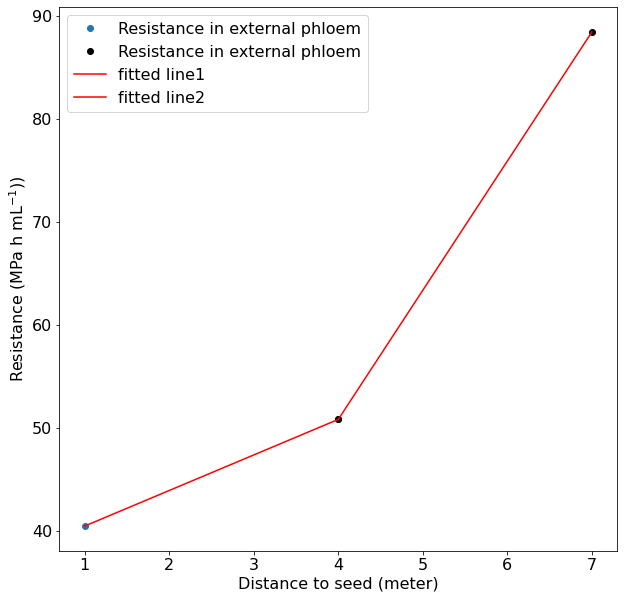

[[  2   2   3]
 [ 15   2   3]
 [ 28   2   3]
 [ 68   4   3]
 [ 80   4   3]
 [ 92   4   3]
 [104   4   3]
 [116   4   3]
 [128   4   3]
 [140   4   3]
 [152   4   3]
 [164   4   3]
 [176   4   3]
 [188   4   3]
 [200   4   3]]
[]
[]


In [8]:
# Write input file for PiafMunch
# Here we created several functions we used later
import pandas as pd
R_name = rr.r['R_name'] #get R object and 
R_in_number = rr.r['R_in_number'] 
R_ex_number = rr.r['R_ex_number']
R_in_number
R_ex_number[0:3]
#Adding deviation error bar later
plt.rcParams['figure.figsize'] = [10, 10]
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(R_name[0:2], R_ex_number[0:2])
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(R_name[1:3], R_ex_number[1:3])
plt.plot(R_name[0:2], R_ex_number[0:2], 'o', label='Resistance in external phloem')
plt.plot(R_name[1:3], R_ex_number[1:3], 'o', label='Resistance in external phloem', c='black' )
plt.plot(R_name[0:2], intercept + slope*R_name[0:2], 'r', label='fitted line1')
plt.plot(R_name[1:3], intercept2 + slope2*R_name[1:3], 'r', label='fitted line2')
plt.xlabel("Distance to seed (meter)")
plt.ylabel("Resistance (MPa h mL$^{-1}$))")
plt.legend()
plt.show()


stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 4)][:,0] 
root_nodes = nodes_organtype[(nodes_organtype[:,1]== 2)][:,0] 
leaf_nodes = nodes_organtype[(nodes_organtype[:,1]== 8)][:,0] 

def organ_marker(int):
    if int in leaf_nodes:
    #if int == 21: #int is source 
        return 'o'
    elif int in root_nodes : #int is sink
        return 'x'
    #elif int == 40 :
    elif int in stem_nodes:
        return '*'
    else:
        return 'None'
node_connection
#node_connection_cor
nodes_c_cor = np.full((len(node_connection), 3),0.0)
#charar = np.chararray((3, 3))
nodes_org = np.full((len(node_connection), 1),0)
for i in range(0,len(node_connection)):
    nodes_org[i]= nodes_organtype[node_connection[i][0]][1]
nodes_c_marker = np.full((len(node_connection), 1),'k')
for i in range(0,len(node_connection)):
    nodes_c_marker[i]= organ_marker(node_connection[i][0])
nodes_c_marker[0][0]= 'D'
nodes_c_marker.astype(str, copy = True)


for i in range(0,len(node_connection)):
    nodes_c_cor[i] = (nodes[node_connection[i,0]] + nodes[node_connection[i,1]])/2


    
    
b = np.zeros((nodes_organtype.shape[0],nodes_organtype.shape[1]+1)); b[:,:-1] = nodes_organtype
node_c_o = np.zeros((node_connection.shape[0],node_connection.shape[1]+5)); node_c_o[:,:-5] = node_connection

for i in range(0,len(node_connection)):
    node_c_o[i][2:5] = (nodes[node_connection[i,0]] + nodes[node_connection[i,1]])/2
#    node_c_o[i][6] = nodes_organtype[node_c_o[i][0]][0]
    #node_c_o[i][6] = nodes_organtype[node_c_o[i][0]][1]

    


r_st_all = np.full((len(node_connection), 1),0.0)
for i in range(0,len(node_connection)):
    r_st_all[i]= intercept + slope*node_c_o[i,4]


    
node_c_o_pd = pd.DataFrame({'1st_node':node_connection[:,0],'2nd_node':node_connection[:,1],'x':node_c_o[:,2]
                        ,'y':node_c_o[:,3],'z':node_c_o[:,4], 'organ_type':nodes_org[:,0],'marker':nodes_c_marker[:,0], 'r_st':r_st_all[:,0]})
#claculate the length from seed of every nodes (root is minus)
nodes_length = np.zeros(len(nodes_cor))
for i in range(2,len(nodes_cor)):
    if nodes_cor[i][1]==2: #if the organtype is root
        nodes_length[i] = nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] - ((nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 + (nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 + (nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) 
    else:
        nodes_length[i] = nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] + ((nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 + (nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 + (nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_cor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) 

        
        
#     print(nodes_length[i])
#     print(i)
    #print(node_connection[i])
    #the length of the first node of connection i in node_connection
    #node_c_o[i][6] = nodes_organtype[node_c_o[i][0]][0]
    #node_c_o[i][6] = nodes_organtype[node_c_o[i][0]][1]

    #manual check the length of all nodes.
nodes_cor[node_connection[(node_connection[:,1] == 3)][0][0]][2]
#len(nodes_length)
#print(len(nodes_length))
nodes_length
#node_connection_o[0,0]=1
np.c_[ nodes_organtype, nodes_length]


len(nodes_organtype)
#node_connection
len(nodes_cor)
nodes_cor[:,4]
nodes_r_st = np.zeros(len(nodes_cor))
for i in range(0,len(nodes_cor)):
    if nodes_length[i] > R_name[1]:
        nodes_r_st[i]= (intercept2 + slope2*nodes_length[i])
    else:
        nodes_r_st[i]= (intercept + slope*nodes_length[i])
nodes_r_st


#R_st is calculated based on the height (or the z axis value), 

#calcuate the volumn of st


# file-output.py



Nt = len(nodes)-1
Nc = len(node_connection)

#condition = ==0
#print(nodes_organtype[:,0])
nodes_organtype[1,2] =2
nodes_organtype[1,1] =1
node_connection[0,0] =1

N1L_node = nodes_organtype[(nodes_organtype[:,0] >2 ) & ((nodes_organtype[:,1] ==8)|(nodes_organtype[:,1] ==4)  ) & (nodes_organtype[:,2] ==1 )]

N1L_c_nd = list(range(1, len(N1L_node)+1))
N1L_conn = list(range(1, len(N1L_node)+1))
for i in range(len(N1L_node)):
    N1L_c_nd[i] = node_connection[(node_connection[:,0] == N1L_node[i][0])]
    N1L_conn[i] = np.where( node_connection[:,1] == N1L_c_nd[i][0,1])[0]


N1R_node = nodes_organtype[(nodes_organtype[:,0] >2 ) & (nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )]
N1R_c_nd = list(range(1, len(N1R_node)+1))
N1R_conn = list(range(1, len(N1R_node)+1))
for i in range(len(N1R_node)):
    N1R_c_nd[i] = node_connection[(node_connection[:,1] == N1R_node[i][0])]
    N1R_conn[i] = np.where( node_connection[:,1] == N1R_c_nd[i][0,1])[0]
N1R_r_abs = 1e-025

N2_node = nodes_organtype[ (nodes_organtype[:,2] ==2 )]

# #print(N2_node)
# N2_c_nd_1 = list(range(1, len(N2_node)+1))
# N2_conn_1 = list(range(1, len(N2_node)+1))
# for i in range(len(N2_node)):
#     if N2_node[i,1] == 2 or N2_node[i,1] == 1:
#         N2_c_nd_1[i] = node_connection[(node_connection[:,0] == N2_node[i,0])]
#         N2_conn_1[i] = np.where( node_connection[:,0] == N2_c_nd_1[i][0,0])[0]
#     else:
#         N2_c_nd_1[i] = node_connection[(node_connection[:,0] == N2_node[i,0])]
#         N2_conn_1[i] = np.where( node_connection[:,0] == N2_c_nd_1[i][0,0])[0]

# #temp= N2_c_nd_1[0]
# #temp=temp[::-1] 
# #print(temp )
# N2_c_nd_2 = list(range(1, len(N2_node)+1))
# N2_conn_2 = list(range(1, len(N2_node)+1))

# for i in range(len(N2_node)):
#     if N2_node[i,1] == 2 or N2_node[i,1] == 1:
#         N2_c_nd_2[i] = node_connection[(node_connection[:,1] == N2_node[i,0])]
#     else:
#         N2_c_nd_2[i] = node_connection[(node_connection[:,1] == N2_node[i,0])]
# #N2_c_nd_2[0] = np.array([temp]) 
# #print(N2_c_nd_2)
# for i in range(len(N2_node)):
#     N2_conn_2[i] = np.where( node_connection[:,1] == N2_c_nd_2[i][0][0])[0]

# N2_conn_2[0]=[0-(np.where( node_connection[:,0] == 1))[0][1]-2]


################## Nodes With 2 Connections #########################
N2_c_nd_1 = list(range(1, len(N2_node)+1))
N2_conn_1 = list(range(1, len(N2_node)+1))
for i in range(len(N2_node)):
    N2_c_nd_1[i] = node_connection[(node_connection[:,0] == N2_node[i,0])]
    N2_conn_1[i] = np.where( node_connection[:,0] == N2_c_nd_1[i][0,0])[0]


#temp= N2_c_nd_1[0]
#temp=temp[::-1] 
#print(temp )

N2_c_nd_2 = list(range(1, len(N2_node)+1))
N2_conn_2 = list(range(1, len(N2_node)+1))

for i in range(len(N2_node)):
    N2_c_nd_2[i] = node_connection[(node_connection[:,1] == N2_node[i,0])]
    N2_conn_2[i] = np.where( node_connection[:,1] == N2_c_nd_2[i][0][1])[0]

    

################## Nodes With 3 Connections #########################
N3_node = nodes_organtype[ (nodes_organtype[:,2] ==3 )]
print(N3_node)

N3_c_nd_1 = list(range(1, len(N3_node)+1))
N3_conn_1 = list(range(1, len(N3_node)+1))
for i in range(len(N3_node)):
    if N3_node[i,1] == 2 or N2_node[i,1] == 1:
        N3_c_nd_1[i] = node_connection[(node_connection[:,1] == N3_node[i,0])][0][0]
        N3_conn_1[i] = 0-np.where( node_connection[:,0] == N3_c_nd_1[i])[0][0]-1
    else:
        N3_c_nd_1[i] = node_connection[(node_connection[:,0] == N3_node[i,0])][0][1]
        N3_conn_1[i] = np.where( node_connection[:,1] == N3_c_nd_1[i])[0][0]+1

N3_c_nd_2 = list(range(1, len(N3_node)+1))
N3_conn_2 = list(range(1, len(N3_node)+1))
for i in range(len(N3_node)):
    if N3_node[i,1] == 2 or N2_node[i,1] == 1:
        N3_c_nd_2[i] = node_connection[(node_connection[:,0] == N3_node[i,0])][0][1]
        N3_conn_2[i] = np.where( node_connection[:,1] == N3_c_nd_2[i])[0][0]+1
    else:
        N3_c_nd_2[i] = node_connection[(node_connection[:,1] == N3_node[i,0])][0][0]
        N3_conn_2[i] = 0-np.where( node_connection[:,0] == N3_c_nd_2[i])[0][0]-1

N3_c_nd_3 = list(range(1, len(N3_node)+1))
N3_conn_3 = list(range(1, len(N3_node)+1))
for i in range(len(N3_node)):
    if N3_node[i,1] == 2 or N2_node[i,1] == 1:
        N3_c_nd_3[i] = node_connection[(node_connection[:,0] == N3_node[i,0])][1][1]
        N3_conn_3[i] = np.where( node_connection[:,1] == N3_c_nd_3[i])[0][0]+1
    else:
        N3_c_nd_3[i] = node_connection[(node_connection[:,1] == N3_node[i,0])][1][0]
        N3_conn_3[i] = 0-np.where( node_connection[:,0] == N3_c_nd_3[i])[0][0]-1
# for i in range(len(N3_node)):
#     print(N3_c_nd_3[i][1,1])
#for i in range(len(N3_node)):
#    print(N3_conn_3[i][0]+1)
# N3_node = nodes_organtype[ (nodes_organtype[:,2] ==3 )]
# #print(N3_node)

# N3_c_nd_1 = list(range(1, len(N3_node)+1))
# N3_conn_1 = list(range(1, len(N3_node)+1))
# for i in range(len(N3_node)):
#     N3_c_nd_1[i] = node_connection[(node_connection[:,1] == N3_node[i,0])]
#     N3_conn_1[i] = np.where( node_connection[:,0] == N3_c_nd_1[i][0,0])[0]

# #print(len(N3_c_nd_1))
# #print(len(N3_conn_1))
# #for i in range(len(N3_node)):
# #    print(N3_c_nd_1[i][0,0])
# #for i in range(len(N3_node)):
# #    print(N3_conn_1[i][0]+1)
    
    
# N3_c_nd_2 = list(range(1, len(N3_node)+1))
# N3_conn_2 = list(range(1, len(N3_node)+1))
# for i in range(len(N3_node)):
#     N3_c_nd_2[i] = node_connection[(node_connection[:,0] == N3_node[i,0])]
#     N3_conn_2[i] = np.where( node_connection[:,1] == N3_c_nd_2[i][0,1])[0]

# #print(len(N3_c_nd_2))
# #print(len(N3_conn_2))
# #for i in range(len(N3_node)):
# #    print(N3_c_nd_2[i][0,1])
# #for i in range(len(N3_node)):
# #    print(N3_conn_2[i][0]+1)
    
# N3_c_nd_3 = list(range(1, len(N3_node)+1))
# N3_conn_3 = list(range(1, len(N3_node)+1))
# for i in range(len(N3_node)):
#     N3_c_nd_3[i] = node_connection[(node_connection[:,0] == N3_node[i,0])]
#     N3_conn_3[i] = np.where( node_connection[:,1] == N3_c_nd_3[i][1,1])[0]

# #print(N3_c_nd_3)
# #print(len(N3_conn_3))
# #for i in range(len(N3_node)):
# #    print(N3_c_nd_3[i][1,1])
# #for i in range(len(N3_node)):
# #    print(N3_conn_3[i][0]+1)

N4_node = nodes_organtype[ (nodes_organtype[:,2] ==4 )]
#print(N4_node)

N4_c_nd_1 = list(range(1, len(N4_node)+1))
N4_conn_1 = list(range(1, len(N4_node)+1))
for i in range(len(N4_node)):
    N4_c_nd_1[i] = node_connection[(node_connection[:,0] == N4_node[i,0])][0][1]
    N4_conn_1[i] = np.where( node_connection[:,1] == N4_c_nd_1[i])[0][0]+1

print(N4_c_nd_1)
print(N4_conn_1)
#for i in range(len(N4_node)):
#    print(N4_c_nd_1[i])
#for i in range(len(N4_node)):
#    print(N4_conn_1[i][0]+1)
    
    
N4_c_nd_2 = list(range(1, len(N4_node)+1))
N4_conn_2 = list(range(1, len(N4_node)+1))
N4_conn_3 = list(range(1, len(N4_node)+1))
N4_conn_4 = list(range(1, len(N4_node)+1))
for i in range(len(N4_node)):
    N4_c_nd_2[i] = node_connection[(node_connection[:,1] == N4_node[i,0])]
    N4_conn_2[i] = np.where( node_connection[:,0] == N4_c_nd_2[i][0][0])[0]
    N4_conn_3[i] = np.where( node_connection[:,0] == N4_c_nd_2[i][1][0])[0]
    N4_conn_4[i] = np.where( node_connection[:,0] == N4_c_nd_2[i][2][0])[0]

# print(N4_c_nd_2[0][0][1])
# print(N4_c_nd_2[0][1][1])    
# print(N4_c_nd_2[0][2][1]) 

# print(N4_c_nd_2[0][0][0])
# print(N4_c_nd_2) 
# print(N4_conn_2) 
# print(N4_conn_3) 
# print(N4_conn_4) 










#'******** CARBON Lateral FLUX - RELATED PARAMETERS *********\n'
#initialization of the parameters
kML = np.zeros(len(nodes_organtype))
vML = np.zeros(len(nodes_organtype))
kMU = np.zeros(len(nodes_organtype))
vMU = np.zeros(len(nodes_organtype))
kMParMb = np.zeros(len(nodes_organtype))
vMParMb = np.zeros(len(nodes_organtype))
kM = np.zeros(len(nodes_organtype)) #kinetic parameter / Michaelis - starch Synthesis
Vmax = np.zeros(len(nodes_organtype)) # kinetic parameter / starch Synthesis
C_targ = np.zeros(len(nodes_organtype)) #kinetic parameter / starch/sugar equilibrium. (regul. par. sugar conc.) 			(mmol / ml)
kHyd = np.zeros(len(nodes_organtype))
k1 = np.zeros(len(nodes_organtype))
k2 = np.zeros(len(nodes_organtype))
k3 = np.zeros(len(nodes_organtype))
StructC = np.zeros(len(nodes_organtype))
vol_ST = np.zeros(len(nodes_organtype))
volPhlApo = np.zeros(len(nodes_organtype))
volParApo = np.zeros(len(nodes_organtype))
k_Lockhart = np.zeros(len(nodes_organtype))
P_thr = np.zeros(len(nodes_organtype))
vol_Sympl_max = np.zeros(len(nodes_organtype))

r_Xyl = np.full(len(nodes_organtype), 0.0005)
r_ST = np.full(len(nodes_organtype), nodes_r_st)       #automatically assign the sieve tube resistance calculated based on 
r_Trsv = np.full(len(nodes_organtype), 100)
r_PhlMb = np.full(len(nodes_organtype), 135.785)
r_ParMb = np.full(len(nodes_organtype), 1e+025)
r_Apo = np.full(len(nodes_organtype), 1e+025)
r_Sympl = np.full(len(nodes_organtype), 1e+025)




for i in range(len(nodes_organtype)): #given different value based on whether it is source, sink or connection
    if (nodes_organtype[i,1] == 8 or nodes_organtype[i,1] == 4) and nodes_organtype[i,2] == 1: #all the sources       
        kML[i]     =  1e-100
        vML[i]        = 0.000143136      #kinetic parameter / phloem loading (mmol /h) different in source, sink or connection of piafmunch2 oringinal value is 0.000143136 
        kMU[i]        = 10e-100     #different in source, sink or connection of piafmunch2
        vMU[i]        = 0      #different in source, sink or connection of piafmunch2
        kMParMb[i]    = 1
        vMParMb[i]    = 0
        kM[i]         = 1e-100
        Vmax[i]       = 0
        C_targ[i]     = 0.17      #different in source, sink or connection of piafmunch2
        kHyd[i]       = 0
        k1[i]         = 0
        k2[i]         = 0     #
        k3[i]         = 0
        StructC[i]    = 0      #different in source, sink or connection of piafmunch2
        vol_ST[i]     = 2.6e-05
        volPhlApo[i]  = 2.6e-05
        volParApo[i]  = 2.6e-05
        k_Lockhart[i] = 0
        P_thr[i]      = 1
        vol_Sympl_max[i] = 0.00018
    elif nodes_organtype[i,0]>0 and nodes_organtype[i,1]==2 and nodes_organtype[i,2]==1:   #all the sinks  
        kML[i]     =  1e-100
        vML[i]        = 0      #different in source, sink or connection of piafmunch2
        kMU[i]        =   1e+99      #different in source, sink or connection of piafmunch2 default 1e+99
        vMU[i]        = 2.82627e+95      #different in source, sink or connection of piafmunch2 default is 2.82627e+95
        kMParMb[i]    = 1
        vMParMb[i]    = 0
        kM[i]         = 1e-100
        Vmax[i]       = 0
        C_targ[i]     =     0.1     #different in source, sink or connection of piafmunch2
        kHyd[i]       = 0
        k1[i]         = 0
        k2[i]         = 0     #manually set it to 0.4
        k3[i]         = 0
        StructC[i]    = 1      #different in source, sink or connection of piafmunch2
        vol_ST[i]     = 2.6e-05
        volPhlApo[i]  = 2.6e-05
        volParApo[i]  = 2.6e-05
        k_Lockhart[i] = 0
        P_thr[i]      = 1
        vol_Sympl_max[i] = 0.00018        
    elif nodes_organtype[i,2]!=1: #all other connections other than source and sink
        kML[i]     =  1e-100
        vML[i]        = 0      #different in source, sink or connection of piafmunch2
        kMU[i]        = 1e-100      #different in source, sink or connection of piafmunch2
        vMU[i]        = 0      #different in source, sink or connection of piafmunch2
        kMParMb[i]    = 1
        vMParMb[i]    = 0
        kM[i]         = 1e-100
        Vmax[i]       = 0
        C_targ[i]     = 0.1      #different in source, sink or connection of piafmunch2
        kHyd[i]       = 0
        k1[i]         = 0
        k2[i]         = 0
        k3[i]         = 0
        StructC[i]    = 1      #different in source, sink or connection of piafmunch2
        vol_ST[i]     = 2.6e-05 #ml
        volPhlApo[i]  = 2.6e-05
        volParApo[i]  = 2.6e-05
        k_Lockhart[i] = 0
        P_thr[i]      = 1
        vol_Sympl_max[i] = 0.00018



#'******** INITIAL VALUES *********\n'
#initialization of the parameters
Q_ST = np.full(len(nodes_organtype), 0)
Q_Sympl = np.full(len(nodes_organtype), 4.4e-006)
Starch = np.full(len(nodes_organtype), 1)
Q_PhlApo = np.full(len(nodes_organtype), 4.4e-006)
Q_ParApo = np.full(len(nodes_organtype), 4.4e-006)
Tr_Q_ST = np.full(len(nodes_organtype), 0)
Tr_Q_Sympl = np.full(len(nodes_organtype), 4.4e-006)
Tr_Starch = np.full(len(nodes_organtype), 1)
Tr_Q_PhlApo = np.full(len(nodes_organtype), 0)
Tr_Q_ParApo = np.full(len(nodes_organtype), 0)
vol_Sympl = np.full(len(nodes_organtype), 2.6e-005)

#******** SIMULATION SOLVING PARAMETERS *********


#'******** CARBON Lateral FLUX - RELATED PARAMETERS *********\n'
#initialization of the parameters

Q_ST_Abs = np.full(len(nodes_organtype), 2.6e-012)
Q_Sympl_Abs = np.full(len(nodes_organtype), 1e-007)
Starch_Abs = np.full(len(nodes_organtype), 1e-007)
Q_PhlApo_Abs = np.full(len(nodes_organtype), 2.6e-012)
Q_ParApo_Abs = np.full(len(nodes_organtype), 1e-007)
Tr_Q_ST_Abs = np.full(len(nodes_organtype), 2.6e-012)
Tr_Q_Sympl_Abs = np.full(len(nodes_organtype), 1e-007)
Tr_Starch_Abs = np.full(len(nodes_organtype), 1e-007)
Tr_Q_PhlApo_Abs = np.full(len(nodes_organtype), 2.6e-012)
Tr_Q_ParApo_Abs = np.full(len(nodes_organtype), 1e-007)
vol_Sympl_Abs = np.full(len(nodes_organtype), 2.6e-012)



for i in range(len(nodes_organtype)): #given different value based on whether it is source, sink or connection
    if (nodes_organtype[i,1] == 8 or nodes_organtype[i,1] == 4) and nodes_organtype[i,2] == 1: #all the sources       
        Q_ST_Abs[i] =  1e-015
        Q_Sympl_Abs[i] =  1e-015
        Starch_Abs[i] =  1e-012
        Q_PhlApo_Abs[i] =  1e-015
        Q_ParApo_Abs[i] =  1e-015
        Tr_Q_ST_Abs[i] =  1e-012
        Tr_Q_Sympl_Abs[i] =  1e-012
        Tr_Starch_Abs[i] =  1e-012
        Tr_Q_PhlApo_Abs[i] =  1e-015
        Tr_Q_ParApo_Abs[i] =  1e-015
        vol_Sympl_Abs[i] = 1e-012

# Creat small functions for assign different speed or k

def assign_source_loading_speed( value= 0.000143136):
    for i in range(len(nodes_organtype)): #given different value based on whether it is source, sink or connection
        if (nodes_organtype[i,1] == 8 or nodes_organtype[i,1] == 4) and nodes_organtype[i,2] == 1: #all the sources       
            vML[i]        = value      #kinetic parameter / phloem loading (mmol /h) different in source, sink or connection of piafmunch2 oringinal value is 0.000143136 
    return vML;

def assign_source_loading_k( value= 1e-100):
    for i in range(len(nodes_organtype)): #given different value based on whether it is source, sink or connection
        if (nodes_organtype[i,1] == 8 or nodes_organtype[i,1] == 4) and nodes_organtype[i,2] == 1: #all the sources       
            kML[i]        = value      #kinetic parameter /  phloem loading (mmol /h) different in source, sink or connection of piafmunch2 oringinal value is 0.000143136 
    return kML;


def assign_sink_unloading_speed( value= 2.82627e+95):
    for i in range(len(nodes_organtype)): #given different value based on whether it is source, sink or connection
        if nodes_organtype[i,0]>0 and nodes_organtype[i,1]==2 and nodes_organtype[i,2]==1:   #all the sinks        
            vMU[i]        = value      #kinetic parameter / phloem loading (mmol /h) different in source, sink or connection of piafmunch2 oringinal value is 0.000143136 
    return vMU;

def assign_sink_unloading_k( value= 1e+99):
    for i in range(len(nodes_organtype)): #given different value based on whether it is source, sink or connection
        if nodes_organtype[i,0]>0 and nodes_organtype[i,1]==2 and nodes_organtype[i,2]==1:   #all the sinks        
            kMU[i]        = value      #kinetic parameter / phloem loading (mmol /h) different in source, sink or connection of piafmunch2 oringinal value is 0.000143136 
    return kMU;

def assign_resistance( value):
    r_ST = np.full(len(nodes_organtype), value) 
    return r_ST;




def create_piafmunch_parameter( name= "mg_7m.ini" , end_time = "100"):
    f = open(name,'w')
    f.write('******** DESCRIPTION OF ARCHITECTURE *********\n\n')

    f.write("Total number of Nodes : {0} = {1}\n".format('Nt', Nt))
    f.write("number of Internode Connections : {0} = {1}\n\n".format('Nc', Nc))

    f.write("Nodes Of Connectivity Order 1, Transpiring Leaf Ends : {0} = {1}\n".format('N1L', len(N1L_node)))
    f.write("{:s}  {:s}  {:s}\n".format('node#','c.node','conn.#'))
    for i in range(len(N1L_node)):
        f.write("{:d}  {:d}  {:d}\n\n".format(N1L_node[i][0],N1L_c_nd[i][0,1],(N1L_conn[i][0]+1)))





    f.write("Nodes Of Connectivity Order 1, Absorbing Root Ends : {0} = {1}\n\n".format('N1R', len(N1R_node)))
    f.write("{:s}  {:s}  {:s}  {:s}\n".format('node#','c.node','conn.#','r_abs'))
    for i in range(len(N1R_node)):
        f.write("{:d}  {:d}  {:d} {:e}\n\n".format(N1R_node[i][0], N1R_c_nd[i][0,0],0- N1R_conn[i][0]-1, 1e-025))

    f.write('Nodes Of Connectivity Order 2 :  {0} = {1}\n\n' .format('N2', len(N2_node) ))
    f.write("{:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2'))
    for i in range(len(N2_node)):
        f.write("{:d}  {:d}  {:d} {:d} {:d} \n".format(N2_node[i][0],N2_c_nd_1[i][0,1],N2_conn_1[i][0]+1,N2_c_nd_2[i][0,0],0 -N2_conn_2[i][0]-1))    
    f.write('\n')

    f.write("Nodes Of Connectivity Order 3 :  {0} = {1}\n".format('N3', np.count_nonzero(unq_cnt == 3)))
    f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2','c.nd.3','conn.3'))
    for i in range(len(N3_node)):
        f.write("{:d}  {:d}  {:d} {:d} {:d} {:d} {:d}\n".format(N3_node[i][0],N3_c_nd_1[i],N3_conn_1[i],N3_c_nd_2[i],N3_conn_2[i],N3_c_nd_3[i],N3_conn_3[i]))    
    f.write('\n')




    f.write("Nodes Of Connectivity Order 4 :  {0} = {1}\n\n".format('N4', np.count_nonzero(unq_cnt == 4)))
    f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2','c.nd.3','conn.3','c.nd.4','conn.4'))

    for i in range(len(N4_node)):
        f.write("{:d}  {:d}  {:d} {:d} {:d} {:d} {:d} {:d} {:d}\n".format(N4_node[i][0],N4_c_nd_1[i],N4_conn_1[i],N4_c_nd_2[i][0][0],0-N4_conn_2[i][0]-1,N4_c_nd_2[i][1][0],0-N4_conn_3[i][0]-1,N4_c_nd_2[i][2][0],0-N4_conn_4[i][0]-1))    
    f.write('\n')



    f.write("Nodes Of Connectivity Order 5 :  {0} = {1}\n\n".format('N5', np.count_nonzero(unq_cnt == 5)))
    f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2','c.nd.3','conn.3','c.nd.4','conn.4','c.nd.5','conn.5'))
    f.write("Nodes Of Connectivity Order 6 :  {0} = {1}\n".format('N6', np.count_nonzero(unq_cnt == 6)))
    f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2','c.nd.3','conn.3','c.nd.4','conn.4','c.nd.5','conn.5','c.nd.6','conn.6'))
    f.write("Nodes Of Connectivity Order 7 :  {0} = {1}\n".format('N7', np.count_nonzero(unq_cnt == 7)))
    f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2','c.nd.3','conn.3','c.nd.4','conn.4','c.nd.5','conn.5','c.nd.6','conn.6','c.nd.7','conn.7'))
    f.write("Nodes Of Connectivity Order 8 :  {0} = {1}\n".format('N8', np.count_nonzero(unq_cnt == 8)))
    f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2','c.nd.3','conn.3','c.nd.4','conn.4','c.nd.5','conn.5','c.nd.6','conn.6','c.nd.7','conn.7','c.nd.8','conn.8'))

    f.write('******** WATER FLUX - RELATED PARAMETERS *********\n\n')
    f.write("{:s}  {:s}  {:s} \n".format('T\xb0 K','visco=f(C)','NonLin.Psi+NonZeroSugarVol.'))
    f.write("{:s}  {:s}  {:s} \n".format('293','true','true'))

    f.write('InterNode Connections -- Axial Resistances (MPa h / ml) : Nc= {}\n' .format(len(node_connection)))
    f.write("{:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','upfl.node','dnfl.node','r_Xyl','r_ST' ))
    for i in range(len(node_connection)):
        f.write("{:d}  {:d}  {:d} {:e} {:e}\n".format(i+1,node_connection[i,0],node_connection[i,1],r_Xyl[i],r_ST[i]))
    f.write('\n')

    f.write('Individual Node : Lateral Resistances (MPa h / ml)\n')
    f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','r_Trsv','r_PhlMb','r_ParMb','r_Apo', 'r_Sympl' ))
    for i in range(len(nodes_organtype)-1):
        f.write("{:d}  {:e}  {:e} {:e} {:e} {:e}\n".format(nodes_organtype[i+1][0],r_Trsv[i],r_PhlMb[i],r_ParMb[i],r_Apo[i],r_Sympl[i]))
    f.write('\n')


    f.write('******** CARBON Lateral FLUX - RELATED PARAMETERS *********\n')    
    f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s} \n".format('node#','kML(M)','vML(mmol/h)','kMU(M)','vMU(mmol/h)', 'kMParMb(M)','vMParMb(mmol/h)','kM(M)','Vmax(M/h)','C_targ(M)','kHyd(h-1)','k1(h-1)','k2','k3(h-1)','StructC','vol_ST(ml)','volPhlApo,ml','volParApo,ml','k_Lockhart','P_thr(MPa)','vol_Sympl_max,ml' ))    
    for i in range(len(nodes_organtype)-1):
        f.write("{:d}  {:e}  {:e} {:e} {:e} {:e}  {:e}  {:e} {:e} {:e} {:e}  {:e}  {:e} {:e} {:e} {:e}  {:e}  {:e} {:e} {:e} {:e}\n"
        .format(nodes_organtype[i+1][0],kML[i+1], vML[i+1], kMU[i+1], vMU[i+1], kMParMb[i+1], vMParMb[i+1], kM[i+1], Vmax[i+1], C_targ[i+1], kHyd[i+1], 
        k1[i+1], k2[i+1], k3[i+1], StructC[i+1], vol_ST[i+1], volPhlApo[i+1], volParApo[i+1], k_Lockhart[i+1], P_thr[i+1], vol_Sympl_max[i+1]))
    f.write('\n')



    f.write('******** INITIAL VALUES  *********\n')
    f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s} {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','Q.ST(mmol)','Q.Sympl(mmol)','Starch','Q.PhlApo(mmol)', 'Q.ParApo(mmol)',
                                                'Tr.Q.ST(mmol)','Tr.Q.Sympl(mmol)','Tr.Starch','Tr.Q.PhlApo(mmol)', 'Tr.Q.ParApo(mmol)','vol_Sympl(ml)' ))
    for i in range(len(nodes_organtype)-1):
        f.write("{:d}  {:e}  {:e} {:e} {:e} {:e}  {:e}  {:e} {:e} {:e} {:e} {:e}\n"
                .format(nodes_organtype[i+1][0], Q_ST[i+1],Q_Sympl[i+1],Starch[i+1],Q_PhlApo[i+1],Q_ParApo[i+1], 
                        Tr_Q_ST[i+1],Tr_Q_Sympl[i+1],Tr_Starch[i+1],Tr_Q_PhlApo[i+1],Tr_Q_ParApo[i+1],vol_Sympl[i+1]))
    f.write('\n')    

    f.write('******** SIMULATION SOLVING PARAMETERS *********\n')
    f.write('{:s}  {:s}  {:s}   {:s}  {:s}\n'.format('StartTime','EndTime','OutputStep', 'TracerHalfLife','Rel_Tol'))
    f.write('{:s}  {:s}  {:s}   {:s}  {:s}\n'.format('0', end_time, '0.166667', '0.33967', '1e-007'))
    f.write('\n')     

    f.write('***Abs_Tols for individual  nodes ***')
    f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s} {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','Q.ST(mmol)','Q.Sympl(mmol)','Starch','Q.PhlApo(mmol)', 'Q.ParApo(mmol)',
                                                'Tr.Q.ST(mmol)','Tr.Q.Sympl(mmol)','Tr.Starch','Tr.Q.PhlApo(mmol)', 'Tr.Q.ParApo(mmol)','vol_Sympl(ml)' ))
    for i in range(len(nodes_organtype)-1):
        f.write("{:d}  {:e}  {:e} {:e} {:e} {:e}  {:e}  {:e} {:e} {:e} {:e} {:e}\n"
                .format(nodes_organtype[i+1][0], Q_ST_Abs[i+1],Q_Sympl_Abs[i+1],Starch_Abs[i+1],Q_PhlApo_Abs[i+1],Q_ParApo_Abs[i+1], 
                        Tr_Q_ST_Abs[i+1],Tr_Q_Sympl_Abs[i+1],Tr_Starch_Abs[i+1],Tr_Q_PhlApo_Abs[i+1],Tr_Q_ParApo_Abs[i+1],vol_Sympl_Abs[i+1]))
    f.write('\n')     

    f.write('******** OUTPUT SETTINGS : INDIVIDUAL NODE - LATERAL FLUXES-RELATED VARIABLES *********\n')    
    f.write('Nodes selected for plotting  : nsp = {:d}\n' .format((len(nodes_organtype))-1 ))    
    for i in range(len(nodes_organtype)-1):
        f.write('{:d}\n'.format(nodes_organtype[i+1][0]))

    f.write('individual-Node-related variables selected for plotting : nvp = 1\n')    
    f.write('C_ST (mmol / ml)\n')        
    #f.write('JS_PhlMb (mmol / h)\n')        
    #f.write('JW_Trsv (ml / h)\n')        


    f.write('Nodes selected for saving  : nss = {:d}\n' .format((len(nodes_organtype))-1 ))    
    for i in range(len(nodes_organtype)-1):
        f.write('{:d}\n'.format(nodes_organtype[i+1][0]))
    f.write('\n')    


    f.write('individual-Node-related variables selected for saving : nvs = 30\n')    
    f.write('''
    C_ApoUpflow (mmol / ml)
    C_ParApo (mmol / ml)
    C_PhlApo (mmol / ml)
    C_ST (mmol / ml)
    C_Sympl (mmol / ml)
    C_SymplUpflow (mmol / ml)
    JS_Apo (mmol / h)
    JS_ParMb (mmol / h)
    JS_PhlMb (mmol / h)
    JS_Sympl (mmol / h)
    JW_Apo (ml / h)
    JW_ParMb (ml / h)
    JW_Sympl (ml / h)
    JW_Trsv (ml / h)
    P_PhlApo (MPa)
    P_ST (MPa)
    P_ST_dot (MPa / h)
    P_Sympl (MPa)
    P_Sympl_dot (MPa / h)
    P_Xyl (MPa)
    PsiSoil (MPa)
    Psi_ParApo (MPa)
    Psi_PhlApo (MPa)
    Psi_ST (MPa)
    Q_PhlApo (mmol)
    Q_PhlApo_dot (mmol / h)
    Q_Sympl_dot (mmol / h)
    Transpirat (ml / h)
    vol_Sympl (ml)
    vol_Sympl_dot (ml / h)
    StarchSyn (mmol eq. Glu / h)
    Starch (mmol eq. Glu)
    ''')

    f.write('******** OUTPUT SETTINGS : INTERNODE CONNECTION - AXIAL FLUXES-RELATED VARIABLES *********\n')  
    f.write('node-to-node Fluxes selected for plotting  : fsp = {} \n' .format(len(node_connection)))
    for i in range(len(node_connection)):
        f.write("{:d}\n".format((i+1)))
    f.write('\n')

    f.write('node-to-node-Fluxes-related variables selected for plotting : fvp = 1\n')    
    #f.write('JS_ST (mmol / h)\n')        
    f.write('JW_ST (ml / h)\n')        


    f.write('node-to-node Fluxes selected for saving  : fss = {} \n' .format(len(node_connection)))
    for i in range(len(node_connection)):
        f.write("{:d}\n".format((i+1)))
    f.write('\n')

    f.write('node-to-node-Fluxes-related variables selected for saving : fvs = 4\n')    
    f.write('JS_ST (mmol / h)\n')        
    f.write('JW_ST (ml / h)\n')  
    f.write('C_Upflow (mmol / ml)\n')
    f.write('JW_Xyl (ml / h)\n')  

    print('output successful'.format())




    f.close()
    return;

output successful


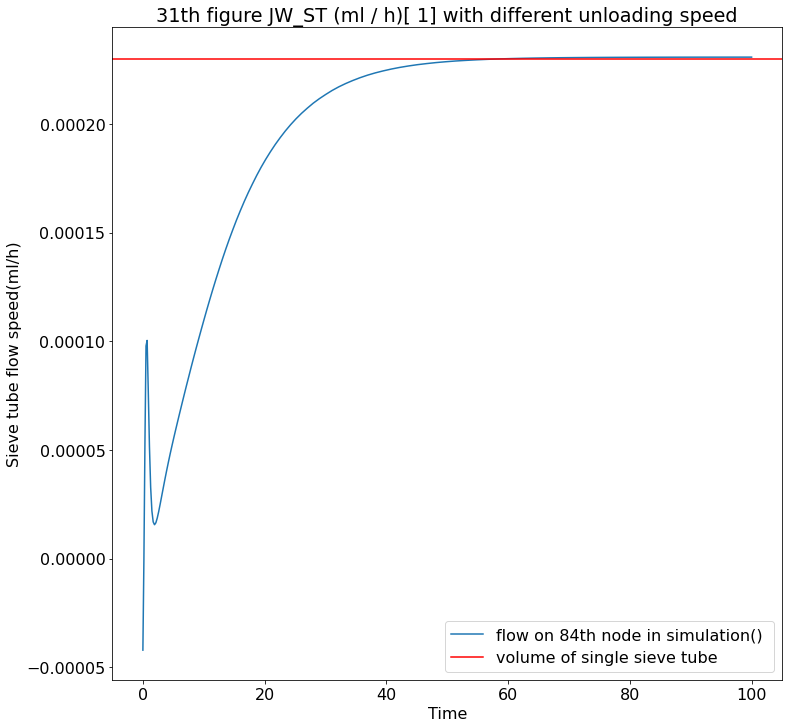

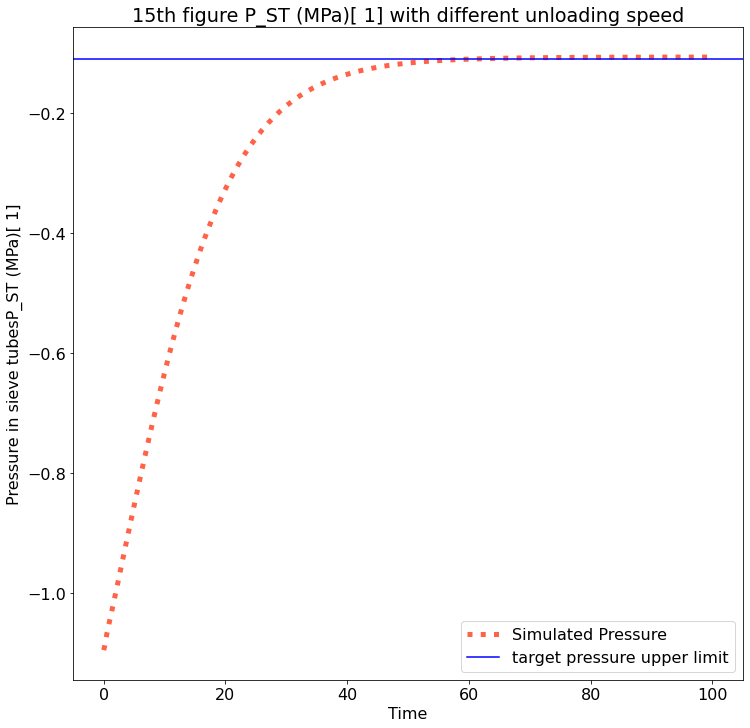

In [9]:
# for average pressure / real xylem pressure
import datetime

now = datetime.datetime.now()
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 12]
piaf_munch_p_name = 'realxylem{}connection_{}'.format(name, len(node_connection) )  #parameter name of piaf munch-- you name it


piaf_munch_path ='./'

vMU_x = np.zeros(10)
#need to lower the unloading speed and increase the loading speed. Because flow and pressure are both less 
vMU_x[0] =1.191855954263808e+97
vML_x = np.zeros(10)
vML_x[0] =6.4031395909090895e-06
kMU_x = np.zeros(10)
kMU_x[0] =  1e99 
kML_x = np.zeros(10)
kML_x[0] = 1e-100

for i in range(1,10):
    vMU_x[i] = vMU_x[i-1] 
    vML_x[i] = vML_x[i-1]  
    kMU_x[i] = kMU_x[i-1]
    kML_x[i] = kML_x[i-1] #* 2


rst_x = np.zeros(10)
rst_x[0] =1
for i in range(1,10):
    rst_x[i] = rst_x[i-1] 
rst_x   


# for i in range(len(vMU_x)):
for i in range(0,1):
    assign_sink_unloading_speed (vMU_x[i]) #2.82627e+95
    assign_source_loading_speed (vML_x[i])
    rst=(nodes_r_st/rst_x[i])
    r_ST = np.full(len(nodes_organtype), rst)  
    create_piafmunch_parameter( end_time = "100" )
    os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe mg_7m.ini -noGUI -q')
    os.system('mv /mnt/c/cpb1/tutorial/jupyter/mg_7m_{:04}-{:02}-{:02}*output.txt  ./{}{}_output.txt'.format( now.year,now.month, now.day, piaf_munch_p_name ,i) )


plt.rcParams['figure.figsize'] = [12, 12]
from scipy.stats import loglaplace,chi2
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)

    #print(output.iloc[2, n_begin:n_end])

    for i in range(31,32):

        n_begin = (len(node_connection+1))*i+31 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)
        
        plt.xlabel("Time")
        plt.ylabel("Sieve tube flow speed(ml/h)")
        plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[84:85] for pt in y],label = '{}() '.format("flow on 84th node in simulation"))#vMU_x[j]
#plt.axhline(y=0.23, color='r', linestyle='-', label='all the volume')
plt.axhline(y=0.00023, color='r', linestyle='-', label='volume of single sieve tube')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
    #f.savefig("{}.pdf".format(s), bbox_inches='tight')
    
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])

    for i in range(15,16): #NO. of the output (15,16) is pressure

        n_begin = (len(node_connection+1))*i+16 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)

        plt.xlabel("Time")
        plt.ylabel("Pressure in sieve tubes{}".format(output.columns[n_begin]))
        plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    
    sim_p = np.zeros(5)
    total_p= np.zeros(101)
    node_p_no = [70,94,118,166,178]
    i=0
    j=0
    for j in range(0,101):
        for i in range(0,5):
            sim_p[i] = [pt[node_p_no[i]:node_p_no[i]+1] for pt in y][j][0]
            total_p[j] = total_p[j] + sim_p[i]
    plt.plot(x,total_p/5,label = 'Simulated Pressure'.format(),ls=':' , linewidth=5,color='tomato')
    measuredp = -0.6+(1.11-0.59)
    measuredp
    #ax2.set_xlabel("Time")

plt.axhline(y=-0.6+(1.08-0.59), color='b', linestyle='-', label='target pressure upper limit')
# plt.axhline(y=-0.6+(2.5-0.59), color='b', linestyle='-', label='target pressure lower limit')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
#     f.savefig("{}.pdf".format(s), bbox_inches='tight')

In [11]:
def get_pressure_of_each_structure(name , node_no=93, time_point=81):
    for j in range(0,1):
        total_nodes = name[-3:]
        total_nodes_int= int(total_nodes)
        path = 'realxylem{}{}_output.txt'.format(name, j)
        output = pd.read_table(path,sep='\t',header=1)
        for i in range(15,16): #NO. of the output (15,16) is pressure
            
            n_begin = (total_nodes_int+1)*i +1# careful here is the number of connections but bot nodes
            values= output.iloc[time_point:time_point+1,n_begin+node_no:n_begin+node_no+1]
        return values;    
    return values;

#all_plant_p_name = ["morning_glory_2.5m_dconnection_184", "morning_glory_3.5m_dconnection_204", "morning_glory_9m_dconnection_313", "morning_glory_10m_dconnection_333", "morning_glory_14m_dconnection_403"]
all_plant_p_name = ["morning_glory_2.5m_dconnection_179", "morning_glory_3.5m_dconnection_204", "morning_glory_9m_dconnection_308", "morning_glory_10m_dconnection_328", "morning_glory_14m_dconnection_403"]

all_plant_time_point = [100, 100, 100, 100, 100]
all_plant_total_n= [184, 204, 313, 333, 403]
all_plant_length= [2.5, 3.5, 9, 10, 14]
all_plant_node= [92, 113, 222, 242, 322]
all_pressure = np.zeros(5)
all_p_up = [0.76, 0.81, 2.5, 1.7, 2.3]#upper limit of the pressure measured
all_p_up[:] = [x - 1.19 for x in all_p_up]

all_p_low = [0.76, 0.68, 1.3, 1.7, 2.25] #lower limit of the pressure measured
all_p_low[:] = [x - 1.19 for x in all_p_low]
for i in range(0,5):
    pressure_here = get_pressure_of_each_structure(name = all_plant_p_name[i] , node_no=all_plant_node[i], time_point=all_plant_time_point[i]).values[0][0]
    all_pressure[i]= pressure_here
print(all_pressure)


FileNotFoundError: [Errno 2] No such file or directory: 'realxylemmorning_glory_2.5m_dconnection_1790_output.txt'

In [88]:
all_plant_time_point = [100, 100, 100, 100, 100]
i=4
get_pressure_of_each_structure(name = all_plant_p_name[i] , node_no=all_plant_node[i], time_point=all_plant_time_point[i])


all_p_measure = np.zeros(5)
all_p_error = np.zeros(5)
all_p_measure[:] = [(all_p_up[i]+all_p_low[i])/2 for i in range(0,5)]
all_p_error[:] = [(all_p_up[i]-all_p_low[i])/2 for i in range(0,5)]

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead.
  


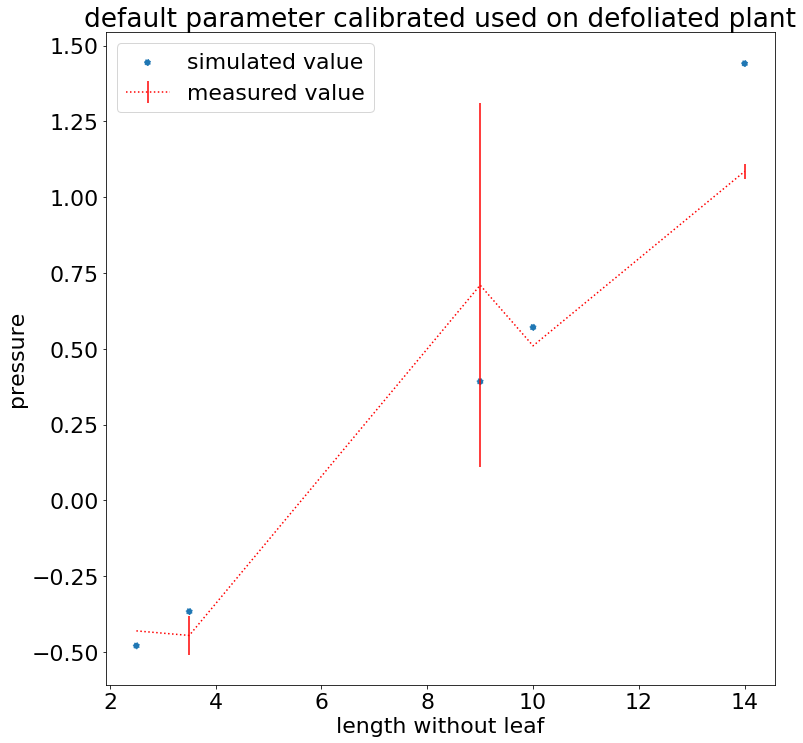

In [89]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = [12, 12]
pressure_fig = plt.figure(0)





x = all_plant_length
y = all_pressure
plt.scatter(x, y,  label= "simulated value" ,linestyle='dotted')
plt.title("default parameter calibrated used on defoliated plant")
#plt.errorbar(x,y, yuplims= all_p_up, ylolims= all_p_low, label= "measured value")
plt.errorbar(x, all_p_measure ,yerr=all_p_error, label= "measured value", c= "r",linestyle='dotted')
plt.xlabel("length without leaf")
plt.ylabel("pressure")
plt.legend()
plt.show()

In [115]:
all_pressure
all_p_measure

array([-0.43 , -0.445,  0.71 ,  0.51 ,  1.085])

r square = 0.9069677180621456
p value = 0.012397084284523097
std_err = 0.1562414822817455


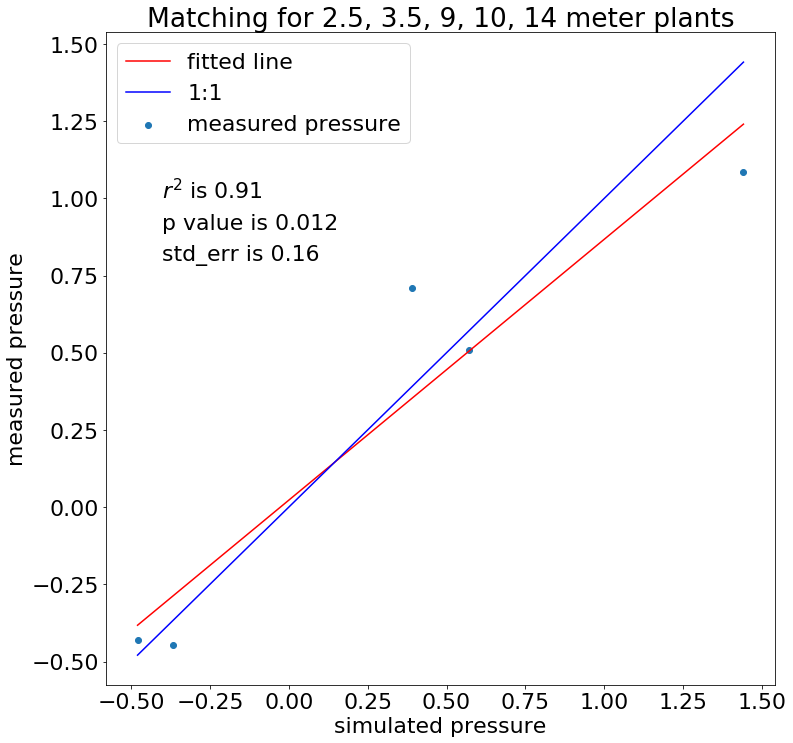

In [92]:
f = plt.figure(0)
plt.title("Matching for 2.5, 3.5, 9, 10, 14 meter plants")
plt.scatter(x=all_pressure, y= all_p_measure,  label = "measured pressure")
plt.xlabel("simulated pressure")
plt.ylabel("measured pressure")
slopeP, interceptP, r_valueP, p_valueP, std_errP = stats.linregress(all_pressure,all_p_measure)
#mg_x = np.asarray(mg_pressure_y, dtype=np.float32)
print("r square = {}".format(r_valueP**2))
print("p value = {}".format(p_valueP))
print("std_err = {}".format(std_errP))

plt.text( -0.4,1.0 , "$r^2$ is {:.02}".format(r_valueP**2), fontsize=22)
plt.text( -0.4,0.9 , "p value is {:.02}".format(p_valueP), fontsize=22)
plt.text( -0.4,0.8 , "std_err is {:.02}".format(std_errP), fontsize=22)
plt.plot(all_pressure, interceptP + slopeP*all_pressure, 'r', label='fitted line')
plt.plot(all_pressure, all_pressure, 'b', label='1:1')
plt.legend()
plt.show()
#mean square error

r$^2$ = 0.9069677180621456
p Value = 0.012397084284523097
SE = 0.19847968793608028


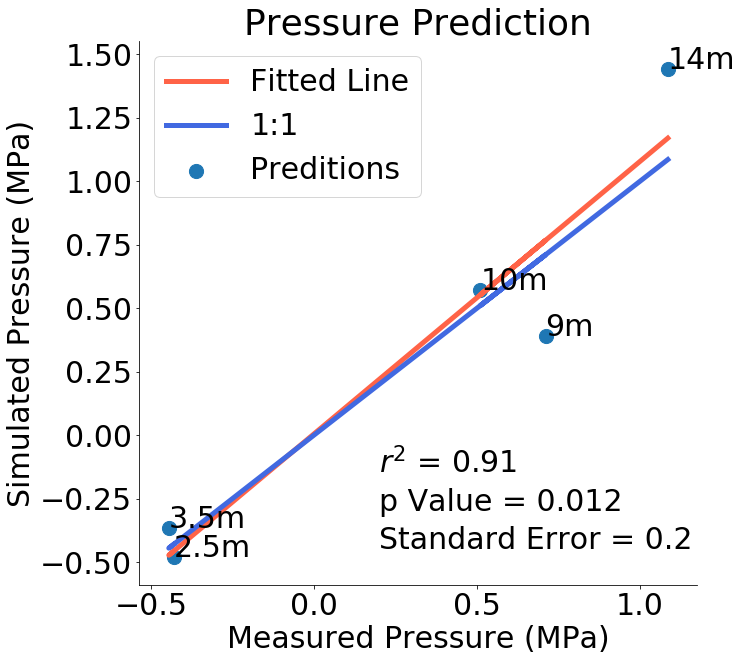

In [103]:
x = all_p_measure
y= all_pressure
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = [10, 10]
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Pressure Prediction")
ax.scatter(x=x, y= y,  label = "Preditions", s=200)
plt.xlabel("Measured Pressure (MPa)")
plt.ylabel("Simulated Pressure (MPa)")
slopeP, interceptP, r_valueP, p_valueP, std_errP = stats.linregress(x,y)
mg_x = np.asarray(x, dtype=np.float32)
print("r$^2$ = {}".format(r_valueP**2))
print("p Value = {}".format(p_valueP))
print("SE = {}".format(std_errP))

annotation_text=['2.5m','3.5m','9m','10m','14m']
for i, txt in enumerate(annotation_text):
    ax.annotate(txt, (x[i], y[i]))
plt.text( 0.2,-0.15 , "$r^2$ = {:.02}".format(r_valueP**2), fontsize=30)
plt.text( 0.2,-0.3 , "p Value = {:.02}".format(p_valueP), fontsize=30)
plt.text( 0.2,-0.45 , "Standard Error = {:.02}".format(std_errP), fontsize=30)
ax.plot(x, interceptP + slopeP*x, 'tomato', label='Fitted Line', linewidth =5,ls="-")
ax.plot(x, x, 'royalblue', label='1:1', linewidth =5)
plt.legend()
plt.show()

In [ ]:
x = mg_pressure_m_y
y= mg_pressure_y
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = [10, 10]
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.title("Equal Loading")
plt.title("Heterogeneous Loading Speed")
ax.scatter(x=x, y= y,  label = "measured pressure",s=200)
plt.xlabel("Measured Pressure (MPa)")
plt.ylabel("Simulated Pressure (MPa)")
slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(x,y)
mg_x = np.asarray(x, dtype=np.float32)
print("r square is {}".format(r_valueS**2))
print("p value is {}".format(p_valueS))
print("std_err is {}".format(std_errS))

plt.text( 0.25,0.56 , "$r^2$ = {:.02}".format(r_valueS**2), fontsize=30)
plt.text( 0.25,0.52 , "p value = {:.02}".format(p_valueS), fontsize=30)
plt.text( 0.25,0.48 , "SE = {:.02}".format(std_errS), fontsize=30)

ax.plot(mg_x, interceptS + slopeS*mg_x, 'tomato', label='fitted line', linewidth=5)
ax.plot(mg_x, mg_x, 'royalblue', label='1:1', linewidth=5)
#plt.legend(loc=(0.03,0.02)) #for hemogeneous loading speed
plt.legend(loc=(0.34,0.02)) #for hemetrogeneous loading speed
plt.show()
#mean square error

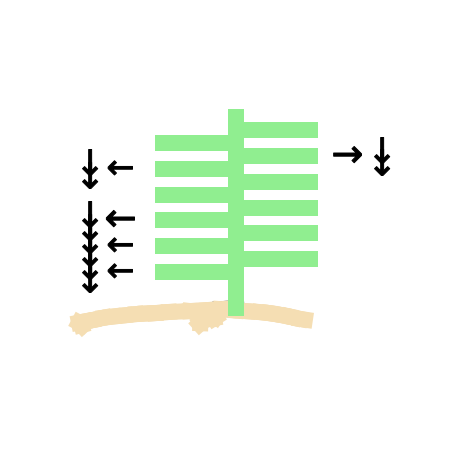

In [10]:
plt.rcParams['figure.figsize'] = [8, 22]

import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 4)][:,0] 
root_nodes = nodes_organtype[(nodes_organtype[:,1]== 2)][:,0] 
leaf_nodes = nodes_organtype[(nodes_organtype[:,1]== 8)][:,0] 
#(nodes_organtype[:,1]== 8)|
#print(stem_nodes)
def organ_color(int):
    if int in leaf_nodes: #int is source 
        return 'lightgreen'
    elif int in root_nodes: #int is sink
        return 'wheat'
    elif int in stem_nodes:
        return 'lightgreen'
    else:
        return 'black'
    

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.axis('off')
x =nodes[:,0]
y =nodes[:,1]
z =nodes[:,2]
# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
ax.grid(False)
# Bonus: To get rid of the grid as well:
#ax.grid(False)
#for i in range(len(nodes_cor)):
#    ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(nodes_cor[i,1]),
#            markersize=12, color='black')

c1= "k"
c2= "k"
for i in range(len(node_connection)):
    #xline = [x[node_connection[:,0][i]]],[x[node_connection[:,1][i]]] )
    #yline = np.array([y[node_connection[:,0][i]]],[y[node_connection[:,1][i]]] )
    #zline = np.array([z[node_connection[:,0][i]]],[z[node_connection[:,1][i]]] )
    organ= ax.plot3D(np.array([[x[node_connection[:,0][i]]][0],[x[node_connection[:,1][i]]][0]]), np.array([[y[node_connection[:,0][i]]][0],[y[node_connection[:,1][i]]][0]]), np.array([[z[node_connection[:,0][i]]][0],[z[node_connection[:,1][i]]][0]]), color=organ_color(node_connection[i,0]), linewidth=16)#ax.scatter([x[715]], [y[715]], [z[715]], c='r', s=99)
#ax.scatter([x[860]], [y[860]], [z[860]], c='g', s=99)
#ax.scatter([x[627]], [y[627]], [z[627]], c='g', s=99)
for i in range(len(nodes_cor)): #assign all the source to red large font size

    if i == 70:
        ax.plot([x[i]+0.106], [y[i]], [z[i]-0.25], marker="$\u2193$".format(i), #u2193 downward arrow
                markersize=26, color=c2)
    if i == 70:
        ax.plot([x[i]+0.106], [y[i]], [z[i]+0.25], marker="$\u2193$".format(i),
                markersize=26, color=c2)
    if i == 70:
        ax.plot([x[i]+0.06], [y[i]], [z[i]], marker="$\u2190$".format(i), #u2190 left arrow
                markersize=26, color=c1)
    if i == 94:
        ax.plot([x[i]+0.106], [y[i]], [z[i]-0.25], marker="$\u2193$".format(i),
                markersize=26, color=c2)
    if i == 94:
        ax.plot([x[i]+0.106], [y[i]], [z[i]+0.25], marker="$\u2193$".format(i), #u2191 upward arrow
                markersize=26, color=c2)
    if i == 94:
        ax.plot([x[i]+0.06], [y[i]], [z[i]], marker="$\u2190$".format(i),
                markersize=26, color=c1)
    if i == 118:
        ax.plot([x[i]+0.106], [y[i]], [z[i]-0.25], marker="$\u2193$".format(i),
                markersize=26, color=c2)
    if i == 118:
        ax.plot([x[i]+0.106], [y[i]], [z[i]+0.25], marker="$\u2193$".format(i),
                markersize=26, color=c2)
    if i == 118:
        ax.plot([x[i]+0.06], [y[i]], [z[i]], marker="$\u2190$".format(i),
                markersize=30
                , color=c1)
    if i == 166:
        ax.plot([x[i]+0.106], [y[i]], [z[i]-0.25], marker="$\u2193$".format(i),
                markersize=26, color=c2)
    if i == 166:
        ax.plot([x[i]+0.106], [y[i]], [z[i]+0.25], marker="$\u2193$".format(i),
                markersize=26, color=c2)
    if i == 166:
        ax.plot([x[i]+0.06], [y[i]], [z[i]], marker="$\u2190$".format(i), #u2192 right arrow
                markersize=26, color=c1)
    if i == 178:
        ax.plot([x[i]-0.093], [y[i]], [z[i]-0.25], marker="$\u2193$".format(i),
                markersize=26, color=c2)
    if i == 178:
        ax.plot([x[i]-0.093], [y[i]], [z[i]+0.25], marker="$\u2193$".format(i),
                markersize=26, color=c2)
    if i == 178:
        ax.plot([x[i]-0.05], [y[i]], [z[i]], marker="$\u2192$".format(i),
                markersize=30
                , color=c1)
    else:
        ax.plot([x[i]], [y[i]], [z[i]], marker=''.format(i),#mapping all the organ color green or yellow
                markersize=12, color=organ_color(i))

ax.dist = 5.0
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_ylim3d(2,0)
ax.set_zlim3d(-1,7.5)
ax.set_xlim3d(-0.2,0.2)
ax.view_init(0, 90)

root_patch = mpatches.Patch(color='wheat', label='root')
seed_patch = mpatches.Patch(color='black', label='seed')
stem_patch = mpatches.Patch(color='olive', label='stem')
leaf_patch = mpatches.Patch(color='lightgreen', label='leaf')
#plt.legend(handles=[root_patch, seed_patch,stem_patch,leaf_patch],bbox_to_anchor=(0.7, 0.7), loc=2, borderaxespad=0.)
plt.show()
fig.savefig("{}.png".format('organtype_structure'), bbox_inches='tight',dpi=300)

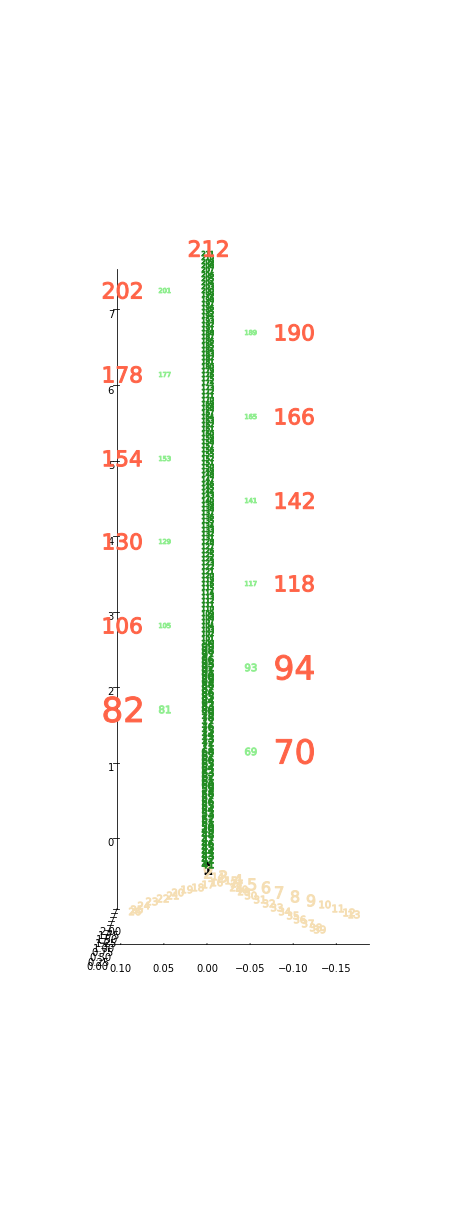

In [11]:
from mpl_toolkits.mplot3d import axes3d
def organ_color(int):
    if int in leaf_nodes: #int is source 
        return 'lightgreen'
    elif int in root_nodes: #int is sink
        return 'wheat'
    elif int in stem_nodes:
        return 'forestgreen'
    else:
        return 'black'
    
nodes_cor = np.column_stack([nodes_organtype, nodes])

plt.rcParams['figure.figsize'] = [8, 22]


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt





fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =nodes_cor[:,3]
y =nodes_cor[:,4]
z =nodes_cor[:,5]

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
ax.grid(False)

for i in range(len(nodes_cor)): #assign all the source to red large font size
    if (nodes_cor[i,1] == 8 or nodes_cor[i,1] == 4) and nodes_cor[i,2] == 1:
        ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(i),
                markersize=40, color='tomato')
    else:
        ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(i),#mapping all the organ color green or yellow
                markersize=12, color=organ_color(i))

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_ylim3d(2,0)
# ax.set_zlim3d(-1,7.5)
# ax.set_xlim3d(-0.2,0.2)
ax.view_init(0, 90)
plt.show()
fig.savefig("{}.png".format('3d with node number{}'.format(name)), bbox_inches='tight', dpi=300)

In [201]:
node_connection

array([[  1,   2],
       [  2,  14],
       [ 14,  15],
       [ 15,  27],
       [ 27,  28],
       [ 28,  40],
       [  2,   3],
       [  3,   4],
       [  4,   5],
       [  5,   6],
       [  6,   7],
       [  7,   8],
       [  8,   9],
       [  9,  10],
       [ 10,  11],
       [ 11,  12],
       [ 12,  13],
       [ 15,  16],
       [ 16,  17],
       [ 17,  18],
       [ 18,  19],
       [ 19,  20],
       [ 20,  21],
       [ 21,  22],
       [ 22,  23],
       [ 23,  24],
       [ 24,  25],
       [ 25,  26],
       [ 28,  29],
       [ 29,  30],
       [ 30,  31],
       [ 31,  32],
       [ 32,  33],
       [ 33,  34],
       [ 34,  35],
       [ 35,  36],
       [ 36,  37],
       [ 37,  38],
       [ 38,  39],
       [ 41,   1],
       [ 42,  41],
       [ 43,  42],
       [ 44,  43],
       [ 45,  44],
       [ 46,  45],
       [ 47,  46],
       [ 48,  47],
       [ 49,  48],
       [ 50,  49],
       [ 51,  50],
       [ 52,  51],
       [ 53,  52],
       [ 54,

In [210]:
right_leaf_nodes = np.array([70,94,118,142,166,190])
left_leaf_nodes = np.array([82,106,130,154,178,202])
(node_connection[:,0] == left_leaf_nodes[0].any())

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [213]:
left_leaf_nodes[0].all()

True

In [187]:
import pandas as pd
node_connection
#node_connection_cor
nodes_c_cor = np.full((len(node_connection), 3),0.0)
#charar = np.chararray((3, 3))

for i in range(0,len(node_connection)):
    nodes_c_cor[i] = (nodes[node_connection[i,0]] + nodes[node_connection[i,1]])/2


b = np.zeros((nodes_organtype.shape[0],nodes_organtype.shape[1]+1)); b[:,:-1] = nodes_organtype
node_c_o = np.zeros((node_connection.shape[0],node_connection.shape[1]+5)); node_c_o[:,:-5] = node_connection
node_c_oa= node_c_o 
for i in range(0,len(node_connection)):
    node_c_o[i][2:5] = (nodes[node_connection[i,0]] + nodes[node_connection[i,1]])/2
#    node_c_o[i][6] = nodes_organtype[node_c_o[i][0]][0]
    #node_c_o[i][6] = nodes_organtype[node_c_o[i][0]][1]

node_c_o = pd.DataFrame({'1st_node':node_connection[:,0],'2nd_node':node_connection[:,1],'x':node_c_oa[:,2]
                        ,'y':node_c_oa[:,3],'z':node_c_oa[:,4], 'organ_type':nodes_org[:,0],'marker':nodes_c_marker[:,0]})
x_c = node_c_oa[:,2]
y_c = node_c_oa[:,3]
z_c = node_c_oa[:,4]

In [194]:
node_connection

array([[  1,   2],
       [  2,  14],
       [ 14,  15],
       [ 15,  27],
       [ 27,  28],
       [ 28,  40],
       [  2,   3],
       [  3,   4],
       [  4,   5],
       [  5,   6],
       [  6,   7],
       [  7,   8],
       [  8,   9],
       [  9,  10],
       [ 10,  11],
       [ 11,  12],
       [ 12,  13],
       [ 15,  16],
       [ 16,  17],
       [ 17,  18],
       [ 18,  19],
       [ 19,  20],
       [ 20,  21],
       [ 21,  22],
       [ 22,  23],
       [ 23,  24],
       [ 24,  25],
       [ 25,  26],
       [ 28,  29],
       [ 29,  30],
       [ 30,  31],
       [ 31,  32],
       [ 32,  33],
       [ 33,  34],
       [ 34,  35],
       [ 35,  36],
       [ 36,  37],
       [ 37,  38],
       [ 38,  39],
       [ 41,   1],
       [ 42,  41],
       [ 43,  42],
       [ 44,  43],
       [ 45,  44],
       [ 46,  45],
       [ 47,  46],
       [ 48,  47],
       [ 49,  48],
       [ 50,  49],
       [ 51,  50],
       [ 52,  51],
       [ 53,  52],
       [ 54,

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: FutureWarning: read_table is deprecated, use read_csv instead.


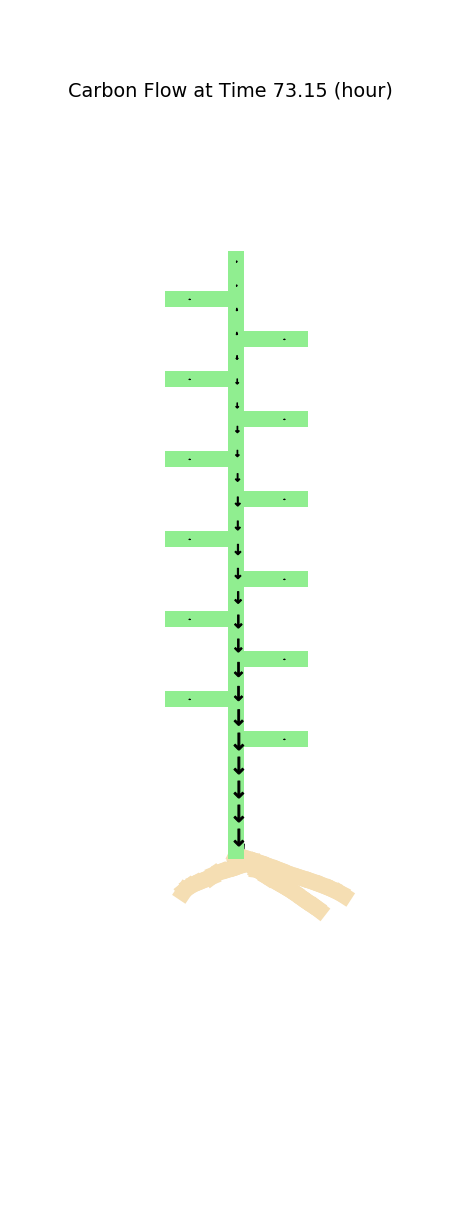

In [223]:
plt.rcParams['figure.figsize'] = [8, 22]

import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 4)][:,0] 
root_nodes = nodes_organtype[(nodes_organtype[:,1]== 2)][:,0] 
leaf_nodes = nodes_organtype[(nodes_organtype[:,1]== 8)][:,0] 
#(nodes_organtype[:,1]== 8)|
#print(stem_nodes)
def organ_color(int):
    if int in leaf_nodes: #int is source 
        return 'lightgreen'
    elif int in root_nodes: #int is sink
        return 'wheat'
    elif int in stem_nodes:
        return 'lightgreen'
    else:
        return 'black'

right_leaf_nodes = np.array([70,94,118,142,166,190])
left_leaf_nodes = np.array([82,106,130,154,178,202])    
    
def add_arrow(node_id,k):
    if node_connection[node_id][0] in right_leaf_nodes:
        if var_all[k][node_id] >0 : #check flow directions
                ax.plot([x_c[node_id]], [y_c[node_id]], [z_c[node_id]], marker="$\u2190$".format(i), #u2192 right arrow
                    markersize=abs(var_all[k][node_id]*1e05*2), color=c1)
        elif var_all[k][node_id] <0 :
                ax.plot([x_c[node_id]], [y_c[node_id]], [z_c[node_id]], marker="$\u2192$".format(i), #u2192 right arrow
                        markersize=abs(var_all[k][node_id]*1e05*2), color="r")          
    elif node_connection[node_id][0] in left_leaf_nodes:
        if var_all[k][node_id] >0 :
                ax.plot([x_c[node_id]], [y_c[node_id]], [z_c[node_id]], marker="$\u2192$".format(i), #u2192 right arrow
                    markersize=abs(var_all[k][node_id]*1e05*2), color=c1)
        elif var_all[k][node_id] <0 :
                ax.plot([x_c[node_id]], [y_c[node_id]], [z_c[node_id]], marker="$\u2190$".format(i), #u2192 right arrow
                        markersize=abs(var_all[k][node_id]*1e05*2), color="r")          
    elif node_connection[node_id][0] in stem_nodes:
        if node_id %6  ==0:
            if var_all[k][node_id] >0 :
                ax.plot([x_c[node_id]], [y_c[node_id]], [z_c[node_id]], marker="$\u2193$".format(i), #u2192 right arrow
                    markersize=abs(var_all[k][node_id]*1e05*2), color=c1)
            elif var_all[k][node_id] <0 :
                ax.plot([x_c[node_id]], [y_c[node_id]], [z_c[node_id]], marker="$\u2191$".format(i), #u2192 right arrow
                        markersize=abs(var_all[k][node_id]*1e05*2), color="r")          
        else:
            ax.plot([x_c[node_id]], [y_c[node_id]], [z_c[node_id]], marker="".format(i), #u2192 right arrow
                        markersize=abs(var_all[k][node_id]*1e05*2), color="r")   



path = '{}{}_output.txt'.format(piaf_munch_p_name, 0)
#pd.read_table(path,sep='\t')
output = pd.read_table(path,sep='\t',header=1)
### C_ST
time = np.array(output.iloc[:, 0])
n_begin = (len(node_connection)+1)*3+1
n_end = n_begin +(len(node_connection))
#print(output.iloc[2, n_begin:n_end])

var_leaf = np.array(output.iloc[:,n_begin + N1L_node[:,0]])
var_root = np.array(output.iloc[:,n_begin + N1R_node[:,0]])
var_n2 = np.array(output.iloc[:,n_begin+ N2_node[:,0]])
var_n3 = np.array(output.iloc[:,n_begin + N3_node[:,0]])



var_all=np.array(output.iloc[:,node_begin:node_begin+len(node_connection)])
time = np.array(output.iloc[:, 0])
for k in range(90,91):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.axis('off')

    x =nodes[:,0]
    y =nodes[:,1]
    z =nodes[:,2]
    # Get rid of colored axes planes
    # First remove fill
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    # Bonus: To get rid of the grid as well:
    ax.grid(False)
    # Bonus: To get rid of the grid as well:
    #ax.grid(False)
    #for i in range(len(nodes_cor)):
    #    ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(nodes_cor[i,1]),
    #            markersize=12, color='black')

    c1= "k"
    c2= "k"
    for i in range(len(node_connection)):
        #xline = [x[node_connection[:,0][i]]],[x[node_connection[:,1][i]]] )
        #yline = np.array([y[node_connection[:,0][i]]],[y[node_connection[:,1][i]]] )
        #zline = np.array([z[node_connection[:,0][i]]],[z[node_connection[:,1][i]]] )
        organ= ax.plot3D(np.array([[x[node_connection[:,0][i]]][0],[x[node_connection[:,1][i]]][0]]), np.array([[y[node_connection[:,0][i]]][0],[y[node_connection[:,1][i]]][0]]), np.array([[z[node_connection[:,0][i]]][0],[z[node_connection[:,1][i]]][0]]), color=organ_color(node_connection[i,0]), linewidth=16)#ax.scatter([x[715]], [y[715]], [z[715]], c='r', s=99)
    #ax.scatter([x[860]], [y[860]], [z[860]], c='g', s=99)
    #ax.scatter([x[627]], [y[627]], [z[627]], c='g', s=99)

    ax.set_title('Carbon Flow at Time {:.2f} (hour)'.format(output.iloc[k, 0]))
    j=0
    for j in range(len(node_connection)): #assign all the source to red large font size
        #if i %3  ==0:
        add_arrow(j, k)
    
    
    ax.dist = 5.0
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    ax.set_ylim3d(2,0)
    ax.set_zlim3d(-1,7.5)
    ax.set_xlim3d(-0.2,0.2)
    ax.view_init(0, 90)

    root_patch = mpatches.Patch(color='wheat', label='root')
    seed_patch = mpatches.Patch(color='black', label='seed')
    stem_patch = mpatches.Patch(color='olive', label='stem')
    leaf_patch = mpatches.Patch(color='lightgreen', label='leaf')
    #plt.legend(handles=[root_patch, seed_patch,stem_patch,leaf_patch],bbox_to_anchor=(0.7, 0.7), loc=2, borderaxespad=0.)
    plt.show()
    fig.savefig("{}{:02d}.png".format('organtype_structure',k), bbox_inches='tight',dpi=300)

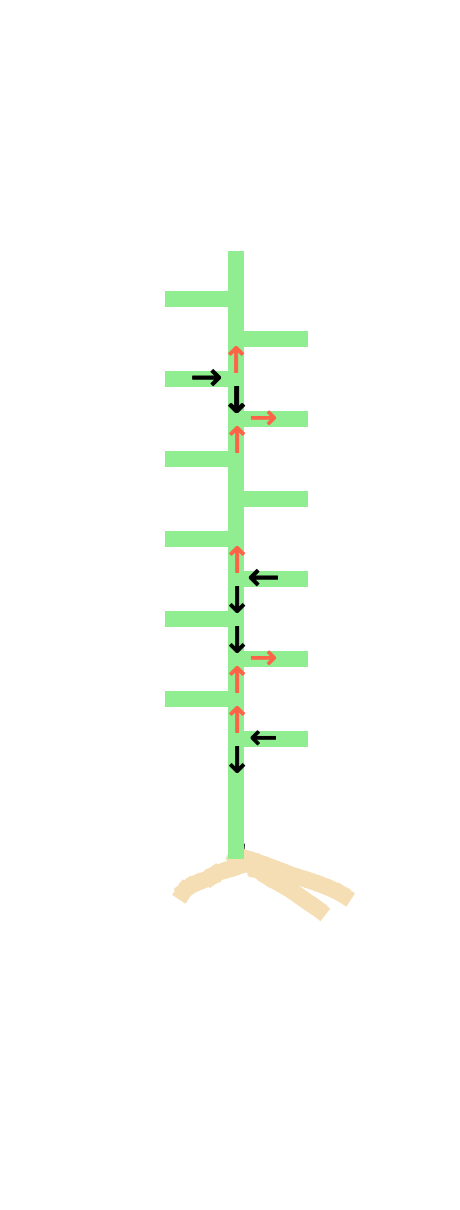

In [71]:



plt.rcParams['figure.figsize'] = [8, 22]

import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 4)][:,0] 
root_nodes = nodes_organtype[(nodes_organtype[:,1]== 2)][:,0] 
leaf_nodes = nodes_organtype[(nodes_organtype[:,1]== 8)][:,0] 
#(nodes_organtype[:,1]== 8)|
#print(stem_nodes)
c1= "k"
c2= "tomato"

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.axis('off')
x =nodes[:,0]
y =nodes[:,1]
z =nodes[:,2]
# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
ax.grid(False)
# Bonus: To get rid of the grid as well:
#ax.grid(False)
#for i in range(len(nodes_cor)):
#    ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(nodes_cor[i,1]),
#            markersize=12, color='black')


for i in range(len(node_connection)):
    #xline = [x[node_connection[:,0][i]]],[x[node_connection[:,1][i]]] )
    #yline = np.array([y[node_connection[:,0][i]]],[y[node_connection[:,1][i]]] )
    #zline = np.array([z[node_connection[:,0][i]]],[z[node_connection[:,1][i]]] )
    organ= ax.plot3D(np.array([[x[node_connection[:,0][i]]][0],[x[node_connection[:,1][i]]][0]]), np.array([[y[node_connection[:,0][i]]][0],[y[node_connection[:,1][i]]][0]]), np.array([[z[node_connection[:,0][i]]][0],[z[node_connection[:,1][i]]][0]]), color=organ_color(node_connection[i,0]), linewidth=16)#ax.scatter([x[715]], [y[715]], [z[715]], c='r', s=99)
#ax.scatter([x[860]], [y[860]], [z[860]], c='g', s=99)
#ax.scatter([x[627]], [y[627]], [z[627]], c='g', s=99)
for i in range(len(nodes_cor)): #assign all the source to red large font size
    if i == 94:
        ax.plot([x[i]+0.106], [y[i]], [z[i]-0.25], marker="$\u2191$".format(i),
                markersize=26, color=c2)
    if i == 94:
        ax.plot([x[i]+0.106], [y[i]], [z[i]+0.25], marker="$\u2193$".format(i),
                markersize=26, color=c1)
    if i == 94:
        ax.plot([x[i]+0.06], [y[i]], [z[i]], marker="$\u2192$".format(i),
                markersize=26, color='tomato')
    if i == 70:
        ax.plot([x[i]+0.106], [y[i]], [z[i]-0.25], marker="$\u2193$".format(i),
                markersize=26, color=c1)
    if i == 70:
        ax.plot([x[i]+0.106], [y[i]], [z[i]+0.25], marker="$\u2191$".format(i),
                markersize=26, color='tomato')
    if i == 70:
        ax.plot([x[i]+0.06], [y[i]], [z[i]], marker="$\u2190$".format(i),
                markersize=26, color=c1)
    if i == 118:
        ax.plot([x[i]+0.106], [y[i]], [z[i]-0.25], marker="$\u2193$".format(i),
                markersize=26, color=c1)
    if i == 118:
        ax.plot([x[i]+0.106], [y[i]], [z[i]+0.25], marker="$\u2191$".format(i),
                markersize=26, color=c2)
    if i == 118:
        ax.plot([x[i]+0.06], [y[i]], [z[i]], marker="$\u2190$".format(i),
                markersize=30
                , color=c1)
    if i == 166:
        ax.plot([x[i]+0.106], [y[i]], [z[i]-0.25], marker="$\u2191$".format(i),
                markersize=26, color='tomato')
    if i == 166:
        ax.plot([x[i]+0.106], [y[i]], [z[i]+0.25], marker="$\u2193$".format(i),
                markersize=26, color=c1)
    if i == 166:
        ax.plot([x[i]+0.06], [y[i]], [z[i]], marker="$\u2192$".format(i),
                markersize=26, color='tomato')
    if i == 178:
        ax.plot([x[i]-0.093], [y[i]], [z[i]-0.25], marker="$\u2193$".format(i),
                markersize=26, color=c1)
    if i == 178:
        ax.plot([x[i]-0.093], [y[i]], [z[i]+0.25], marker="$\u2191$".format(i),
                markersize=26, color='tomato')
    if i == 178:
        ax.plot([x[i]-0.05], [y[i]], [z[i]], marker="$\u2192$".format(i),
                markersize=30
                , color=c1)
    else:
        ax.plot([x[i]], [y[i]], [z[i]], marker=''.format(i),#mapping all the organ color green or yellow
                markersize=12, color=organ_color(i))

#ax.dist = 5.0
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_ylim3d(2,0)
ax.set_zlim3d(-1,7.5)
ax.set_xlim3d(-0.2,0.2)
ax.view_init(0, 90)

root_patch = mpatches.Patch(color='wheat', label='root')
seed_patch = mpatches.Patch(color='black', label='seed')
stem_patch = mpatches.Patch(color='forestgreen', label='stem')
leaf_patch = mpatches.Patch(color='lightgreen', label='leaf')
#plt.legend(handles=[root_patch, seed_patch,stem_patch,leaf_patch],bbox_to_anchor=(0.7, 0.7), loc=2, borderaxespad=0.)
plt.show()
fig.savefig("{}.png".format('organtype_structure'), bbox_inches='tight',dpi=300)

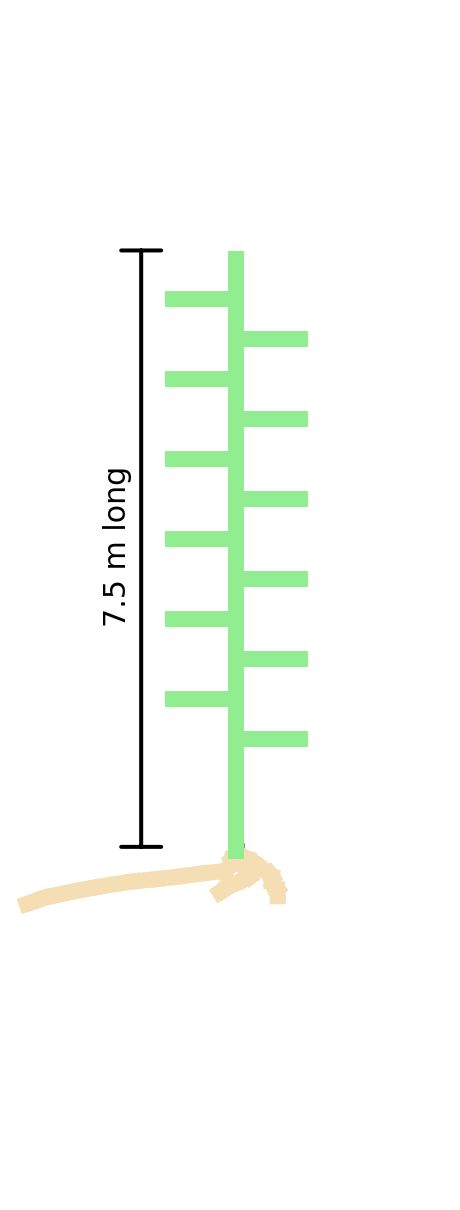

In [14]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = [8, 22]

import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 4)][:,0] 
root_nodes = nodes_organtype[(nodes_organtype[:,1]== 2)][:,0] 
leaf_nodes = nodes_organtype[(nodes_organtype[:,1]== 8)][:,0] 
#(nodes_organtype[:,1]== 8)|
#print(stem_nodes)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.axis('off')
x =nodes[:,0]
y =nodes[:,1]
z =nodes[:,2]
# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
ax.grid(False)
# Bonus: To get rid of the grid as well:
#ax.grid(False)
#for i in range(len(nodes_cor)):
#    ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(nodes_cor[i,1]),
#            markersize=12, color='black')


for i in range(len(node_connection)):
    #xline = [x[node_connection[:,0][i]]],[x[node_connection[:,1][i]]] )
    #yline = np.array([y[node_connection[:,0][i]]],[y[node_connection[:,1][i]]] )
    #zline = np.array([z[node_connection[:,0][i]]],[z[node_connection[:,1][i]]] )
    organ= ax.plot3D(np.array([[x[node_connection[:,0][i]]][0],[x[node_connection[:,1][i]]][0]]), np.array([[y[node_connection[:,0][i]]][0],[y[node_connection[:,1][i]]][0]]), np.array([[z[node_connection[:,0][i]]][0],[z[node_connection[:,1][i]]][0]]), color=organ_color(node_connection[i,0]), linewidth=16)#ax.scatter([x[715]], [y[715]], [z[715]], c='r', s=99)
#ax.scatter([x[860]], [y[860]], [z[860]], c='g', s=99)
#ax.scatter([x[627]], [y[627]], [z[627]], c='g', s=99)
for i in range(len(nodes_cor)): #assign all the source to red large font size
    ax.plot([x[i]], [y[i]], [z[i]], marker=''.format(i),#mapping all the organ color green or yellow
                markersize=12, color=organ_color(i))

ax.dist = 5.0
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_ylim3d(2,0)
ax.set_zlim3d(-1,7.5)
ax.set_xlim3d(-0.2,0.2)
ax.view_init(0, 90)

root_patch = mpatches.Patch(color='wheat', label='root')
seed_patch = mpatches.Patch(color='black', label='seed')
stem_patch = mpatches.Patch(color='olive', label='stem')
leaf_patch = mpatches.Patch(color='lightgreen', label='leaf')
a = Arrow3D([0.15,0.15],[0,0],[0,7.5], mutation_scale=20, lw=4, arrowstyle="|-|", color="k", label="")
ax.add_artist(a)
ax.text(0.21, 0 , 4.5, "7.5 m long", (0,0,1), color='k', fontsize=30 )
#plt.legend(handles=[root_patch, seed_patch,stem_patch,leaf_patch],bbox_to_anchor=(0.7, 0.7), loc=2, borderaxespad=0., prop= {'size': 40})
plt.show()
fig.savefig("{}.png".format('organtype_structure'), bbox_inches='tight',dpi=300)

101
[array([0.]), array([3.16977e-07]), array([0.00027951]), array([0.00379696]), array([0.0100754]), array([0.01541]), array([0.0202099]), array([0.02511]), array([0.030127]), array([0.0351252]), array([0.0400359]), array([0.0448582]), array([0.0496118]), array([0.0543206]), array([0.0590017]), array([0.0636719]), array([0.0683489]), array([0.073046]), array([0.0777769]), array([0.0825536]), array([0.0873873]), array([0.0922873]), array([0.0972632]), array([0.102321]), array([0.107467]), array([0.112702]), array([0.11803]), array([0.123451]), array([0.128967]), array([0.134576]), array([0.140277]), array([0.146069]), array([0.151947]), array([0.157907]), array([0.163943]), array([0.170049]), array([0.176216]), array([0.182439]), array([0.188706]), array([0.195008]), array([0.201337]), array([0.207682]), array([0.214031]), array([0.220375]), array([0.226701]), array([0.232999]), array([0.239256]), array([0.245459]), array([0.251598]), array([0.257665]), array([0.263651]), array([0.2695

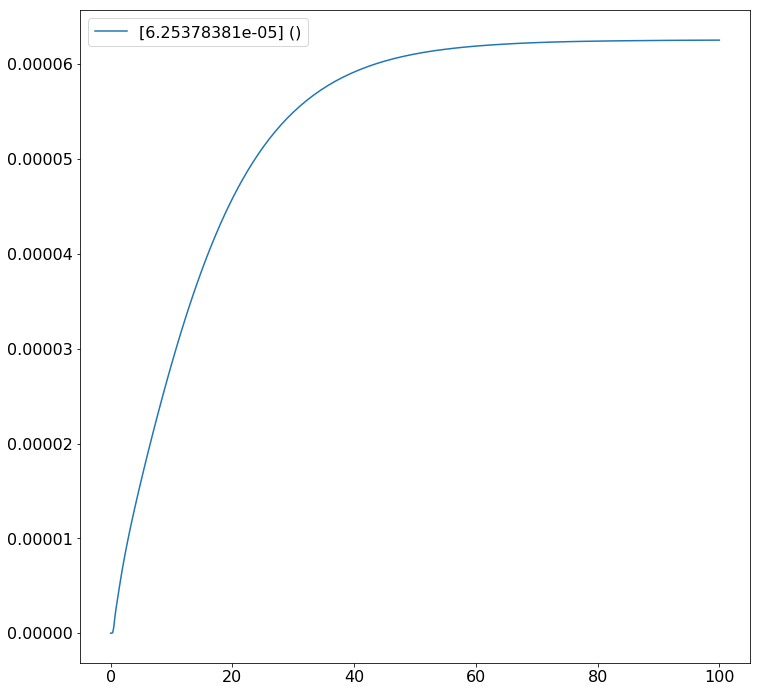

6.253783812140175e-05

In [707]:
y_all = [pt[84:85] for pt in y] 
all_cst = np.array(output.iloc[:, (len(node_connection+1))*3+4:(len(node_connection+1))*4+5 ])
cst_all = [pt[84:85] for pt in all_cst]
print(len(y_all))
print(cst_all)

vunloading = np.zeros(len(cst_all))
for i in range(0,len(cst_all)):
    vunloading[i] = vMU_x[j]*cst_all[i] / (kMU_x[j] +cst_all[i] )
vunloading

plt.plot(x,vunloading,label = '{} ()'.format(vMU_x[1]*cst_all[99] / (kMU_x[1] +cst_all[99])))
plt.legend()
plt.show()
(vMU_x[1]*cst_all[99] / (kMU_x[1] +cst_all[99]))[0]

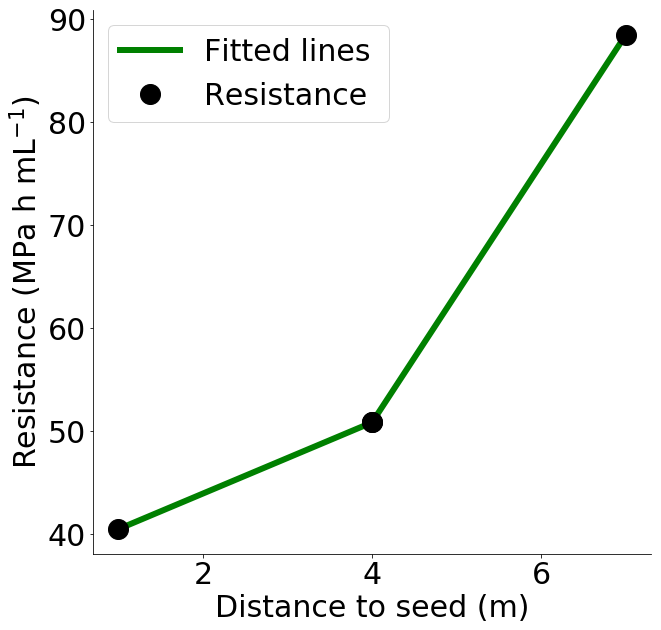

In [108]:
R_name = rr.r['R_name'] #get R object and 
R_in_number = rr.r['R_in_number'] 
R_ex_number = rr.r['R_ex_number']
R_in_number
R_ex_number[0:3]
#Adding deviation error bar later
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 30
ax = plt.subplot(111)
#ax.plot(x, y)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(R_name[0:2], R_ex_number[0:2])
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(R_name[1:3], R_ex_number[1:3])

ax.plot(R_name[0:2], intercept + slope*R_name[0:2], 'g', label='Fitted lines', linewidth = 6)
ax.plot(R_name[1:3], intercept2 + slope2*R_name[1:3], 'g', linewidth = 6)
ax.plot(R_name[0:2], R_ex_number[0:2], 'o',markersize=20,  c='black')
ax.plot(R_name[1:3], R_ex_number[1:3], 'o',markersize=20, label='Resistance ', c='black' )
plt.xlabel("Distance to seed (m)")
plt.ylabel("Resistance (MPa h mL$^{-1}$)")
plt.legend()
plt.show()

In [347]:
piaf_munch_p_name

'testmorning_glory_7mconnection_211'

JW_ST (ml / h)[ 1]


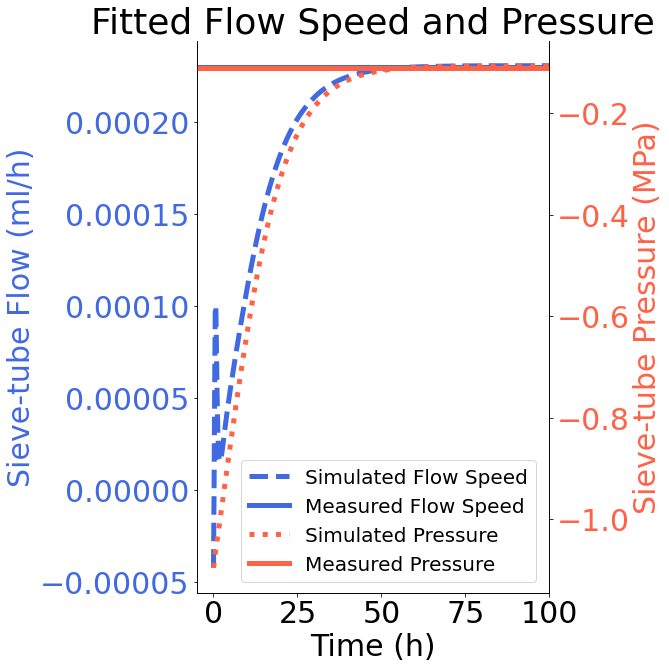

P_ST (MPa)[ 1]


In [24]:
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 30
from scipy.stats import loglaplace,chi2
fig, ax1 = plt.subplots()
color = 'k'
#plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])

    var_leaf = np.array(output.iloc[:,n_begin + N1L_node[:,0]])
    var_root = np.array(output.iloc[:,n_begin + N1R_node[:,0]])
    var_n2 = np.array(output.iloc[:,n_begin+ N2_node[:,0]])
    var_n3 = np.array(output.iloc[:,n_begin + N3_node[:,0]])
    var_all = np.array(output.iloc[:,n_begin:n_end])
    for i in range(31,32):

        JW_XYL = (len(node_connection+1))*i+31 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,JW_XYL:JW_XYL+len(node_connection)])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)

        ax1.set_xlabel("Time (h)")
        ax1.set_ylabel("Sieve-tube Flow (ml/h)",color='royalblue')
        

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    #plt.plot(x,[pt[84:85] for pt in y],label = 'Unloading speed at the end of simulation{:.07}(ml/ h) '.format((vMU_x[1]*cst_all[99] / (kMU_x[1] +cst_all[99]))[0]))
    ax1.plot(x,[pt[84:85] for pt in y],label = 'Simulated Flow Speed'.format(), linewidth=5, linestyle='--',color='royalblue')
plt.xlim(right=100)
    #plt.axhline(y=0.23, color='r', linestyle='-', label='all the volume')
ax1.axhline(y=0.00023, color='royalblue', linestyle='-', label='Measured Flow Speed', linewidth=5)
ax1.spines['top'].set_visible(False)
#ax1.legend()
ax1.tick_params(axis='y', labelcolor='royalblue')
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
#plt.show()
print(output.columns[JW_XYL])
s =output.columns[n_begin]
s = s.replace('/', '')
    #f.savefig("{}.pdf".format(s), bbox_inches='tight')
ax2 = ax1.twinx()    
#f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])

    var_leaf = np.array(output.iloc[:,n_begin + N1L_node[:,0]])
    var_root = np.array(output.iloc[:,n_begin + N1R_node[:,0]])
    var_n2 = np.array(output.iloc[:,n_begin+ N2_node[:,0]])
    var_n3 = np.array(output.iloc[:,n_begin + N3_node[:,0]])
    var_all = np.array(output.iloc[:,n_begin:n_end])
    for i in range(15,16): #NO. of the output (15,16) is pressure

        n_begin = (len(node_connection+1))*i+16 # careful here is the number of connections but not nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)
        sim_p = np.zeros(5)
        total_p= np.zeros(101)
        node_p_no = [70,94,118,166,178]
        i=0
        j=0
        for j in range(0,101):
            for i in range(0,5):
                sim_p[i] = [pt[node_p_no[i]:node_p_no[i]+1] for pt in y][j][0]
                total_p[j] = total_p[j] + sim_p[i]
        ax2.plot(x,total_p/5,label = 'Simulated Pressure'.format(),ls=':' , linewidth=5,color='tomato')
        measuredp = -0.6+(1.08-0.59)
        measuredp
        #ax2.set_xlabel("Time")
        ax2.set_ylabel("Sieve-tube Pressure (MPa)".format(output.columns[n_begin]),color='tomato')
        plt.title("Fitted Flow Speed and Pressure".format(i ,output.columns[n_begin]))
ax2.spines['top'].set_visible(False)
    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
#     plt.plot(x,[pt[84:85] for pt in y],label = '{} ()'.format(vMU_x[j]))
ax2.axhline(y=-0.6+(1.08-0.59), color='tomato', linestyle='-', label='Measured Pressure', linewidth=5)
#ax2.axhline(y=total_p[96]/5, color='b', linestyle='-', label='simulated pressure average')
ax2.tick_params(axis='y', labelcolor='tomato')
fig.tight_layout()
plt.rcParams['font.size'] = 20
fig.legend( loc=(0.36,0.13), shadow=False)
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
    #f.savefig("{}.pdf".format(s), bbox_inches='tight')
    
print(output.columns[n_begin])

In [15]:
len(x)

3001

output successful


/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: FutureWarning: read_table is deprecated, use read_csv instead.


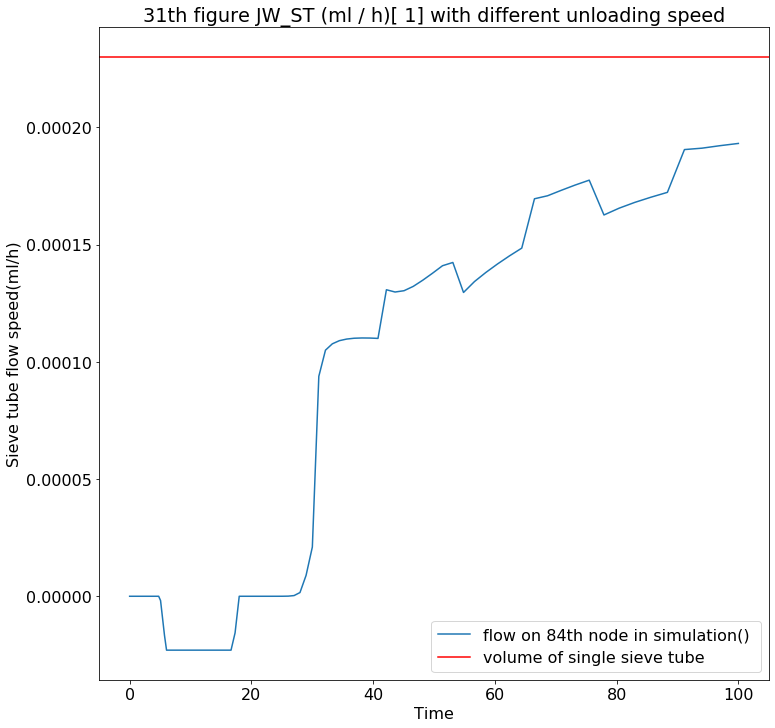

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: read_table is deprecated, use read_csv instead.


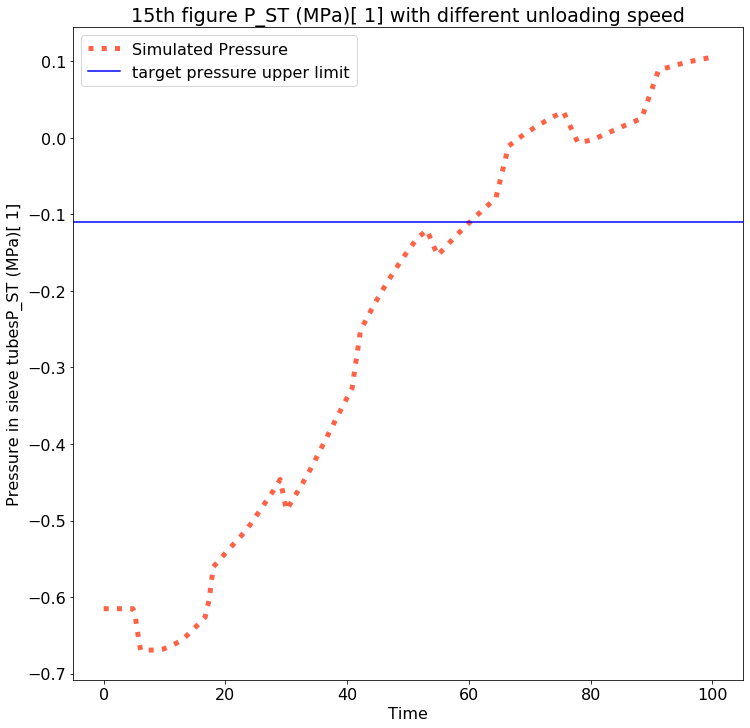

In [26]:
# for average pressure / real xylem pressure
import datetime

now = datetime.datetime.now()
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 12]
#piaf_munch_p_name = 'averageP{}connection_{}'.format(name, len(node_connection) )  #parameter name of piaf munch-- you name it
piaf_munch_p_name = 'realxylem{}connection_{}'.format(name, len(node_connection) )  #parameter name of piaf munch-- you name it


piaf_munch_path ='./'

vMU_x = np.zeros(10)
#need to lower the unloading speed and increase the loading speed. Because flow and pressure are both less 
vMU_x[0] =1.191855954263808e+97
vML_x = np.zeros(10)
vML_x[0] =6.4031395909090895e-06
kMU_x = np.zeros(10)
kMU_x[0] =  1e99 
kML_x = np.zeros(10)
kML_x[0] = 1e-100

for i in range(1,10):
    vMU_x[i] = vMU_x[i-1] 
    vML_x[i] = vML_x[i-1]  
    kMU_x[i] = kMU_x[i-1]
    kML_x[i] = kML_x[i-1] #* 2
#vMU_x


#for i in range(1,4):
        
rst_x = np.zeros(10)
rst_x[0] =1
for i in range(1,10):
    rst_x[i] = rst_x[i-1] 
rst_x   


# for i in range(len(vMU_x)):
for i in range(0,1):
    assign_sink_unloading_speed (vMU_x[i]) #2.82627e+95
    assign_source_loading_speed (vML_x[i])
    rst=(nodes_r_st/rst_x[i])
    r_ST = np.full(len(nodes_organtype), rst)  
    create_piafmunch_parameter( end_time = "100" )
    os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe mg_low1.ini -noGUI -q')
    os.system('mv /mnt/c/cpb1/python/mg_low1_2019-{:02}-{:02}*output.txt  ./{}{}_output.txt'.format(now.month, now.day, piaf_munch_p_name ,i) )


plt.rcParams['figure.figsize'] = [12, 12]
from scipy.stats import loglaplace,chi2
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)

    #print(output.iloc[2, n_begin:n_end])

    for i in range(31,32):

        n_begin = (len(node_connection+1))*i+31 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)
        
        plt.xlabel("Time")
        plt.ylabel("Sieve tube flow speed(ml/h)")
        plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[84:85] for pt in y],label = '{}() '.format("flow on 84th node in simulation"))#vMU_x[j]
#plt.axhline(y=0.23, color='r', linestyle='-', label='all the volume')
plt.axhline(y=0.00023, color='r', linestyle='-', label='volume of single sieve tube')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
    #f.savefig("{}.pdf".format(s), bbox_inches='tight')
    
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])

    for i in range(15,16): #NO. of the output (15,16) is pressure

        n_begin = (len(node_connection+1))*i+16 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)

        plt.xlabel("Time")
        plt.ylabel("Pressure in sieve tubes{}".format(output.columns[n_begin]))
        plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    
    sim_p = np.zeros(5)
    total_p= np.zeros(101)
    node_p_no = [70,94,118,166,178]
    i=0
    j=0
    for j in range(0,101):
        for i in range(0,5):
            sim_p[i] = [pt[node_p_no[i]:node_p_no[i]+1] for pt in y][j][0]
            total_p[j] = total_p[j] + sim_p[i]
    plt.plot(x,total_p/5,label = 'Simulated Pressure'.format(),ls=':' , linewidth=5,color='tomato')
    measuredp = -0.6+(1.11-0.59)
    measuredp
    #ax2.set_xlabel("Time")

plt.axhline(y=-0.6+(1.08-0.59), color='b', linestyle='-', label='target pressure upper limit')
# plt.axhline(y=-0.6+(2.5-0.59), color='b', linestyle='-', label='target pressure lower limit')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
#     f.savefig("{}.pdf".format(s), bbox_inches='tight')

In [8]:
# Write estimation algorithms
# for average pressure / real xylem pressure
import datetime

now = datetime.datetime.now()
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 12]
#piaf_munch_p_name = 'averageP{}connection_{}'.format(name, len(node_connection) )  #parameter name of piaf munch-- you name it
piaf_munch_p_name = 'realxylem{}connection_{}'.format(name, len(node_connection) )  #parameter name of piaf munch-- you name it


piaf_munch_path ='./'

vMU_x = np.zeros(10)
#need to lower the unloading speed and increase the loading speed. Because flow and pressure are both less 
vMU_x[0] =2.82627e95 *1.81575 * 0.318 * 2.23 *1.5  #
vML_x = np.zeros(10)
vML_x[0] =0.00014*0.049*1.06 *0.9#* 0.844#
kMU_x = np.zeros(10)
kMU_x[0] =  1e99 
kML_x = np.zeros(10)
kML_x[0] = 1e-100

for i in range(1,10):
    vMU_x[i] = vMU_x[i-1] 
    vML_x[i] = vML_x[i-1]  
    kMU_x[i] = kMU_x[i-1]
    kML_x[i] = kML_x[i-1] #* 2
#vMU_x


#for i in range(1,4):
        
rst_x = np.zeros(10)
rst_x[0] =1
for i in range(1,10):
    rst_x[i] = rst_x[i-1] 
rst_x   

def run_sim(vMU_x,vML_x):
    i=0
    j=0
    assign_sink_unloading_speed (vMU_x) #2.82627e+95
    assign_source_loading_speed (vML_x)
    rst=(nodes_r_st/rst_x[i])
    r_ST = np.full(len(nodes_organtype), rst)  
    create_piafmunch_parameter( end_time = "100" )
    os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe mg_low1.ini -noGUI -q')
    os.system('mv /mnt/c/cpb1/python/mg_low1_2019-{:02}-{:02}*output.txt  ./{}{}_output.txt'.format(now.month, now.day, piaf_munch_p_name ,i) )

    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection+1))*31+31 # careful here is the number of connections but bot nodes
    n_end = n_begin +(len(node_connection)-1)
    var_all = np.array(output.iloc[:,n_begin:n_end])
    x = np.array(time)
    y = np.array(var_all)
    sim_flow=y[99,85]
    n_begin = (len(node_connection+1))*15+16 # careful here is the number of connections but bot nodes
    n_end = n_begin +(len(node_connection)-1)
    var_all = np.array(output.iloc[:,n_begin:n_end])
    time = np.array(output.iloc[:, 0])

    x = np.array(time)
    y = np.array(var_all)

    node_p_no = [70,94,118,166,178]
    i=0
    j=0
    
    sim_pressure =(y[99,70]+ y[99,94]+ y[99,118]+ y[99,166]+ y[99,178])/5
    print(sim_pressure)
    print(sim_flow)
    return sim_pressure, sim_flow

guess=1.1 
abs_f = np.zeros(100)
abs_p = np.zeros(100)

guess_vml =1.1
guess_vmu =1.1

In [ ]:
#fit both vmu and vml at the same time
k=0
measuredp = -0.6+(1.08-0.59)

for k in range(2,50):
    if sim_flow > 0.00023 and sim_pressure> measuredp:
        vMU_x[0]=vMU_x[0]/guess
        vML_x[0]=vML_x[0]/guess

    elif sim_flow > 0.00023 and sim_pressure< measuredp:
        vMU_x[0]=vMU_x[0]/guess
        vML_x[0]=vML_x[0]*guess

    elif sim_flow < 0.00023 and sim_pressure< measuredp:
        vMU_x[0]=vMU_x[0]*guess
        vML_x[0]=vML_x[0]*guess

    elif sim_flow < 0.00023 and sim_pressure> measuredp:
        vMU_x[0]=vMU_x[0]*guess
        vML_x[0]=vML_x[0]/guess
    
    sim_pressure, sim_flow = run_sim(vMU_x[0],vML_x[0])
    abs_f[k] = sim_flow-0.00023
    abs_p[k] = sim_pressure-measuredp
    if abs_f[k]== abs_f[k-2]:
        guess=1+((guess-1)/2)
    if guess ==1:
        guess =1.1
    print(guess,vMU_x[0],vML_x[0],abs(sim_flow-0.00023),abs(sim_pressure-measuredp))


In [198]:
    abs_f = np.zeros(100)
    abs_p = np.zeros(100)
    abs_f[k] = sim_flow-0.00023
    abs_p[k] = sim_pressure-measuredp
    if abs_f[k]>

SyntaxError: invalid syntax (<ipython-input-198-3354d32e72e1>, line 5)

In [145]:
5.458746714731774e+95 6.54444e-06 3.83500000000002e-06 0.0014882799999998558
run_sim(vMU_x[0],vML_x[0])
#run_sim(vMU_x[0],vML_x[0])

SyntaxError: invalid syntax (<ipython-input-145-2917884f6ddf>, line 1)

In [ ]:
1.0912860978228417e+96 6.6130601518044825e-06 3.2000000000015957e-08 5.040000000136602e-06

In [208]:
# first fit vml then vmu and loop
#if result not updated, it is because another date is used need rerun code
k=0
measuredp = -0.6+(1.08-0.59)

for k in range(2,20):
    if sim_flow > 0.00023 and sim_pressure> measuredp:

        vML_x[0]=vML_x[0]/guess_vml

    elif sim_flow > 0.00023 and sim_pressure< measuredp:

        vMU_x[0]=vMU_x[0]/guess_vml

    elif sim_flow < 0.00023 and sim_pressure< measuredp:

        vML_x[0]=vML_x[0]*guess_vml

    elif sim_flow < 0.00023 and sim_pressure> measuredp:

        vMU_x[0]=vMU_x[0]*guess_vml
    
    sim_pressure, sim_flow = run_sim(vMU_x[0],vML_x[0])
    abs_f[k] = sim_flow-0.00023
    abs_p[k] = sim_pressure-measuredp
    if abs_f[k]== abs_f[k-2]:
        guess_vml=1+((guess_vml-1)/2)
    if guess_vml ==1:
        guess_vml =1.1
    print(guess_vml,vMU_x[0],vML_x[0],abs(sim_flow-0.00023),abs(sim_pressure-measuredp))


output successful


/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: read_table is deprecated, use read_csv instead.


-0.09038936
0.000229906
1.1 2.0729581564924565e+96 6.54444e-06 9.400000000001638e-08 0.019610639999999874
output successful
-0.0908106
0.000230016
1.1 2.2802539721417023e+96 6.54444e-06 1.5999999999980873e-08 0.01918939999999987
output successful
-0.14302732
0.000219189
1.1 2.2802539721417023e+96 5.949490909090908e-06 1.0811000000000002e-05 0.03302732000000014
output successful
-0.0908106
0.000230016
1.05 2.2802539721417023e+96 6.54444e-06 1.5999999999980873e-08 0.01918939999999987
output successful
-0.11797203999999999
0.000224417
1.05 2.2802539721417023e+96 6.2328e-06 5.583000000000004e-06 0.00797204000000011
output successful
-0.0908106
0.000230016
1.025 2.2802539721417023e+96 6.54444e-06 1.5999999999980873e-08 0.01918939999999987
output successful
-0.1046732
0.000227168
1.025 2.2802539721417023e+96 6.384819512195122e-06 2.8320000000000027e-06 0.005326799999999882
output successful
-0.10477282000000002
0.000227194
1.025 2.3372603214452447e+96 6.384819512195122e-06 2.806e-06 0.005227

In [1]:
sim_pressure, sim_flow = run_sim(1.191855954263808e+97,6.4031395909090895e-06)

NameError: name 'run_sim' is not defined

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys


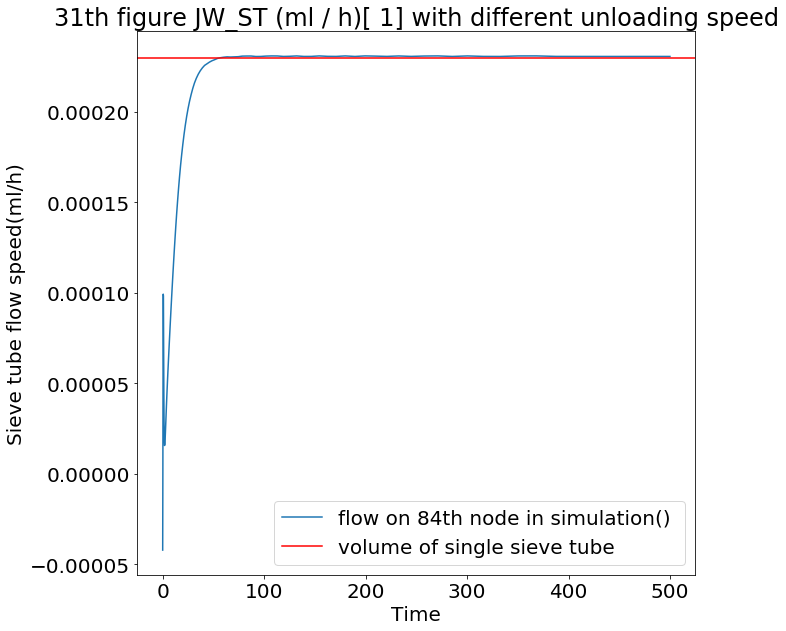

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: read_table is deprecated, use read_csv instead.


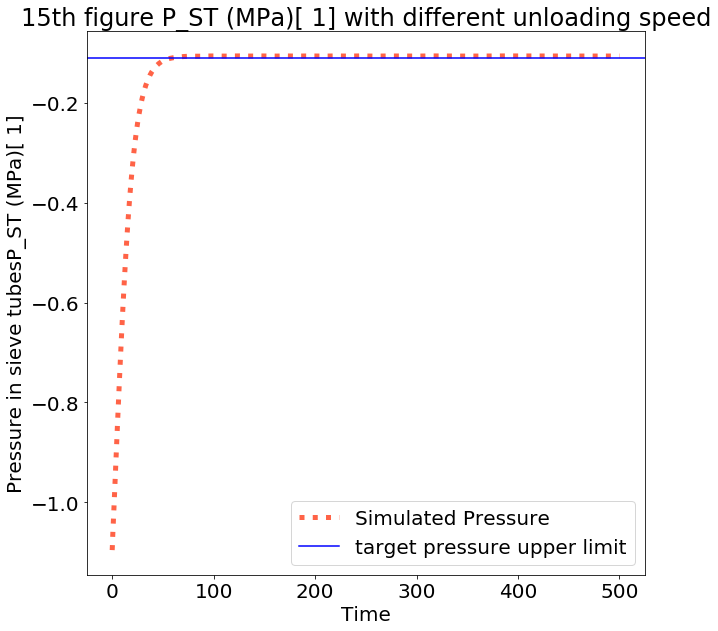

In [105]:
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)

    #print(output.iloc[2, n_begin:n_end])

    for i in range(31,32):

        n_begin = (len(node_connection+1))*i+31 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)
        
        plt.xlabel("Time")
        plt.ylabel("Sieve tube flow speed(ml/h)")
        plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[84:85] for pt in y],label = '{}() '.format("flow on 84th node in simulation"))#vMU_x[j]
#plt.axhline(y=0.23, color='r', linestyle='-', label='all the volume')
plt.axhline(y=0.00023, color='r', linestyle='-', label='volume of single sieve tube')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
    #f.savefig("{}.pdf".format(s), bbox_inches='tight')
    
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])

    for i in range(15,16): #NO. of the output (15,16) is pressure

        n_begin = (len(node_connection+1))*i+16 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)

        plt.xlabel("Time")
        plt.ylabel("Pressure in sieve tubes{}".format(output.columns[n_begin]))
        plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    
    sim_p = np.zeros(5)
    total_p= np.zeros(101)
    node_p_no = [70,94,118,166,178]
    i=0
    j=0
    for j in range(0,101):
        for i in range(0,5):
            sim_p[i] = [pt[node_p_no[i]:node_p_no[i]+1] for pt in y][j][0]
            total_p[j] = total_p[j] + sim_p[i]
    plt.plot(x,total_p/5,label = 'Simulated Pressure'.format(),ls=':' , linewidth=5,color='tomato')
    measuredp = -0.6+(1.08-0.59)
    measuredp
    #ax2.set_xlabel("Time")

plt.axhline(y=-0.6+(1.08-0.59), color='b', linestyle='-', label='target pressure upper limit')
# plt.axhline(y=-0.6+(2.5-0.59), color='b', linestyle='-', label='target pressure lower limit')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
#     f.savefig("{}.pdf".format(s), bbox_inches='tight')

In [122]:
sim_pressure, sim_flow =run_sim(vMU_x[0],vML_x[0])
print(sim_pressure, sim_flow)

output successful


/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: read_table is deprecated, use read_csv instead.


-0.07527430000000002
0.00022604599999999998
-0.07527430000000002 0.00022604599999999998


In [63]:
j=0
path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
#pd.read_table(path,sep='\t')
output = pd.read_table(path,sep='\t',header=1)
### C_ST
time = np.array(output.iloc[:, 0])
n_begin = (len(node_connection+1))*31+31 # careful here is the number of connections but bot nodes
n_end = n_begin +(len(node_connection)-1)
var_all = np.array(output.iloc[:,n_begin:n_end])
x = np.array(time)
y = np.array(var_all)
n_begin = (len(node_connection+1))*15+16 # careful here is the number of connections but bot nodes
n_end = n_begin +(len(node_connection)-1)
var_all = np.array(output.iloc[:,n_begin:n_end])
time = np.array(output.iloc[:, 0])

x = np.array(time)
y = np.array(var_all)
sim_p = np.zeros(5)
total_p= np.zeros(101)
node_p_no = [70,94,118,166,178]
i=0
j=0
for j in range(0,101):
    for i in range(0,5):
        sim_p[i] = [pt[node_p_no[i]:node_p_no[i]+1] for pt in y][j][0]
        total_p[j] = total_p[j] + sim_p[i]
sim_pressure =total_p[85]/5
print(sim_pressure)


/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.


-0.07851172


In [64]:
measuredp = -0.6+(1.11-0.59)
measuredp

-0.07999999999999985

output successful


/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: FutureWarning: read_table is deprecated, use read_csv instead.


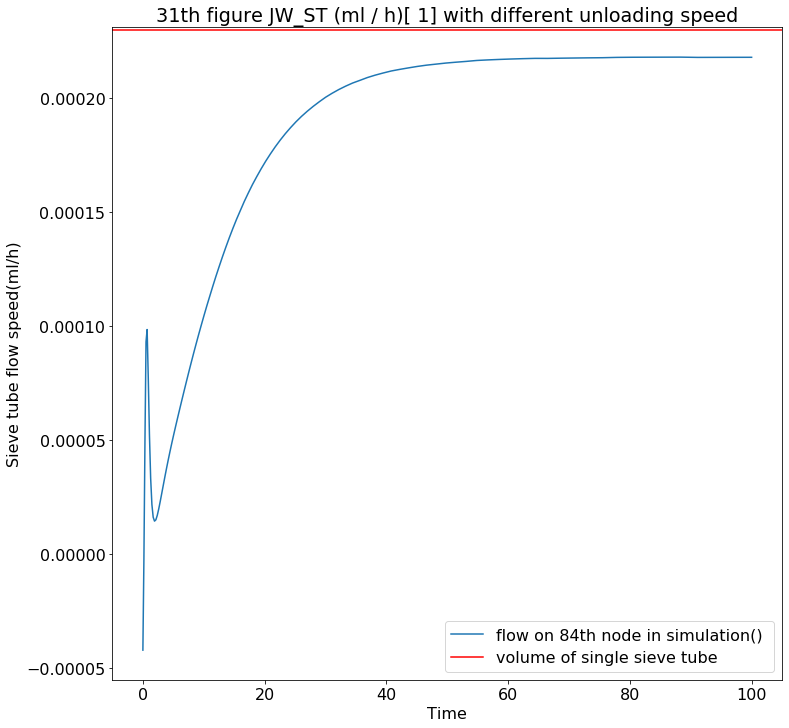

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: FutureWarning: read_table is deprecated, use read_csv instead.


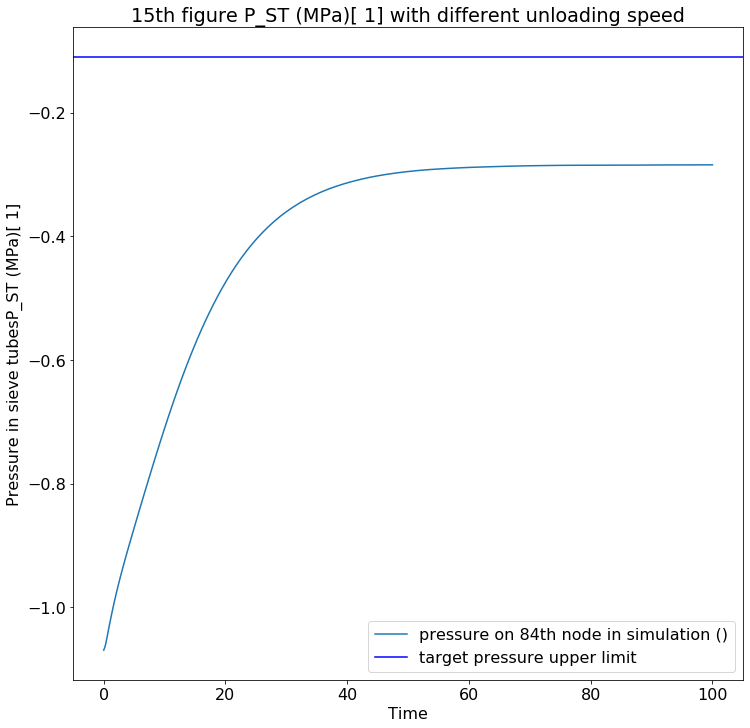

In [18]:
# for average pressure /high 
import datetime

now = datetime.datetime.now()
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 12]
#piaf_munch_p_name = 'averageP{}connection_{}'.format(name, len(node_connection) )  #parameter name of piaf munch-- you name it
piaf_munch_p_name = 'test{}connection_{}'.format(name, len(node_connection) )  #parameter name of piaf munch-- you name it


piaf_munch_path ='./'

vMU_x = np.zeros(10)
vMU_x[0] =2.82627e95 *1.81575 * 0.318 * 2.23#
vML_x = np.zeros(10)
vML_x[0] =0.00014*0.049*1.06 * 0.844#
kMU_x = np.zeros(10)
kMU_x[0] =  1e99 
kML_x = np.zeros(10)
kML_x[0] = 1e-100

for i in range(1,10):
    vMU_x[i] = vMU_x[i-1] 
    vML_x[i] = vML_x[i-1]  
    kMU_x[i] = kMU_x[i-1]
    kML_x[i] = kML_x[i-1] #* 2
#vMU_x


#for i in range(1,4):
        
rst_x = np.zeros(10)
rst_x[0] =1
for i in range(1,10):
    rst_x[i] = rst_x[i-1] 
rst_x   


# for i in range(len(vMU_x)):
for i in range(0,1):
    assign_sink_unloading_speed (vMU_x[i]) #2.82627e+95
    assign_source_loading_speed (vML_x[i])
    rst=(nodes_r_st/rst_x[i])
    r_ST = np.full(len(nodes_organtype), rst)  
    create_piafmunch_parameter( end_time = "100" )
    os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe mg_low1.ini -noGUI -q')
    os.system('mv /mnt/c/cpb1/python/mg_low1_2019-{:02}-{:02}*output.txt  ./{}{}_output.txt'.format(now.month, now.day, piaf_munch_p_name ,i) )


plt.rcParams['figure.figsize'] = [12, 12]
from scipy.stats import loglaplace,chi2
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])

    for i in range(31,32):

        n_begin = (len(node_connection+1))*i+31 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)
        
        plt.xlabel("Time")
        plt.ylabel("Sieve tube flow speed(ml/h)")
        plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[84:85] for pt in y],label = '{}() '.format("flow on 84th node in simulation"))#vMU_x[j]
#plt.axhline(y=0.23, color='r', linestyle='-', label='all the volume')
plt.axhline(y=0.00023, color='r', linestyle='-', label='volume of single sieve tube')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
    #f.savefig("{}.pdf".format(s), bbox_inches='tight')
    
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])

    for i in range(15,16): #NO. of the output (15,16) is pressure

        n_begin = (len(node_connection+1))*i+16 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)

        plt.xlabel("Time")
        plt.ylabel("Pressure in sieve tubes{}".format(output.columns[n_begin]))
        plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[84:85] for pt in y],label = '{} ()'.format("pressure on 84th node in simulation")) #vMU_x[j]
plt.axhline(y=-0.6+(1.08-0.59), color='b', linestyle='-', label='target pressure upper limit')
# plt.axhline(y=-0.6+(2.5-0.59), color='b', linestyle='-', label='target pressure lower limit')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
#     f.savefig("{}.pdf".format(s), bbox_inches='tight')

In [8]:
os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe')
  

768

In [10]:
#fit average
import datetime

now = datetime.datetime.now()
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 12]
piaf_munch_p_name = 'averageP{}connection_{}'.format(name, len(node_connection) )  #parameter name of piaf munch-- you name it
piaf_munch_path ='./'

vMU_x = np.zeros(10) # mmol/ h c_st unit is mmol/ml
vMU_x[0] =2.82627e95 *1.81575 * 0.326#
vML_x = np.zeros(10) # mmol/ h
vML_x[0] =0.00014*0.049*1.06
kMU_x = np.zeros(10) # mmol/ ml
kMU_x[0] =  1e99  # mmol/ ml
kML_x = np.zeros(10)
kML_x[0] = 1e-100

for i in range(1,10):
    vMU_x[i] = vMU_x[i-1] 
    vML_x[i] = vML_x[i-1]  
    kMU_x[i] = kMU_x[i-1]
    kML_x[i] = kML_x[i-1] #* 2
#vMU_x


#for i in range(1,4):
        
rst_x = np.zeros(10)
rst_x[0] =1
for i in range(1,10):
    rst_x[i] = rst_x[i-1] 
rst_x   


# for i in range(len(vMU_x)):
for i in range(0,1):
    assign_sink_unloading_speed (vMU_x[i]) #2.82627e+95
    assign_source_loading_speed (vML_x[i])
    rst=(nodes_r_st/rst_x[i])
    r_ST = np.full(len(nodes_organtype), rst)  
    create_piafmunch_parameter( end_time = "100" )
    os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe mg_low1.ini -noGUI -q')
    os.system('mv /mnt/c/cpb1/python/mg_low1_2019-{:02}-{:02}*output.txt  ./{}{}_output.txt'.format(now.month, now.day, piaf_munch_p_name ,i) )


plt.rcParams['figure.figsize'] = [12, 12]
from scipy.stats import loglaplace,chi2
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])

    for i in range(31,32):

        n_begin = (len(node_connection+1))*i+31 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)
        
        plt.xlabel("Time")
        plt.ylabel("Sieve tube flow speed(ml/h)")
        plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[84:85] for pt in y],label = '{}() '.format("flow on 84th node in simulation"))#vMU_x[j]
#plt.axhline(y=0.23, color='r', linestyle='-', label='all the volume')
plt.axhline(y=0.00023, color='r', linestyle='-', label='volume of single sieve tube')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
    #f.savefig("{}.pdf".format(s), bbox_inches='tight')
    
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])

    for i in range(15,16): #NO. of the output (15,16) is pressure

        n_begin = (len(node_connection+1))*i+16 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)

        plt.xlabel("Time")
        plt.ylabel("Pressure in sieve tubes{}".format(output.columns[n_begin]))
        plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[84:85] for pt in y],label = '{} ()'.format("pressure on 84th node in simulation")) #vMU_x[j]
plt.axhline(y=-0.6+(1.08-0.59), color='b', linestyle='-', label='target pressure upper limit')
# plt.axhline(y=-0.6+(2.5-0.59), color='b', linestyle='-', label='target pressure lower limit')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
#     f.savefig("{}.pdf".format(s), bbox_inches='tight')

output successful


/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: read_table is deprecated, use read_csv instead.


FileNotFoundError: [Errno 2] File b'averagePAnagallis_femina_Leitner_2010connection_39330_output.txt' does not exist: b'averagePAnagallis_femina_Leitner_2010connection_39330_output.txt'

<Figure size 864x864 with 0 Axes>

In [174]:
# for i in [70,]
import datetime

now = datetime.datetime.now()

piaf_munch_p_name = 'fluctP{}connection_{}'.format(name, len(node_connection) )  #parameter name of piaf munch-- you name it
piaf_munch_path ='./'
for i in range(0,1):
#     assign_sink_unloading_speed (vMU_x[i]) #2.82627e+95
#     assign_source_loading_speed (vML_x[i])
#     rst=(nodes_r_st/rst_x[i])
#     r_ST = np.full(len(nodes_organtype), rst)  
    create_piafmunch_parameter( end_time = "100" )
    os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe mg_low1.ini -noGUI -q')
#     os.system('mv /mnt/c/Users/zxrzx/OneDrive/cpb1/python/mg_low1_2019-{:02}-{:02}*output.txt \"{}{}_output.txt\"'.format(now.month, now.day, piaf_munch_p_name ,i) )
    os.system('mv /mnt/c/cpb1/python/mg_low1_2019-{:02}-{:02}*output.txt  ./{}{}_output.txt'.format(now.month, now.day, piaf_munch_p_name ,i) )


output successful


In [244]:
assign_source_loading_speed (vML_x[0])

leaf_mL = np.zeros(15)
leaf_mU = np.zeros(15)
j = 0
for i in range(len(nodes_organtype)):

    if (nodes_organtype[i,1] == 8 or nodes_organtype[i,1] == 4) and nodes_organtype[i,2] == 1:
        j= j+1

        if j ==3 :
            
            vML[i]= 0 #
            vMU[i]= 0#2.82627e95 *2.3 #
            kMU[i]= 1e99
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        elif j== 9:
            vML[i]= 0 #
            vMU[i]= 0#2.82627e95 *30 #
            kMU[i]= 1e99
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        
        elif j ==1 or j ==2 :
            vML[i]= 0.000021#0.00013 # #
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        elif  j ==5  :    
            vML[i]= 0.000015#0.000021#0.000172 # #
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        elif  5<j<9 or j==4  :
            vML[i]=  0.000015#            vML[i]= 0.000005 #
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        elif j>9 :
            vML[i]= 0# 0.000021#            vML[i]= 0.000005 #
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
    
print(j)

13


In [422]:
#right values
assign_source_loading_speed (vML_x[0])

leaf_mL = np.zeros(15)
leaf_mU = np.zeros(15)
j = 0
for i in range(len(nodes_organtype)):

    if (nodes_organtype[i,1] == 8 or nodes_organtype[i,1] == 4) and nodes_organtype[i,2] == 1:
        j= j+1

        if j ==3 :
            
            vML[i]= 0 #
            vMU[i]= 2.82627e95 *2.3 #
            kMU[i]= 1e99
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        elif j== 9:
            vML[i]= 0 #
            vMU[i]= 2.82627e95 *4.5 #
            kMU[i]= 1e99
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        
        elif j ==1 or j ==2 :
            vML[i]= 0.00012 # #
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        elif  j ==5  :    
            vML[i]= 0.00012 # #
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        elif  5<j<9 or j==4  :
            vML[i]=  0.000009#            vML[i]= 0.000005 #
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        elif j>9 :
            vML[i]=  0.000027#            vML[i]= 0.000005 #
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
    
print(j)


13


In [173]:
#for more resistance in xylem final
assign_source_loading_speed (vML_x[0])

leaf_mL = np.zeros(15)
leaf_mU = np.zeros(15)
j = 0
for i in range(len(nodes_organtype)):

    if (nodes_organtype[i,1] == 8 or nodes_organtype[i,1] == 4) and nodes_organtype[i,2] == 1:
        j= j+1

        if j ==3 :
            
            vML[i]= 0 #
            vMU[i]= 2.82627e95 *2.3 #
            kMU[i]= 1e99
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        elif j== 9:
            vML[i]= 0 #
            vMU[i]= 2.82627e95 *4.5 #
            kMU[i]= 1e99
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        
        elif j ==1 or j ==2 :
            vML[i]= 0.00015 # #
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        elif  j ==5  :    
            vML[i]= 0.00015 # #
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        elif  5<j<9 or j==4  :
            vML[i]=  0.000012#            vML[i]= 0.000005 #
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
        elif j>9 :
            vML[i]=  0.000027#            vML[i]= 0.000005 #
            leaf_mL[j] = vML[i]
            leaf_mU[j] = vMU[i]
    
print(j)


13


In [1]:
R_name = rr.r['R_name'] #get R object and 
R_in_number = rr.r['R_in_number'] 
R_ex_number = rr.r['R_ex_number']
R_in_number
R_ex_number[0:3]
#Adding deviation error bar later
plt.rcParams['figure.figsize'] = [10, 10]
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(R_name[0:2], R_ex_number[0:2])
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(R_name[1:3], R_ex_number[1:3])
plt.plot(R_name[0:2], R_ex_number[0:2], 'o', label='Resistance in external phloem')
plt.plot(R_name[1:3], R_ex_number[1:3], 'o', label='Resistance in external phloem', c='black' )
plt.plot(R_name[0:2], intercept + slope*R_name[0:2], 'r', label='fitted line1')
plt.plot(R_name[1:3], intercept2 + slope2*R_name[1:3], 'r', label='fitted line2')
plt.xlabel("Distance to seed (meter)")
plt.ylabel("Resistance (MPa h mL$^{-1}$))")
plt.legend()
plt.show()

NameError: name 'rr' is not defined

In [27]:
assign_sink_unloading_speed (vMU_x[0]) #2.82627e+95
# assign_source_loading_speed (vML_x[0])
vML
os.system('mv /mnt/c/cpb1/python/mg_low1_2019-{:02}-{:02}*output.txt  ./{}{}_output.txt'.format(now.month, now.day, piaf_munch_p_name ,i) )



256

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: read_table is deprecated, use read_csv instead.
  if sys.path[0] == '':


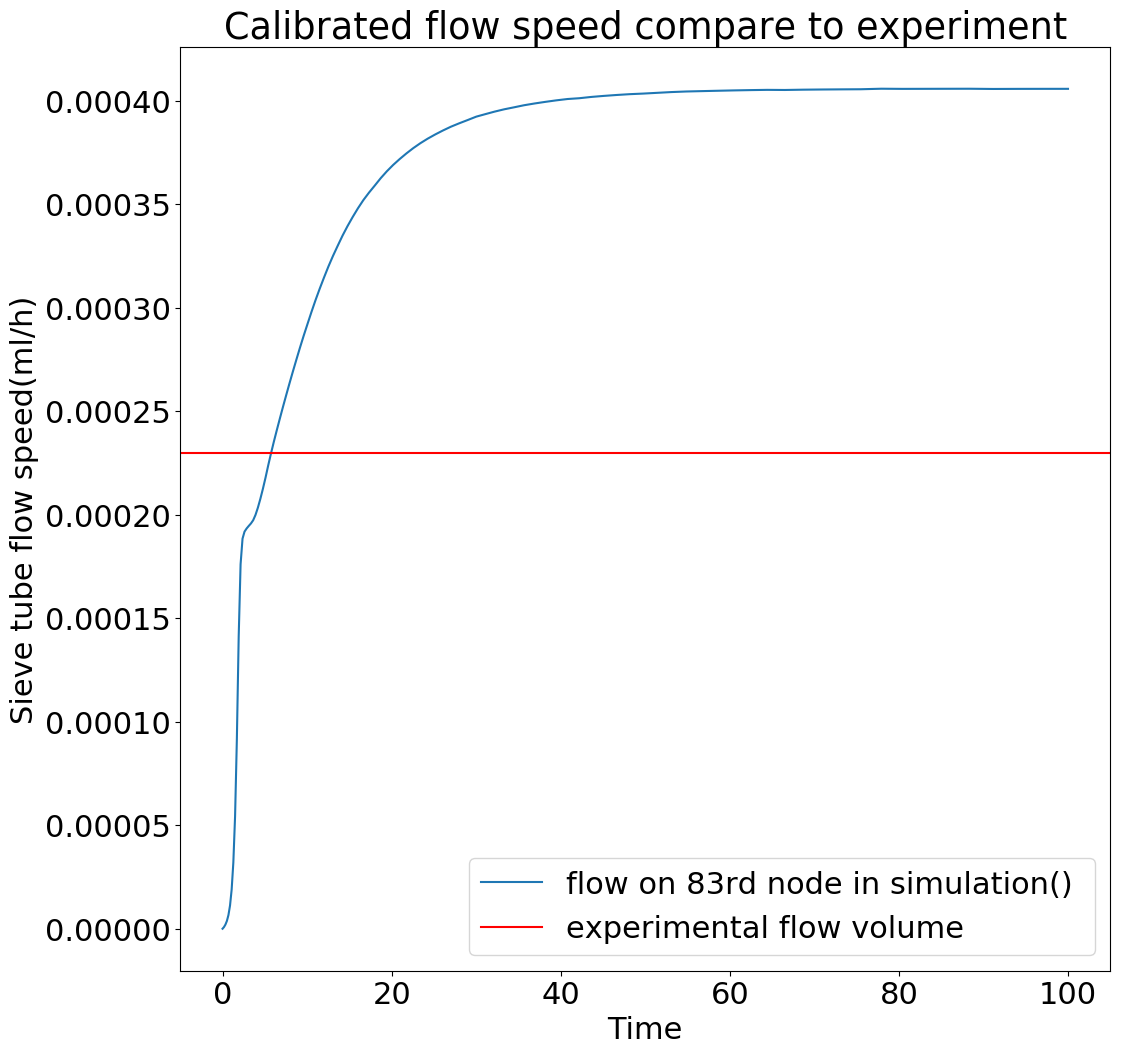

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: read_table is deprecated, use read_csv instead.


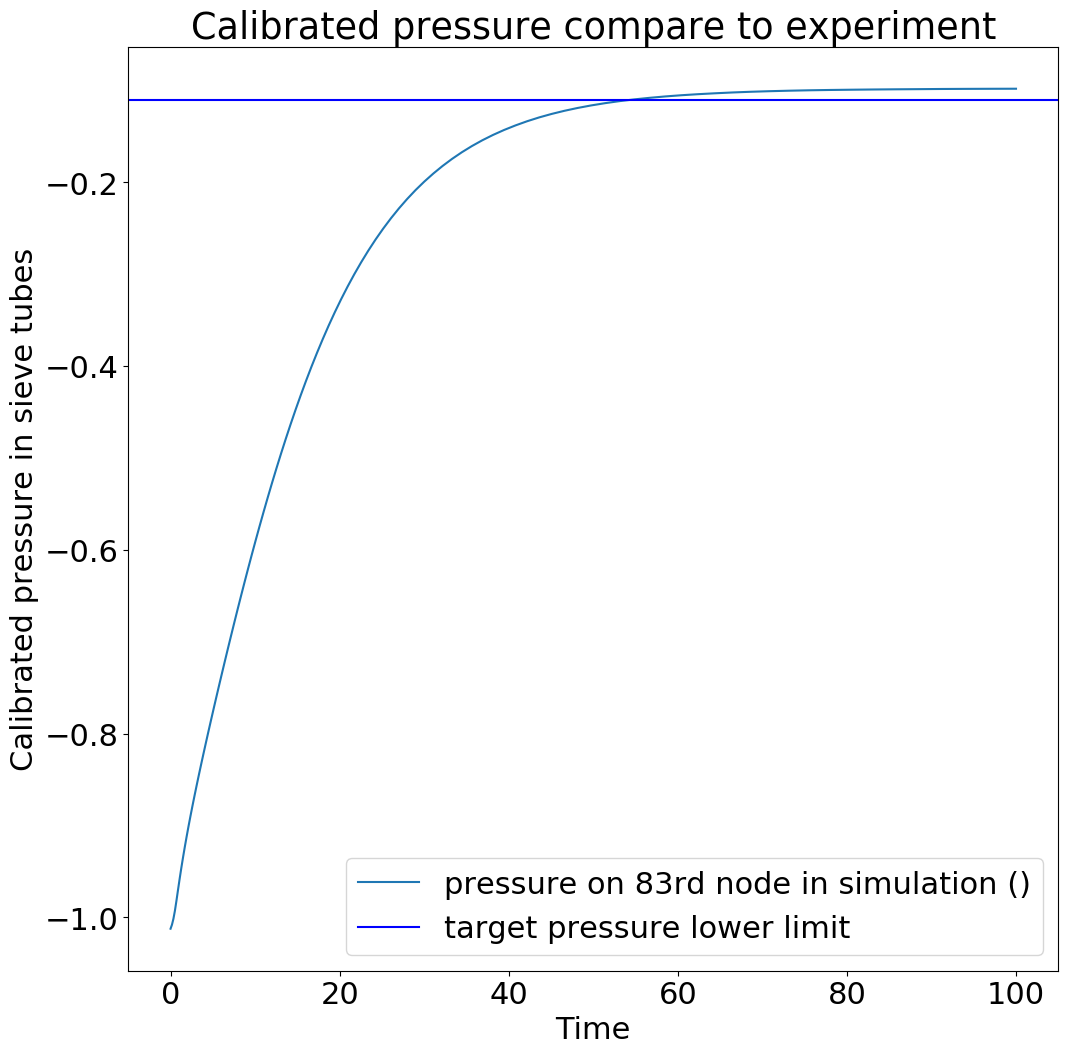

In [28]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = [12, 12]
from scipy.stats import loglaplace,chi2
f = plt.figure()


    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])

    for i in range(31,32):

        n_begin = (len(node_connection+1))*i+31 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])
        limited_time = time[0:40]
        limited_time
        limited_var_all =var_all[0:40]
        x = np.array(time)
        y = np.array(var_all)
        
        plt.xlabel("Time")
        plt.ylabel("Sieve tube flow speed(ml/h)")
        plt.title("Calibrated flow speed compare to experiment".format(i ,output.columns[n_begin]))

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[50:51] for pt in y],label = '{}() '.format("flow on 83rd node in simulation"))
#plt.axhline(y=0.23, color='r', linestyle='-', label='all the volume')
plt.axhline(y=0.00023, color='r', linestyle='-', label='experimental flow volume')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
    #f.savefig("{}.pdf".format(s), bbox_inches='tight')
    
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])

    for i in range(15,16): #NO. of the output (15,16) is pressure

        n_begin = (len(node_connection+1))*i+16 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])
        limited_time = time[0:40]
        limited_time
        limited_var_all =var_all[0:40]
        x = np.array(time)
        y = np.array(var_all)

        plt.xlabel("Time")
        plt.ylabel("Calibrated pressure in sieve tubes".format(output.columns[n_begin]))
#         plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))
        plt.title("Calibrated pressure compare to experiment".format(i ,output.columns[n_begin]))
    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[85:86] for pt in y],label = '{} ()'.format("pressure on 83rd node in simulation")) #vMU_x[j]
plt.axhline(y=-0.6+(1.08-0.59), color='b', linestyle='-', label='target pressure lower limit')
# plt.axhline(y=-0.6+(1.3-0.59), color='g', linestyle='-', label='experimental pressure')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
    #f.savefig("{}.pdf".format(s), bbox_inches='tight')

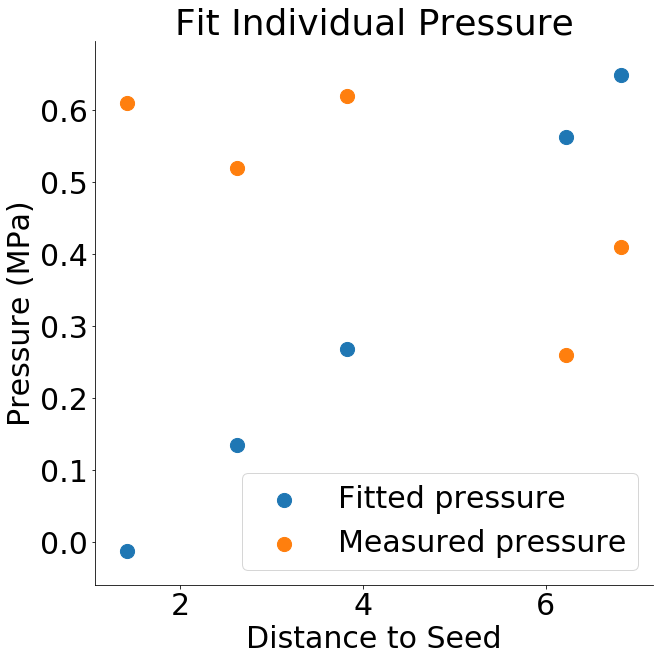

In [93]:
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 30
mg_pressure_y = [var_all[99,70:71][0],var_all[99,94:95][0], var_all[99,118:119][0], var_all[99,166:167][0], var_all[99,178:179][0], ]

mg_distance_x = [nodes_cor[69][5],nodes_cor[93][5], nodes_cor[117][5], nodes_cor[165][5], nodes_cor[177][5] ]
mg_n_no= [1,3,5,9,10]
mg_pressure_m_y = [1.2,1.11,1.21,0.85,1.00]
mg_pressure_y[:] = [x  +0.59 for x in mg_pressure_y ]
mg_pressure_m_y[:] = [x  -0.59 for x in mg_pressure_m_y ]
var_all[93,93:94] 
nodes_cor[209][5]
mg_distance_x
mg_pressure_y

ax = plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Fit Individual Pressure")
plt.scatter(x=mg_distance_x, y= mg_pressure_y , label = "Fitted pressure", s = 200)
plt.scatter(x=mg_distance_x, y= mg_pressure_m_y,  label = "Measured pressure", s = 200)
plt.xlabel("Distance to Seed", fontsize=30)
plt.ylabel("Pressure (MPa)", fontsize=30)

# fit = np.polyfit(mg_distance_x, mg_pressure_y ,1)
# fit_fn = np.poly1d(fit) 
# fit_m = np.polyfit(mg_distance_x, mg_pressure_m_y,1 )
# fit_fn_m = np.poly1d(fit_m) 
# plt.plot(x, mg_pressure_y,'yo', x, fit_fn(x), '--k')
# plt.plot(x,mg_pressure_m_y,'yo', x, fit_fn_m(x), '--k')
plt.legend()
plt.show()




In [37]:
from scipy import stats

slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(x,y)
slopeM, interceptM, r_valueM, p_valueM, std_errM = stats.linregress(x,y)

r square is 0.983082051391347
p value is 0.0009387050390491353
std_err is 0.08761757150661031


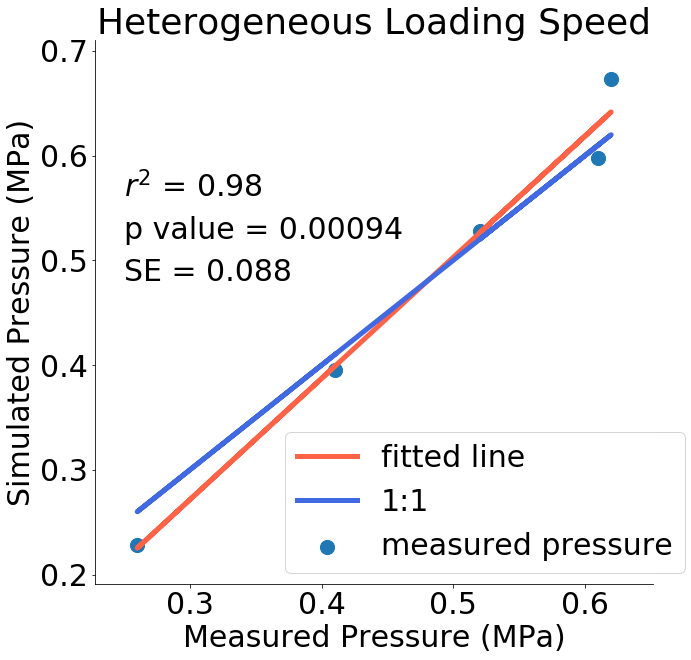

In [52]:
x = mg_pressure_m_y
y= mg_pressure_y
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = [10, 10]
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.title("Equal Loading")
plt.title("Heterogeneous Loading Speed")
ax.scatter(x=x, y= y,  label = "measured pressure",s=200)
plt.xlabel("Measured Pressure (MPa)")
plt.ylabel("Simulated Pressure (MPa)")
slopeS, interceptS, r_valueS, p_valueS, std_errS = stats.linregress(x,y)
mg_x = np.asarray(x, dtype=np.float32)
print("r square is {}".format(r_valueS**2))
print("p value is {}".format(p_valueS))
print("std_err is {}".format(std_errS))

plt.text( 0.25,0.56 , "$r^2$ = {:.02}".format(r_valueS**2), fontsize=30)
plt.text( 0.25,0.52 , "p value = {:.02}".format(p_valueS), fontsize=30)
plt.text( 0.25,0.48 , "SE = {:.02}".format(std_errS), fontsize=30)

ax.plot(mg_x, interceptS + slopeS*mg_x, 'tomato', label='fitted line', linewidth=5)
ax.plot(mg_x, mg_x, 'royalblue', label='1:1', linewidth=5)
#plt.legend(loc=(0.03,0.02)) #for hemogeneous loading speed
plt.legend(loc=(0.34,0.02)) #for hemetrogeneous loading speed
plt.show()
#mean square error

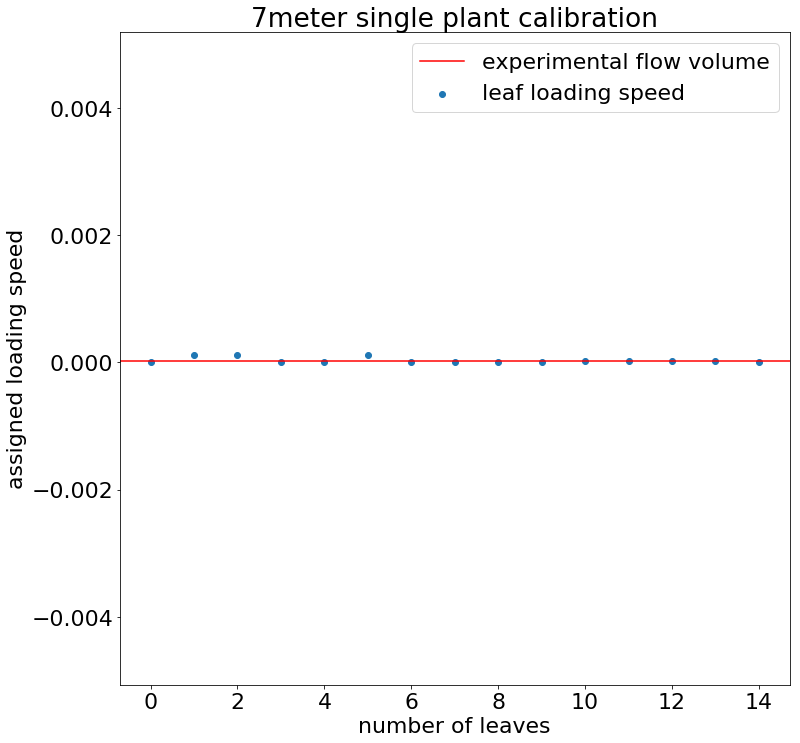

In [427]:
f = plt.figure(0)
aaa=np.arange(0,15)
plt.title("7meter single plant calibration")
plt.scatter(x=aaa, y=leaf_mL,  label = "leaf loading speed")
plt.xlabel("number of leaves")
plt.ylabel("assigned loading speed")
#plt.ylim((-0.000023, 0.00003))
plt.axhline(y=0.000023, color='r', linestyle='-', label='experimental flow volume')
    
    
plt.legend()
plt.show()

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: read_table is deprecated, use read_csv instead.
  del sys.path[0]


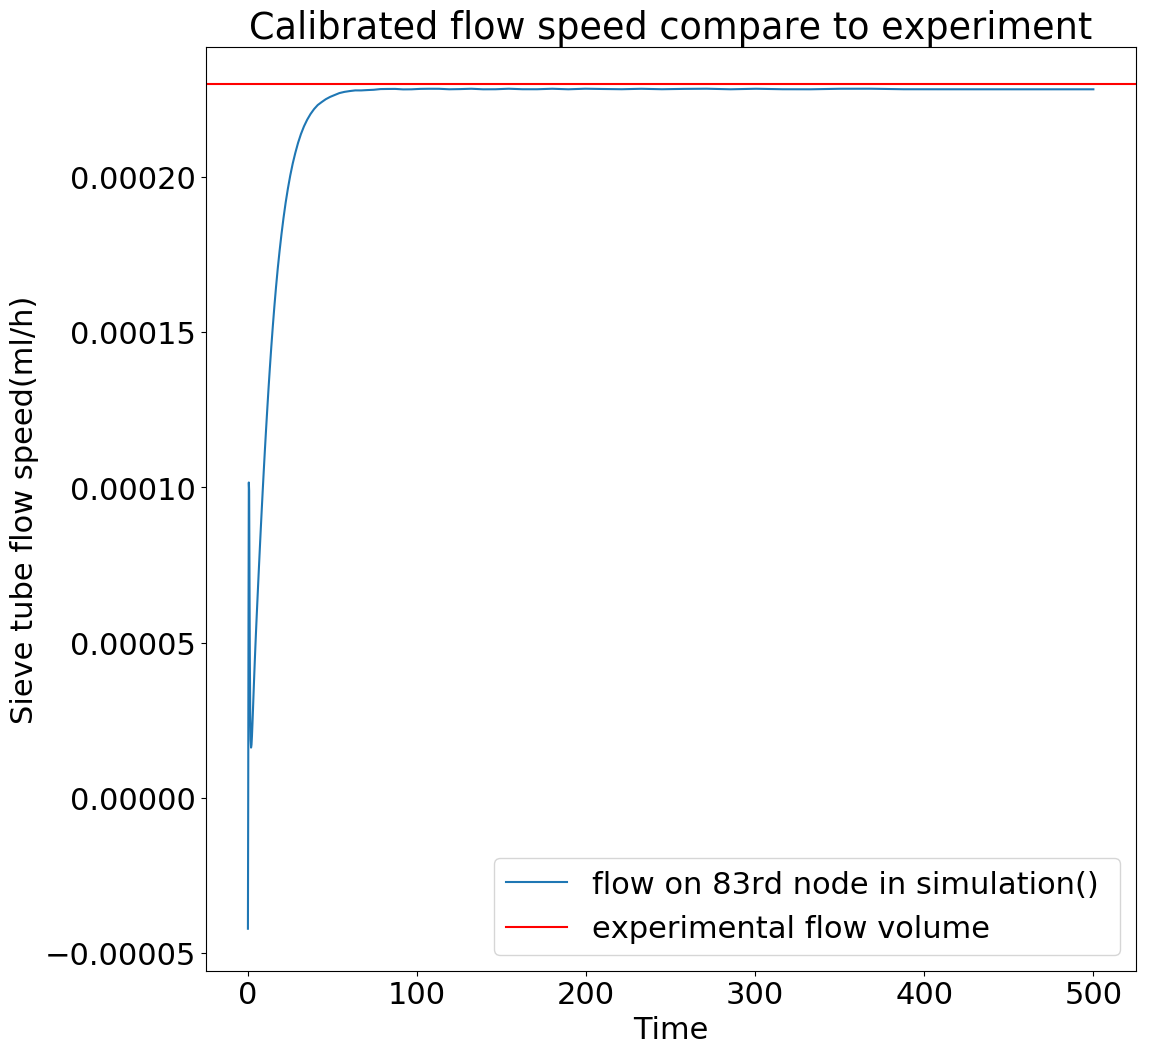

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: read_table is deprecated, use read_csv instead.


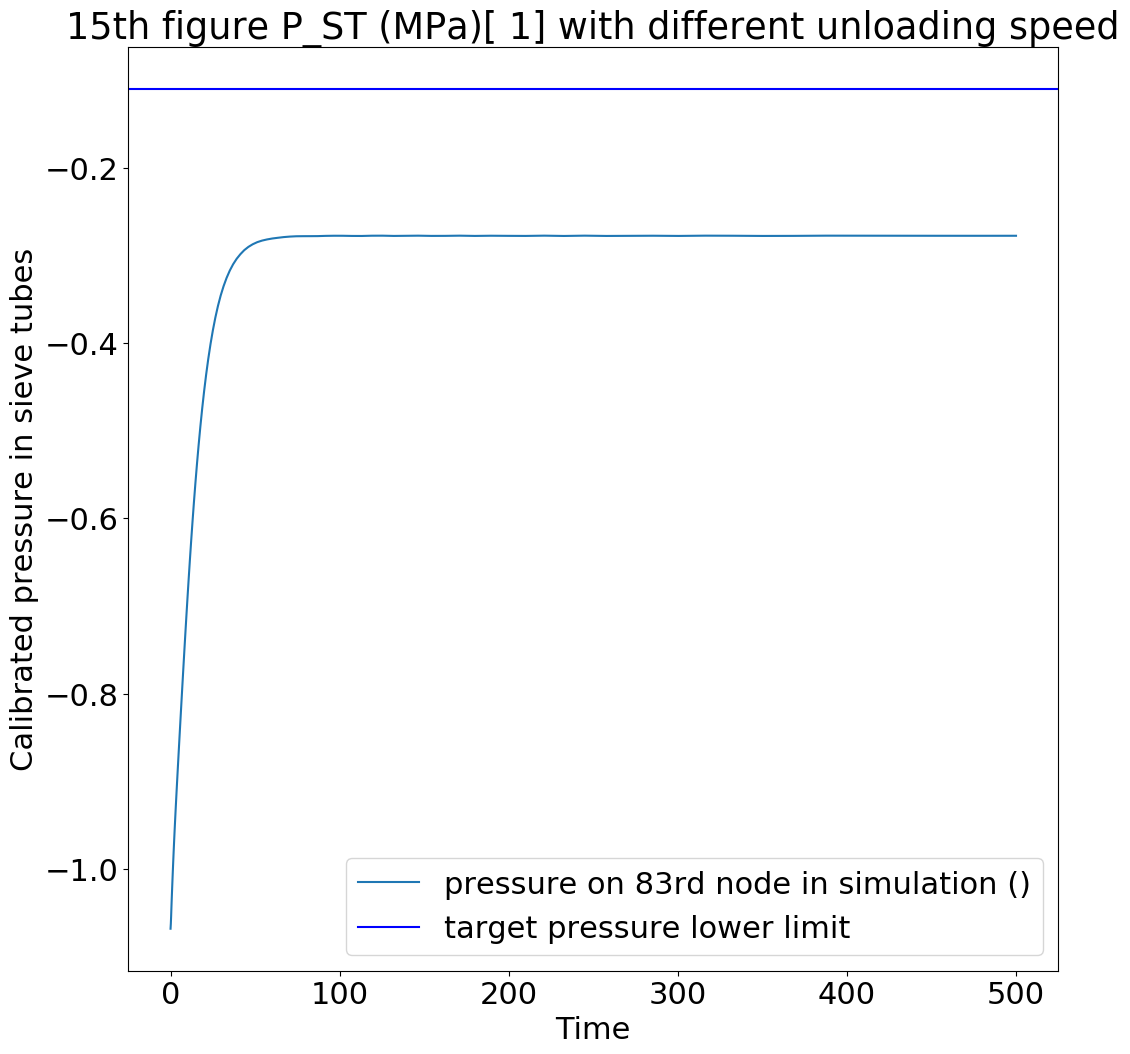

In [505]:
# leaf_mL
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = [12, 12]
from scipy.stats import loglaplace,chi2
f = plt.figure()


    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)

    #print(output.iloc[2, n_begin:n_end])

    for i in range(31,32):

        n_begin = (len(node_connection+1))*i+32 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)
        
        plt.xlabel("Time")
        plt.ylabel("Sieve tube flow speed(ml/h)")
        plt.title("Calibrated flow speed compare to experiment".format(i ,output.columns[n_begin]))

    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[83:84] for pt in y],label = '{}() '.format("flow on 83rd node in simulation"))
#plt.axhline(y=0.23, color='r', linestyle='-', label='all the volume')
plt.axhline(y=0.00023, color='r', linestyle='-', label='experimental flow volume')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
    #f.savefig("{}.pdf".format(s), bbox_inches='tight')
    
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    ### C_ST

    #print(output.iloc[2, n_begin:n_end])

    for i in range(15,16): #NO. of the output (15,16) is pressure

        n_begin = (len(node_connection+1))*i+16 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        time = np.array(output.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)

        plt.xlabel("Time")
        plt.ylabel("Calibrated pressure in sieve tubes".format(output.columns[n_begin]))
        plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))
#         plt.title("Calibrated pressure compare to experiment".format(i ,output.columns[n_begin]))
    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[83:84] for pt in y],label = '{} ()'.format("pressure on 83rd node in simulation")) #vMU_x[j]
plt.axhline(y=-0.6+(1.08-0.59), color='b', linestyle='-', label='target pressure lower limit')
# plt.axhline(y=-0.6+(1.3-0.59), color='g', linestyle='-', label='experimental pressure')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
    #f.savefig("{}.pdf".format(s), bbox_inches='tight')

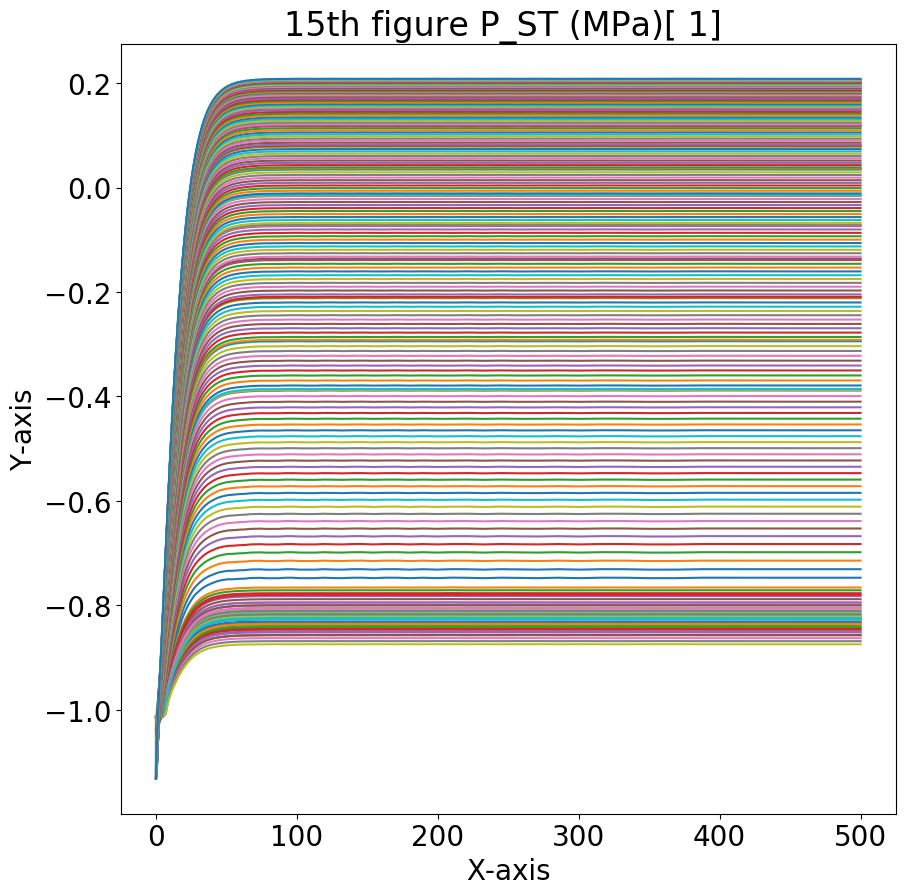

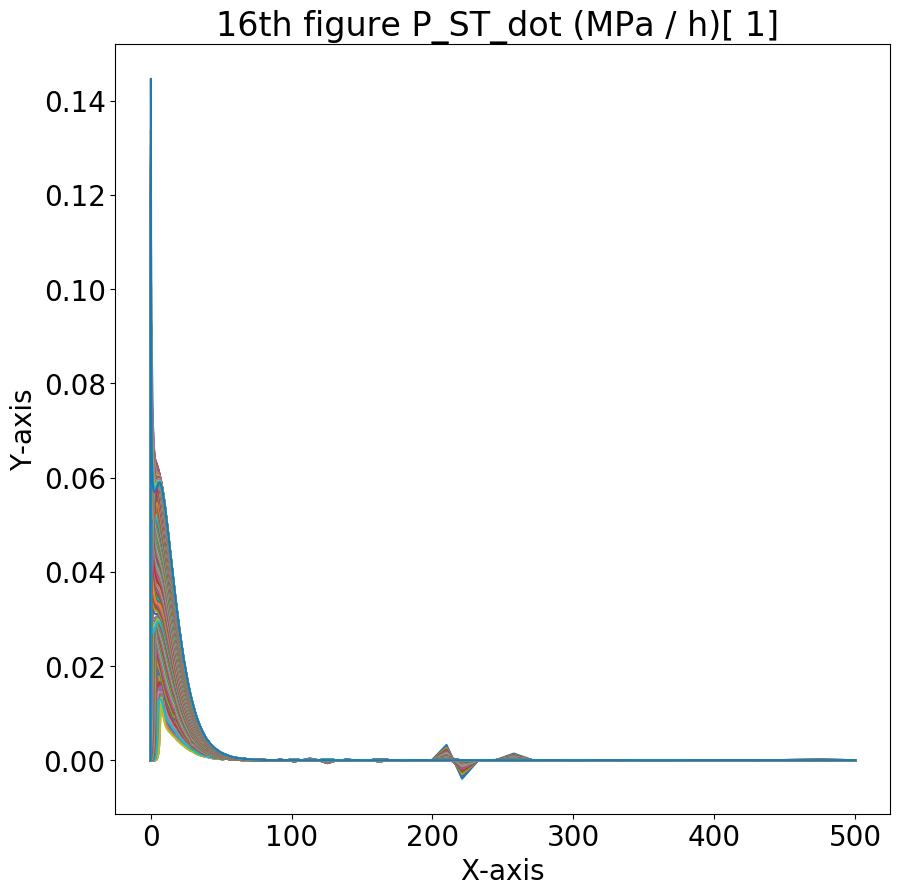

In [508]:

for i in range(15,17):
    n_begin = (len(node_connection)+1)*i+1
    n_end = n_begin +(len(node_connection))
    var_all = np.array(output.iloc[:,n_begin:n_end])
    x = np.array(time)
    y = np.array(var_all)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("{}th figure {} ".format(i ,output.columns[n_begin]))
    for i in range(len(np.transpose(y))):
        plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    #plt.legend()
    #labelLines(plt.gca().get_lines(), xvals=(49, 50), zorder=0)
    plt.show()

In [26]:
from ggplot import *
ggplot(dat, aes(mg_pressure_y,mg_pressure_m_y, colour = distance)) +\
    geom_point() +\
    geom_smooth(method=lm, se=FALSE)

#fit <- lm(measure_pressure ~simulated_pressure, data=dat)
#summary(fit)

AttributeError: module 'pandas' has no attribute 'tslib'

In [53]:
%%R
library("ggplot2")
ggplot(dat, aes(mg_pressure_y,mg_pressure_m_y, colour = distance)) +\
    geom_point() +\
    geom_smooth(method=lm, se=FALSE)


Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:2:69: unexpected input
1: withVisible({library("ggplot2")
2: ggplot(dat, aes(mg_pressure_y,mg_pressure_m_y, colour = distance)) +\
                                                                       ^


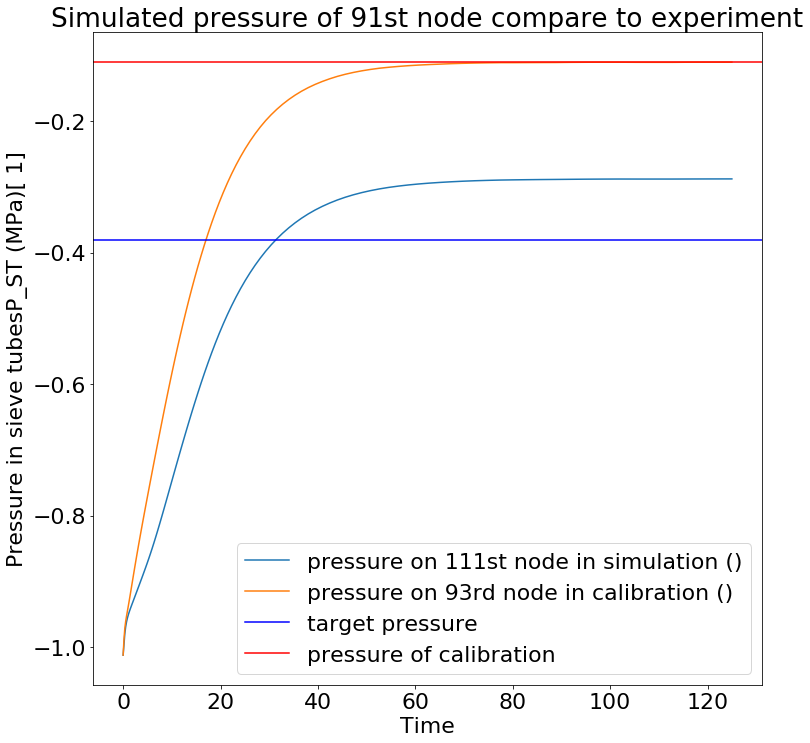

In [400]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = [12, 12]
from scipy.stats import loglaplace,chi2


piaf_munch_pr = "connection_231_vml_larger"
node_connection2 = np.full(231, 0)
    #from labellines import labelLine, labelLines
    
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    path2 = '{}{}_output.txt'.format(piaf_munch_pr, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    output2 = pd.read_table(path2,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])
    
    time2 = np.array(output2.iloc[:, 0])



    for i in range(15,16): #NO. of the output (15,16) is pressure

        n_begin = (len(node_connection))*i+16 # careful here is the number of connections but bot nodes
        n_begin2 = (len(node_connection2))*i+16 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        n_end2 = n_begin2 +(len(node_connection2)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        var_all2 = np.array(output2.iloc[:,n_begin2:n_end2])
        time = np.array(output.iloc[:, 0])
        time2 = np.array(output2.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)
        x2 = np.array(time2)
        y2 = np.array(var_all2)
        
        plt.xlabel("Time")
        plt.ylabel("Pressure in sieve tubes{}".format(output.columns[n_begin]))
#         plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))
        plt.title("Simulated pressure of 91st node compare to experiment".format(i ,output.columns[n_begin]))
    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[110:111] for pt in y],label = '{} ()'.format("pressure on 111st node in simulation")) #vMU_x[j]
    plt.plot(x2,[pt[93:94] for pt in y2],label = '{} ()'.format("pressure on 93rd node in calibration")) #vMU_x[j]
plt.axhline(y=-0.6+(0.81-0.59), color='b', linestyle='-', label='target pressure')
plt.axhline(y=-0.6+(1.08-0.59), color='r', linestyle='-', label='pressure of calibration')
# plt.axhline(y=-0.6+(2.5-0.59), color='g', linestyle='-', label='target pressure upper limit')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
f.savefig("{}3.5meter_d_compare_to_7m.pdf".format(s), bbox_inches='tight')

In [232]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = [12, 12]
from scipy.stats import loglaplace,chi2


piaf_munch_pr = "connection_231_vml_larger"
node_connection2 = np.full(231, 0)
    #from labellines import labelLine, labelLines
    
f = plt.figure()
    #from labellines import labelLine, labelLines
for j in range(0,1):
    
    path = '{}{}_output.txt'.format(piaf_munch_p_name, j)
    path2 = '{}{}_output.txt'.format(piaf_munch_pr, j)
    #pd.read_table(path,sep='\t')
    output = pd.read_table(path,sep='\t',header=1)
    output2 = pd.read_table(path2,sep='\t',header=1)
    ### C_ST
    time = np.array(output.iloc[:, 0])
    n_begin = (len(node_connection)+1)*3+1
    n_end = n_begin +(len(node_connection))
    #print(output.iloc[2, n_begin:n_end])
    
    time2 = np.array(output2.iloc[:, 0])



    for i in range(15,16): #NO. of the output (15,16) is pressure

        n_begin = (len(node_connection))*i+16 # careful here is the number of connections but bot nodes
        n_begin2 = (len(node_connection2))*i+16 # careful here is the number of connections but bot nodes
        n_end = n_begin +(len(node_connection)-1)
        n_end2 = n_begin2 +(len(node_connection2)-1)
        var_all = np.array(output.iloc[:,n_begin:n_end])
        var_all2 = np.array(output2.iloc[:,n_begin2:n_end2])
        time = np.array(output.iloc[:, 0])
        time2 = np.array(output2.iloc[:, 0])

        x = np.array(time)
        y = np.array(var_all)
        x2 = np.array(time2)
        y2 = np.array(var_all2)
        
        plt.xlabel("Time")
        plt.ylabel("Pressure in sieve tubes{}".format(output.columns[n_begin]))
#         plt.title("{}th figure {} with different unloading speed".format(i ,output.columns[n_begin]))
        plt.title("Simulated pressure of 91st node compare to experiment".format(i ,output.columns[n_begin]))
    #     for i in range(len(np.transpose(y))):
    #         plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    plt.plot(x,[pt[91:92] for pt in y],label = '{} ()'.format("pressure on 91st node in simulation")) #vMU_x[j]
    plt.plot(x2,[pt[93:94] for pt in y2],label = '{} ()'.format("pressure on 93rd node in calibration")) #vMU_x[j]
plt.axhline(y=-0.6+(0.76-0.59), color='b', linestyle='-', label='target pressure')
plt.axhline(y=-0.6+(1.08-0.59), color='r', linestyle='-', label='pressure of calibration')
# plt.axhline(y=-0.6+(2.5-0.59), color='g', linestyle='-', label='target pressure upper limit')
plt.legend()
#     labelLines(plt.gca().get_lines(), xvals=(0, 5), zorder=0)
plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
    #f.savefig("{}.pdf".format(s), bbox_inches='tight')

'P_ST (MPa)[ 1]'

In [87]:
def get_pressure_of_each_structure(name , node_no=93, time_point=81):
    for j in range(0,1):
        total_nodes = name[-3:]
        total_nodes_int= int(total_nodes)
        path = 'realxylem{}{}_output.txt'.format(name, j)
        output = pd.read_table(path,sep='\t',header=1)
        for i in range(15,16): #NO. of the output (15,16) is pressure
            
            n_begin = (total_nodes_int+1)*i +1# careful here is the number of connections but bot nodes
            values= output.iloc[time_point:time_point+1,n_begin+node_no:n_begin+node_no+1]
        return values;    
    return values;

#all_plant_p_name = ["morning_glory_2.5m_dconnection_184", "morning_glory_3.5m_dconnection_204", "morning_glory_9m_dconnection_313", "morning_glory_10m_dconnection_333", "morning_glory_14m_dconnection_403"]
all_plant_p_name = ["morning_glory_2.5m_dconnection_179", "morning_glory_3.5m_dconnection_204", "morning_glory_9m_dconnection_308", "morning_glory_10m_dconnection_328", "morning_glory_14m_dconnection_403"]

all_plant_time_point = [100, 100, 100, 100, 100]
all_plant_total_n= [184, 204, 313, 333, 403]
all_plant_length= [2.5, 3.5, 9, 10, 14]
all_plant_node= [92, 113, 222, 242, 322]
all_pressure = np.zeros(5)
all_p_up = [0.76, 0.81, 2.5, 1.7, 2.3]#upper limit of the pressure measured
all_p_up[:] = [x - 1.19 for x in all_p_up]

all_p_low = [0.76, 0.68, 1.3, 1.7, 2.25] #lower limit of the pressure measured
all_p_low[:] = [x - 1.19 for x in all_p_low]
for i in range(0,5):
    pressure_here = get_pressure_of_each_structure(name = all_plant_p_name[i] , node_no=all_plant_node[i], time_point=all_plant_time_point[i]).values[0][0]
    all_pressure[i]= pressure_here
print(all_pressure)


/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead.
  


[-0.47902  -0.366085  0.392098  0.571033  1.44078 ]


In [88]:
all_plant_time_point = [100, 100, 100, 100, 100]
i=4
get_pressure_of_each_structure(name = all_plant_p_name[i] , node_no=all_plant_node[i], time_point=all_plant_time_point[i])


all_p_measure = np.zeros(5)
all_p_error = np.zeros(5)
all_p_measure[:] = [(all_p_up[i]+all_p_low[i])/2 for i in range(0,5)]
all_p_error[:] = [(all_p_up[i]-all_p_low[i])/2 for i in range(0,5)]

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead.
  


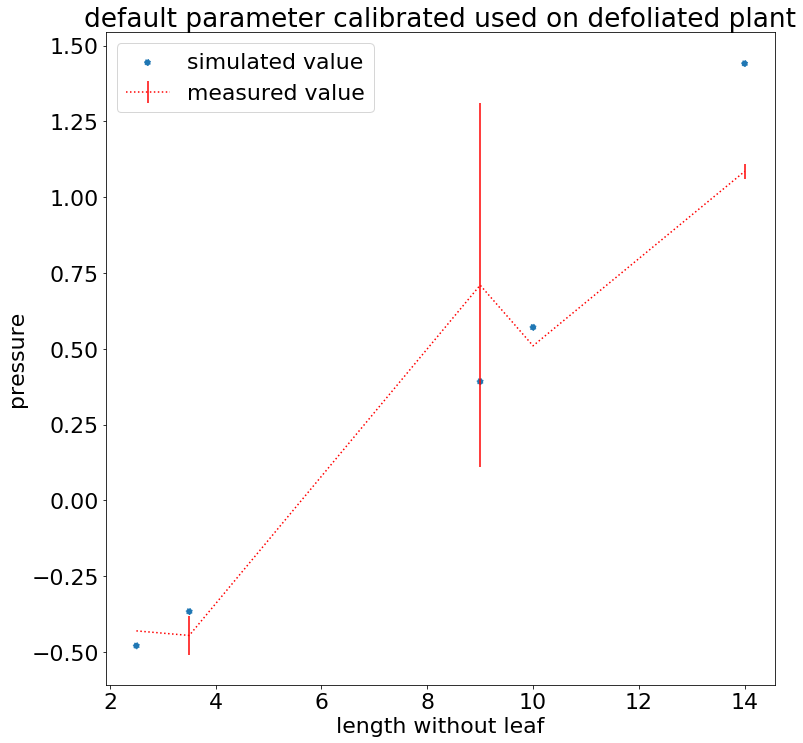

In [89]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = [12, 12]
pressure_fig = plt.figure(0)





x = all_plant_length
y = all_pressure
plt.scatter(x, y,  label= "simulated value" ,linestyle='dotted')
plt.title("default parameter calibrated used on defoliated plant")
#plt.errorbar(x,y, yuplims= all_p_up, ylolims= all_p_low, label= "measured value")
plt.errorbar(x, all_p_measure ,yerr=all_p_error, label= "measured value", c= "r",linestyle='dotted')
plt.xlabel("length without leaf")
plt.ylabel("pressure")
plt.legend()
plt.show()

In [115]:
all_pressure
all_p_measure

array([-0.43 , -0.445,  0.71 ,  0.51 ,  1.085])

r square = 0.9069677180621456
p value = 0.012397084284523097
std_err = 0.1562414822817455


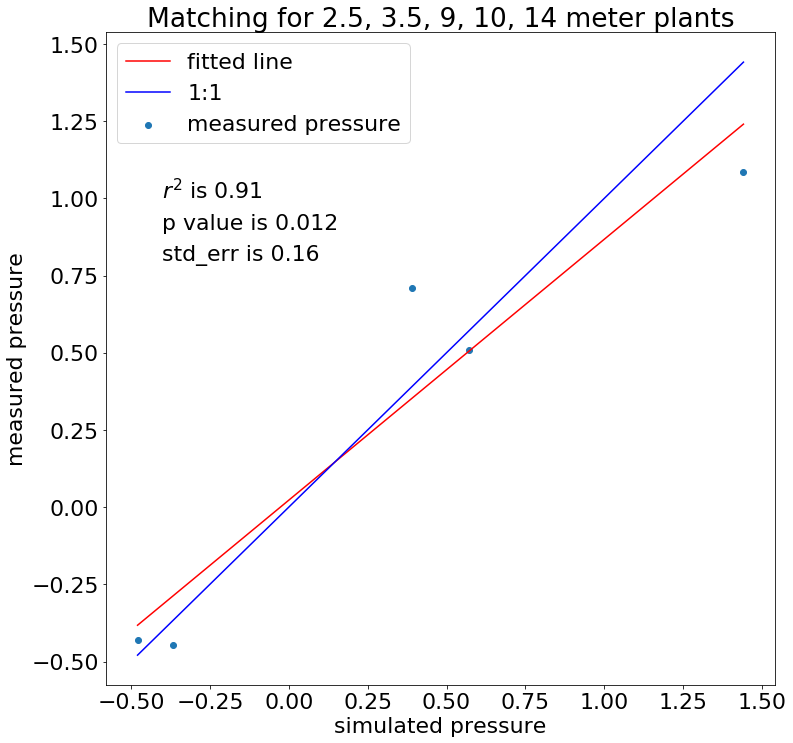

In [92]:
f = plt.figure(0)
plt.title("Matching for 2.5, 3.5, 9, 10, 14 meter plants")
plt.scatter(x=all_pressure, y= all_p_measure,  label = "measured pressure")
plt.xlabel("simulated pressure")
plt.ylabel("measured pressure")
slopeP, interceptP, r_valueP, p_valueP, std_errP = stats.linregress(all_pressure,all_p_measure)
#mg_x = np.asarray(mg_pressure_y, dtype=np.float32)
print("r square = {}".format(r_valueP**2))
print("p value = {}".format(p_valueP))
print("std_err = {}".format(std_errP))

plt.text( -0.4,1.0 , "$r^2$ is {:.02}".format(r_valueP**2), fontsize=22)
plt.text( -0.4,0.9 , "p value is {:.02}".format(p_valueP), fontsize=22)
plt.text( -0.4,0.8 , "std_err is {:.02}".format(std_errP), fontsize=22)
plt.plot(all_pressure, interceptP + slopeP*all_pressure, 'r', label='fitted line')
plt.plot(all_pressure, all_pressure, 'b', label='1:1')
plt.legend()
plt.show()
#mean square error

r$^2$ = 0.9069677180621456
p Value = 0.012397084284523097
SE = 0.19847968793608028


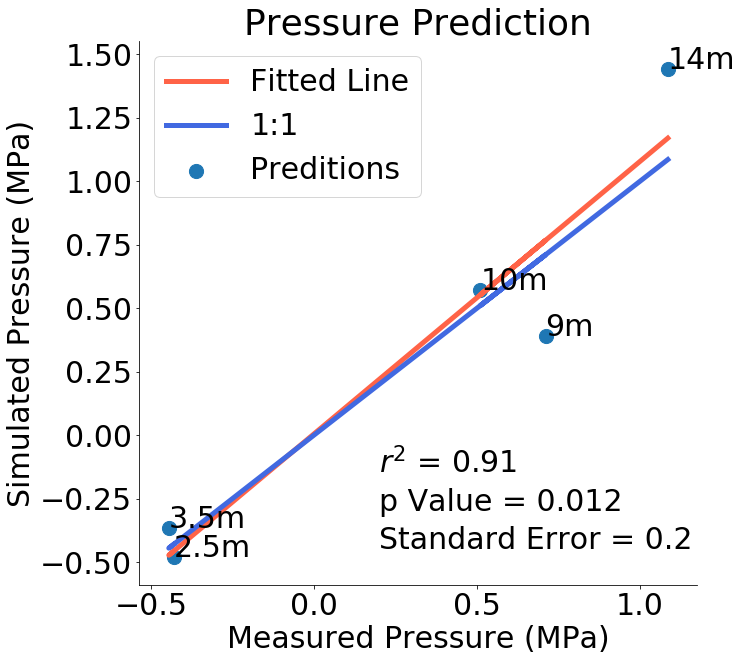

In [103]:
x = all_p_measure
y= all_pressure
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = [10, 10]
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Pressure Prediction")
ax.scatter(x=x, y= y,  label = "Preditions", s=200)
plt.xlabel("Measured Pressure (MPa)")
plt.ylabel("Simulated Pressure (MPa)")
slopeP, interceptP, r_valueP, p_valueP, std_errP = stats.linregress(x,y)
mg_x = np.asarray(x, dtype=np.float32)
print("r$^2$ = {}".format(r_valueP**2))
print("p Value = {}".format(p_valueP))
print("SE = {}".format(std_errP))

annotation_text=['2.5m','3.5m','9m','10m','14m']
for i, txt in enumerate(annotation_text):
    ax.annotate(txt, (x[i], y[i]))
plt.text( 0.2,-0.15 , "$r^2$ = {:.02}".format(r_valueP**2), fontsize=30)
plt.text( 0.2,-0.3 , "p Value = {:.02}".format(p_valueP), fontsize=30)
plt.text( 0.2,-0.45 , "Standard Error = {:.02}".format(std_errP), fontsize=30)
ax.plot(x, interceptP + slopeP*x, 'tomato', label='Fitted Line', linewidth =5,ls="-")
ax.plot(x, x, 'royalblue', label='1:1', linewidth =5)
plt.legend()
plt.show()

In [206]:
from sklearn.metrics import r2_score

r2_score(x,y)

#r2_score(y,x)

0.8889903384698516

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: read_table is deprecated, use read_csv instead.
  del sys.path[0]


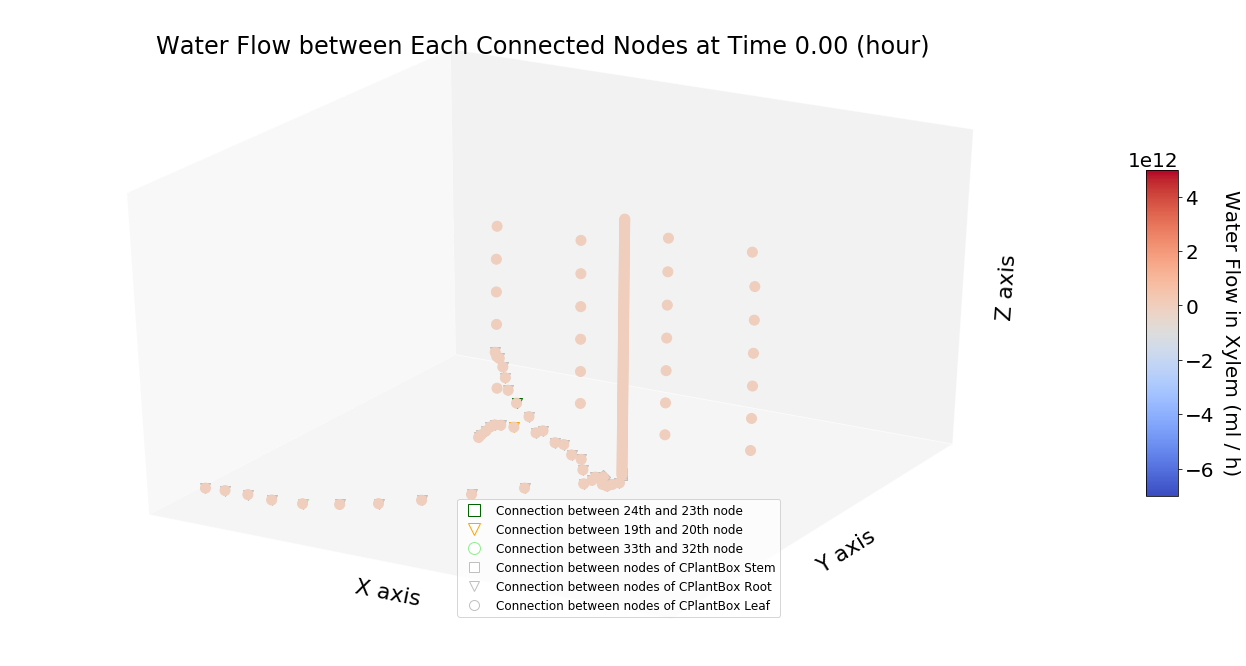

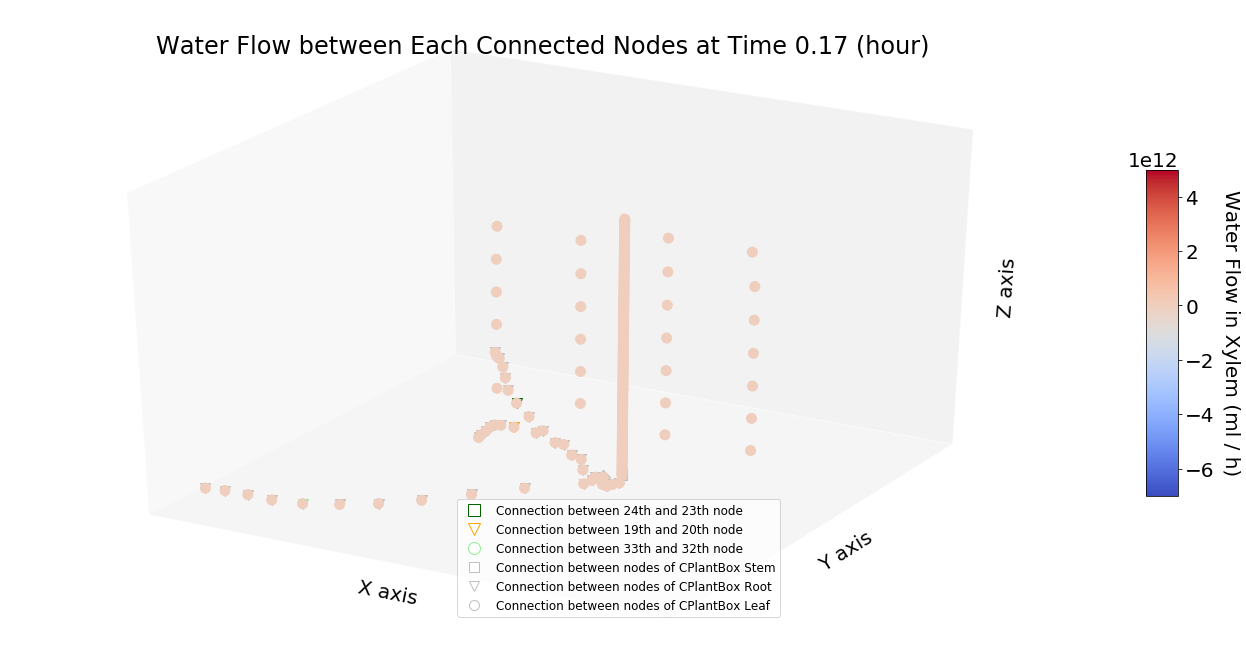

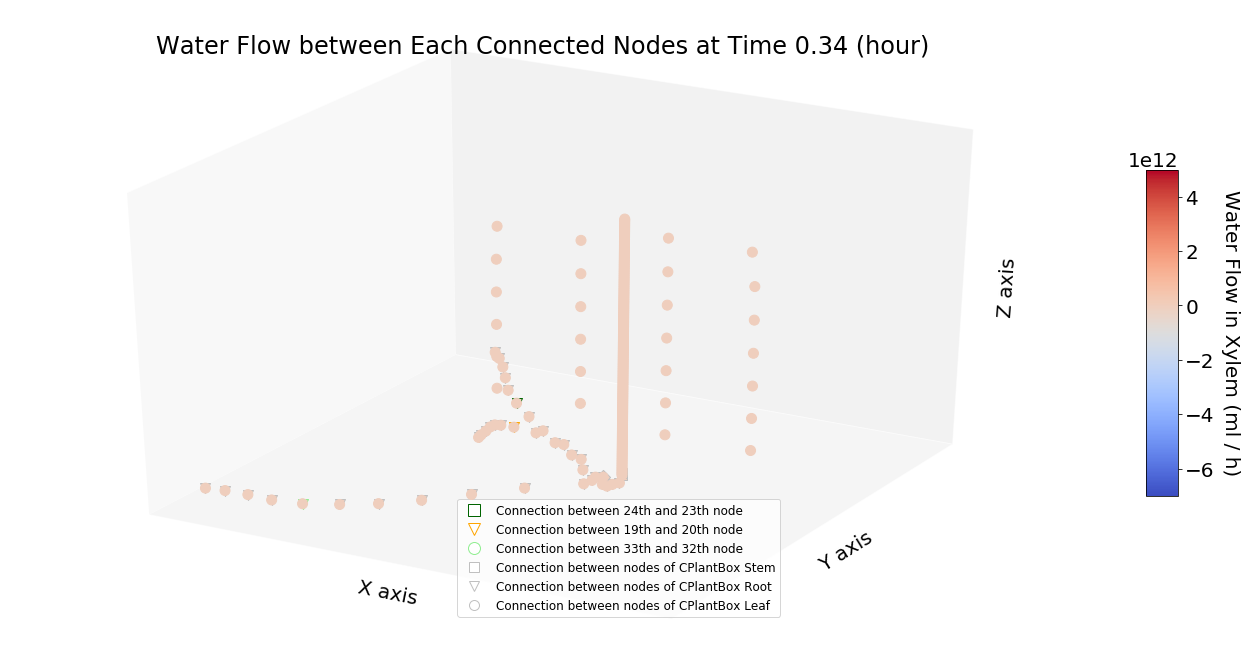

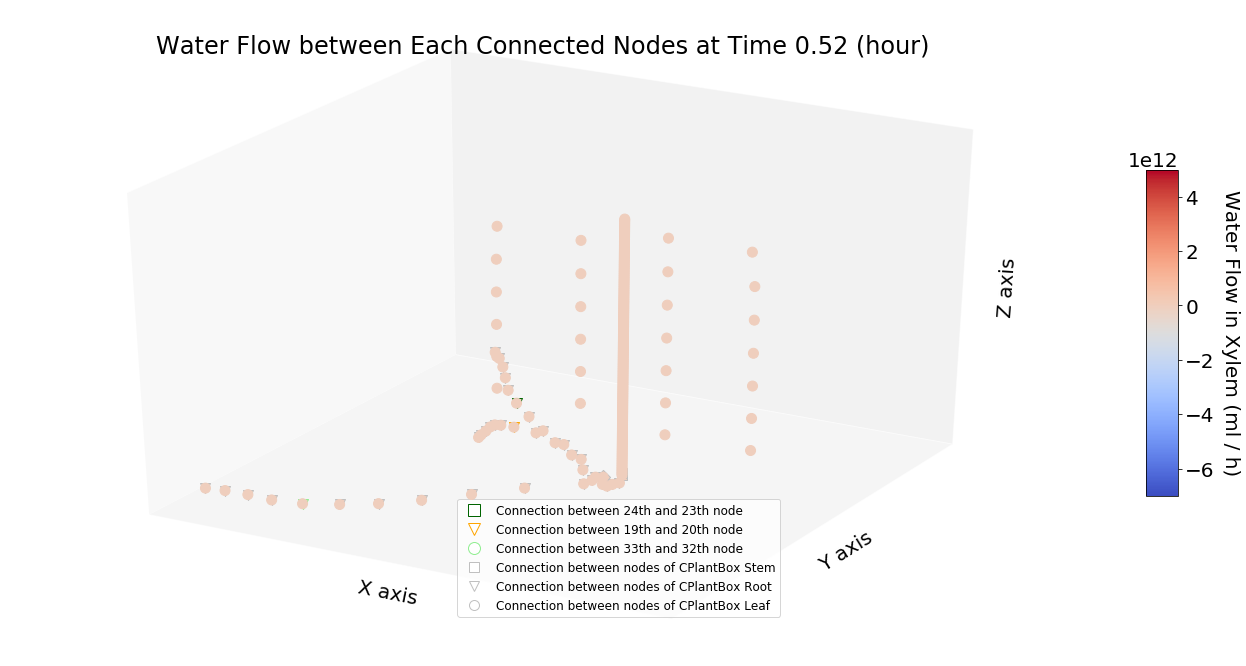

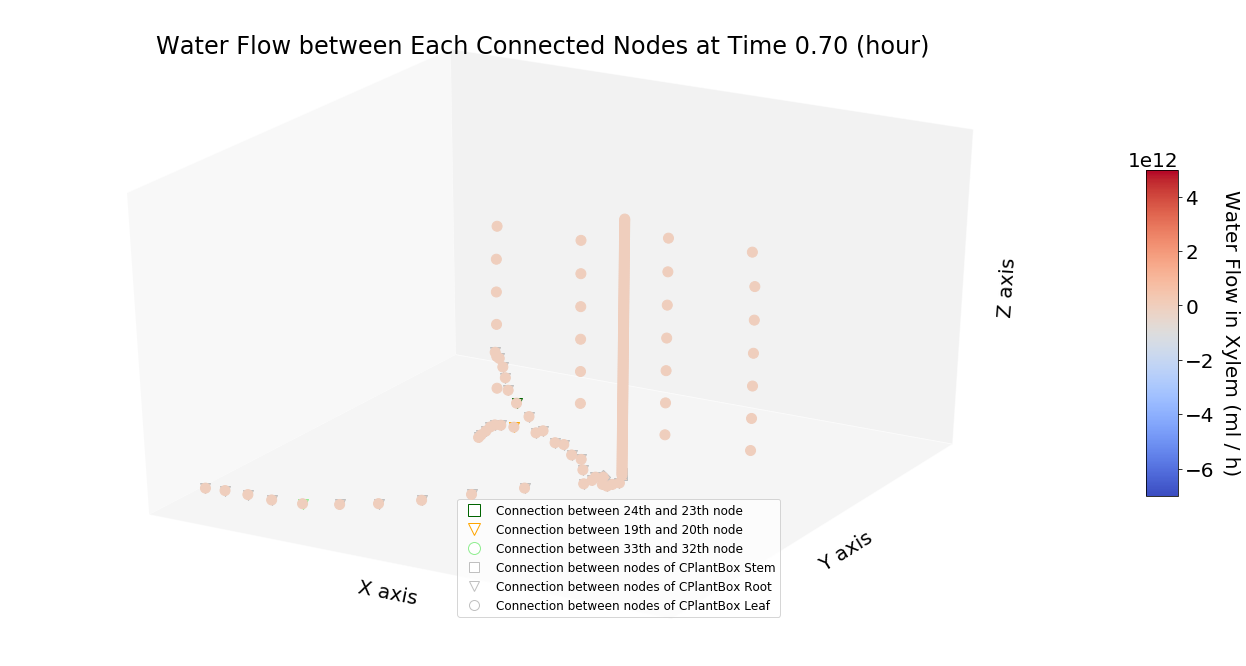

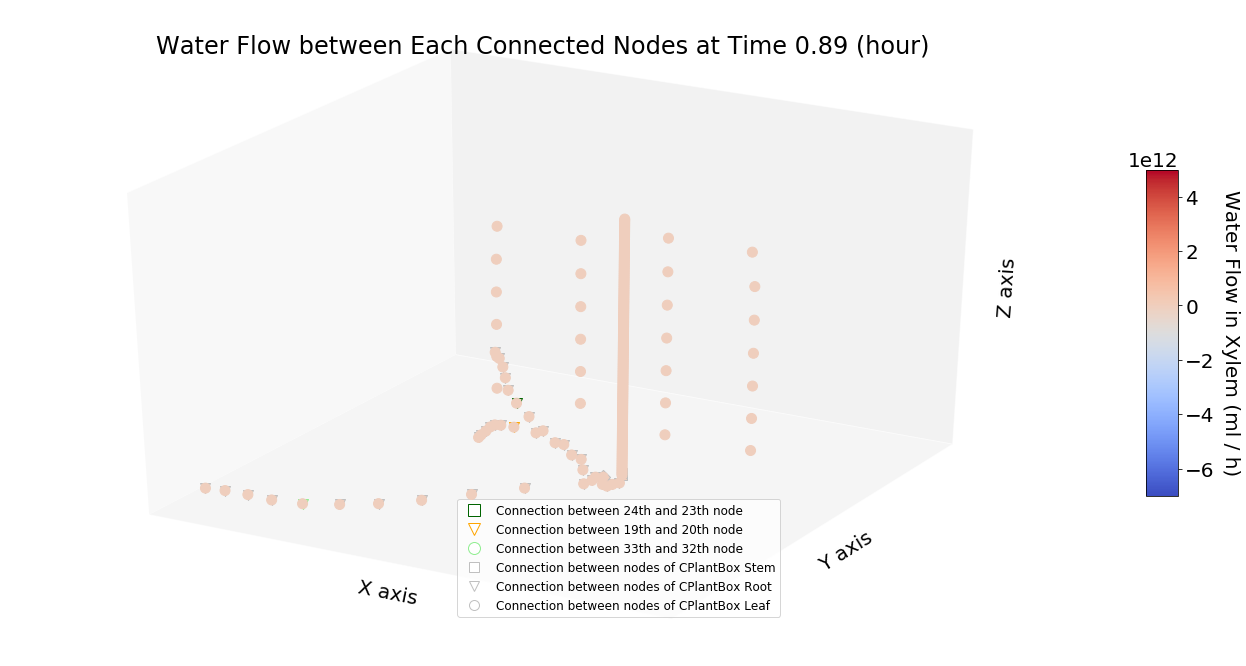

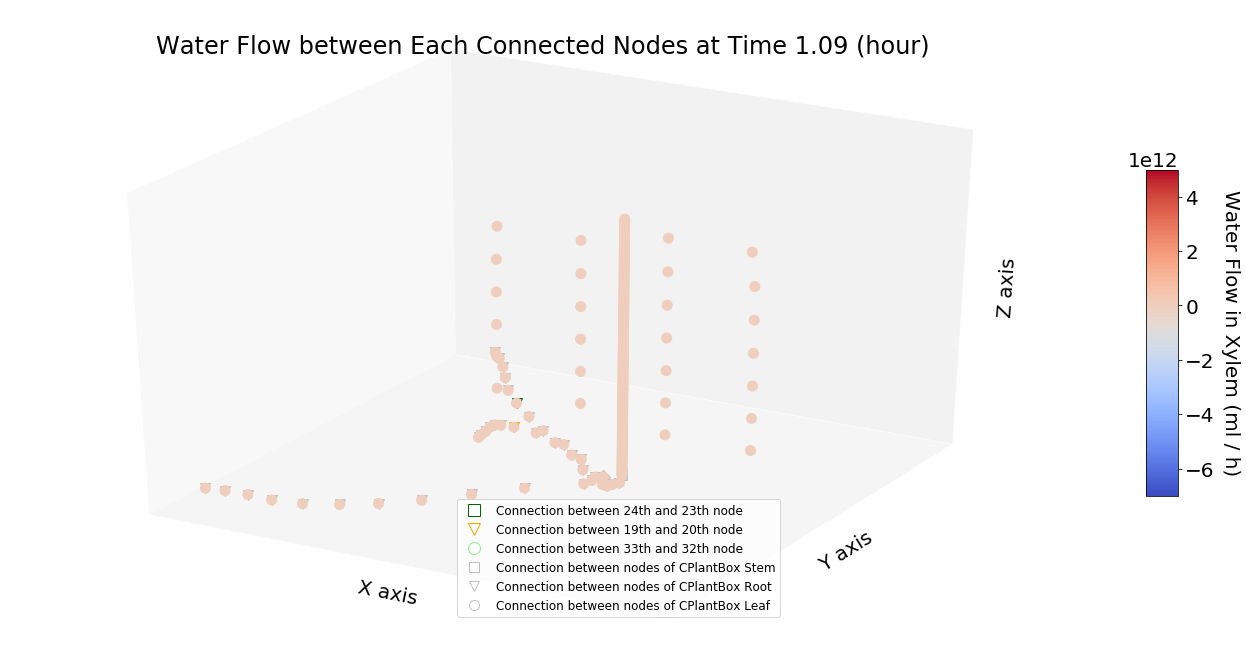

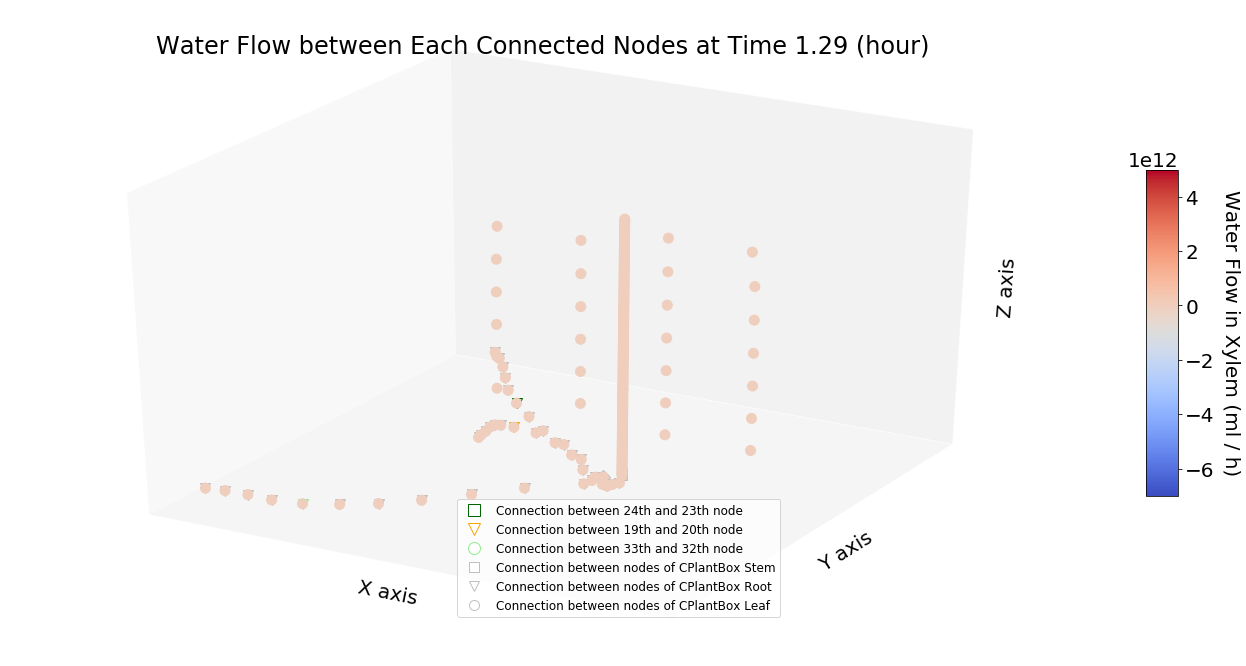

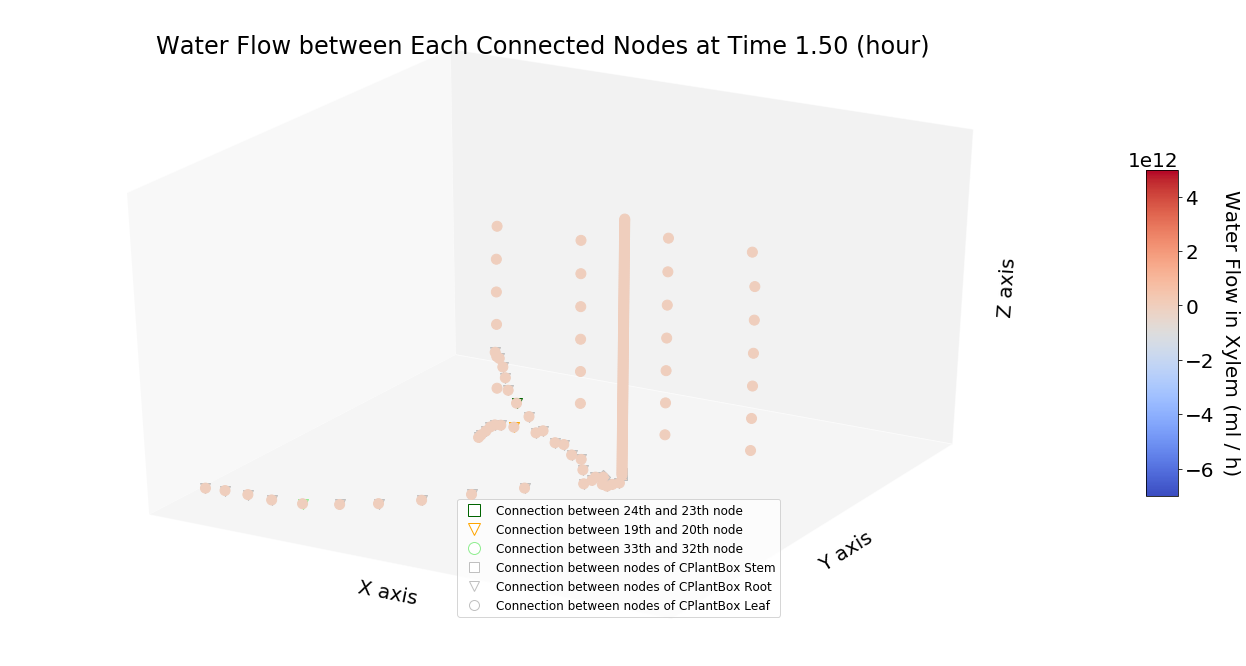

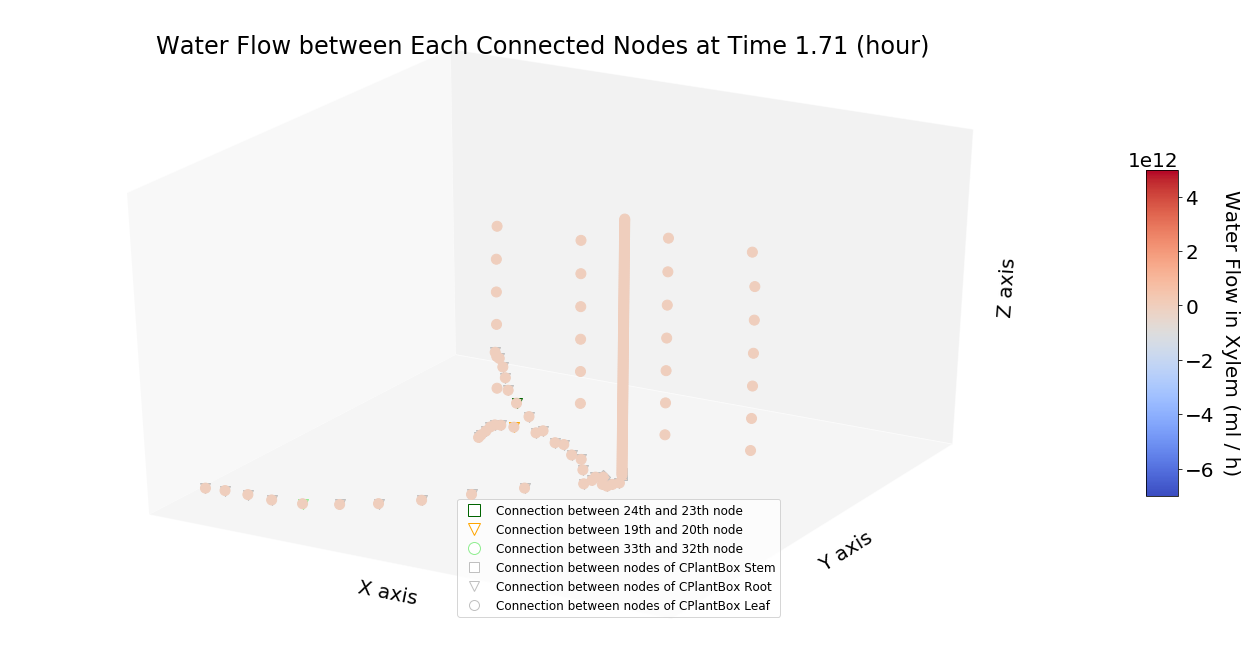

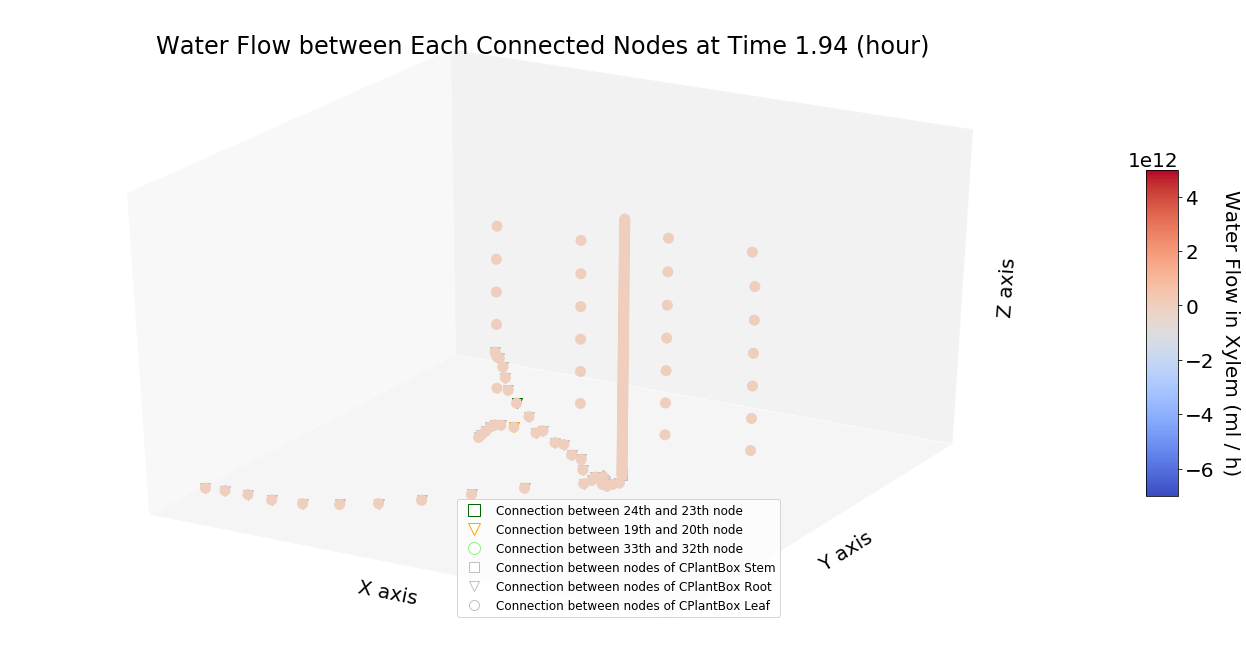

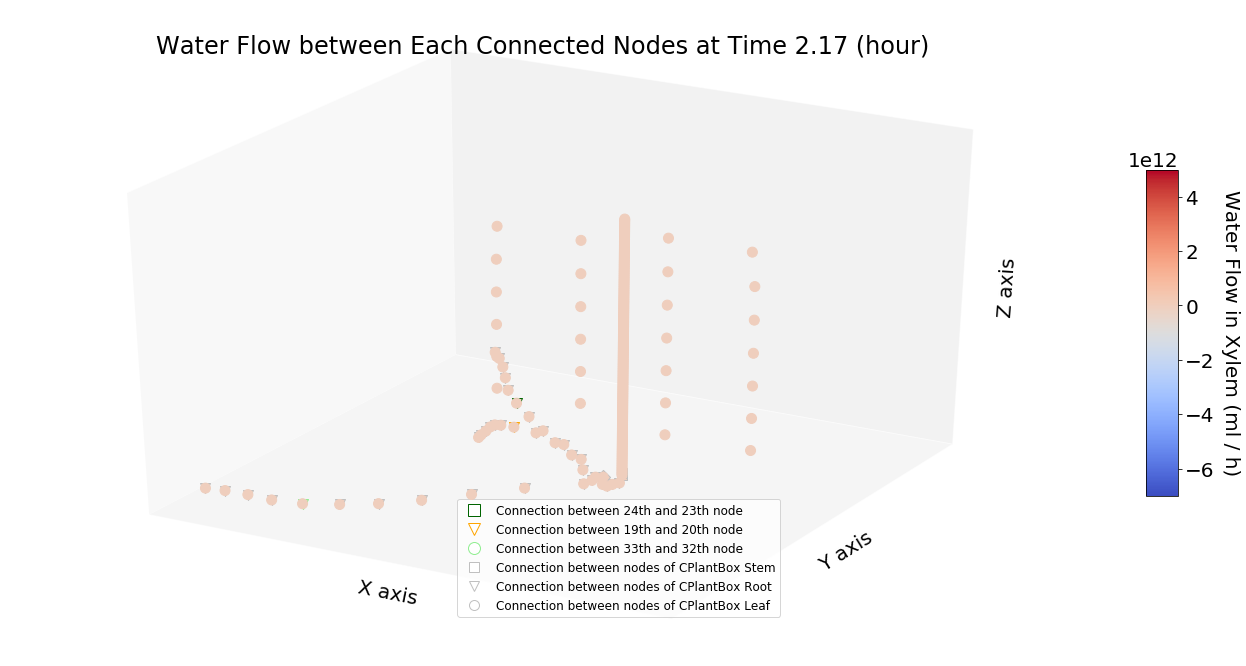

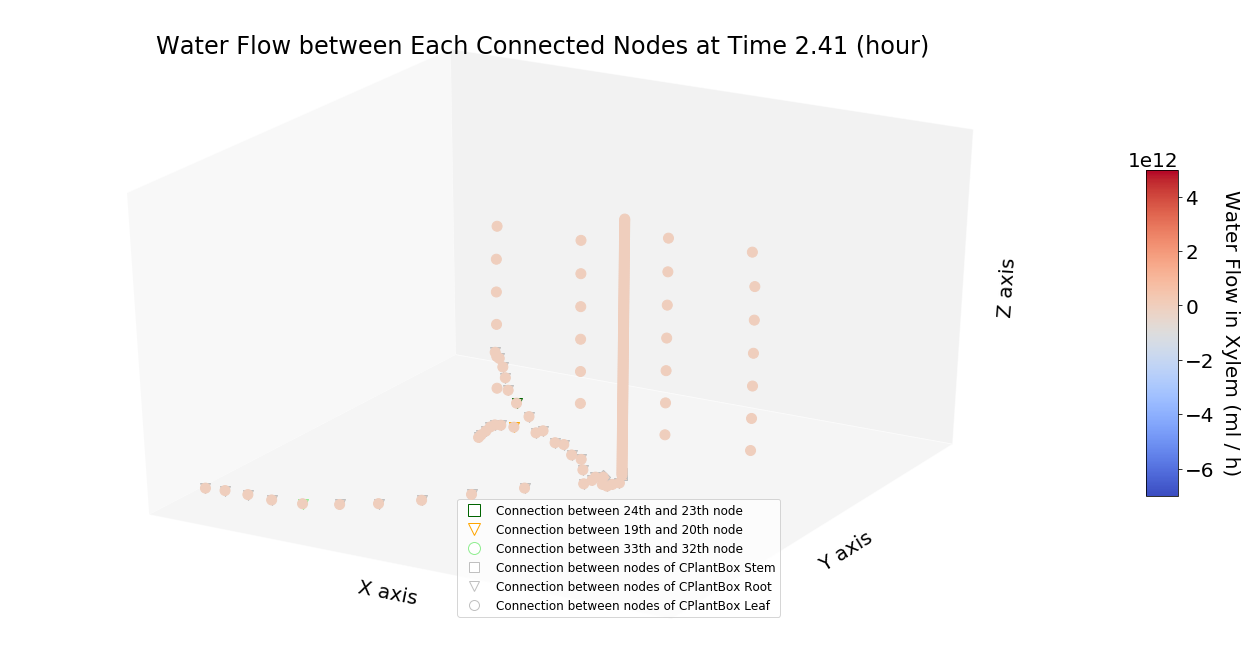

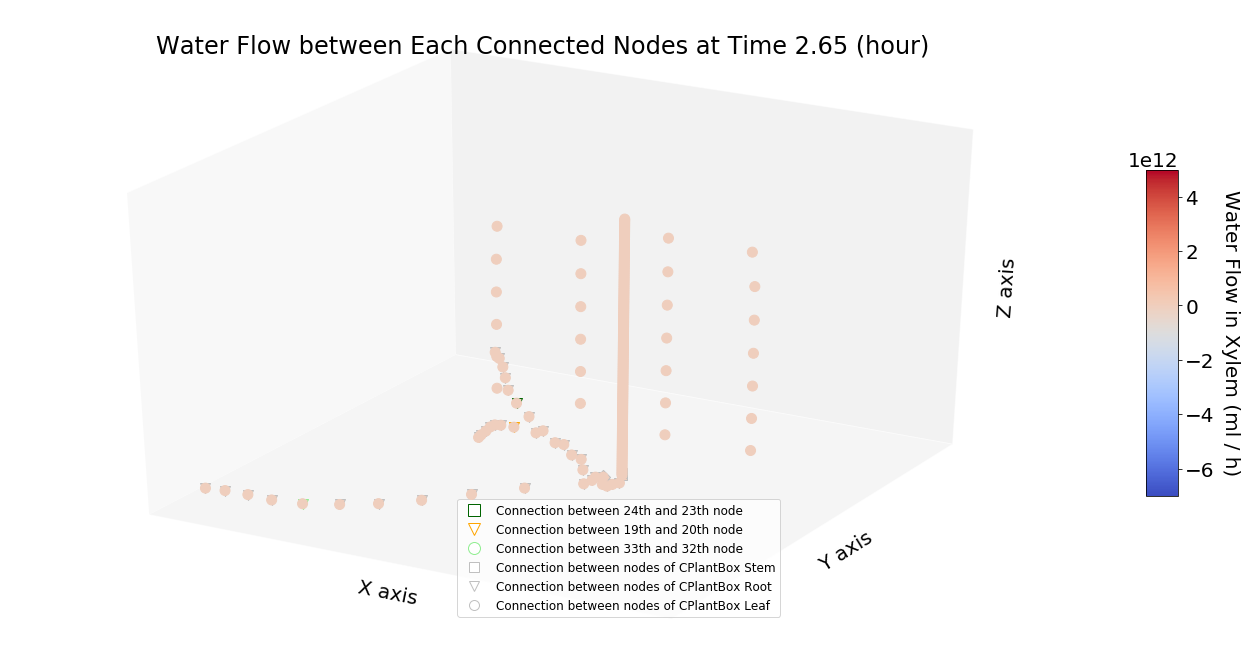

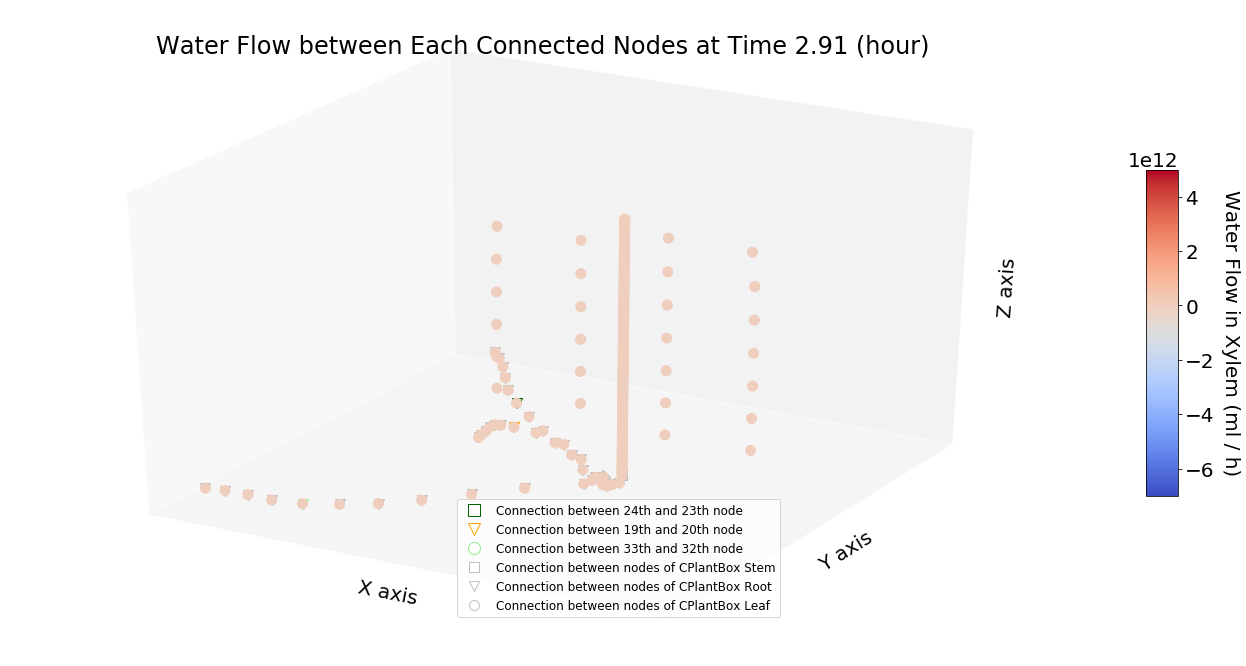

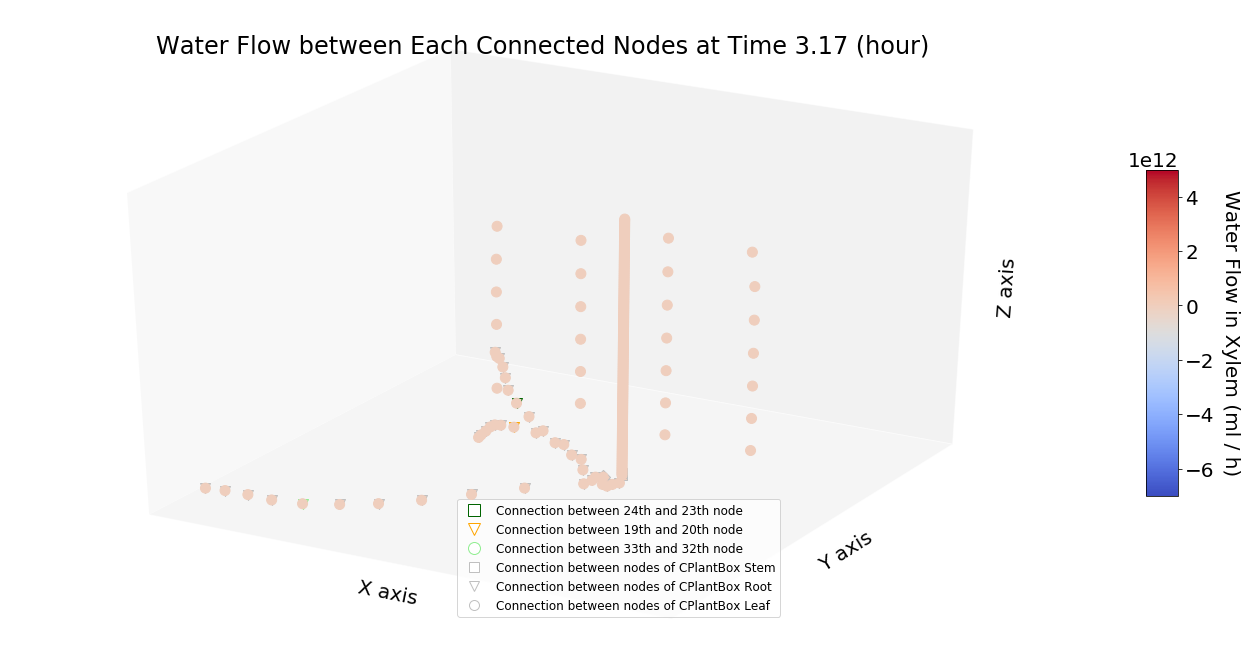

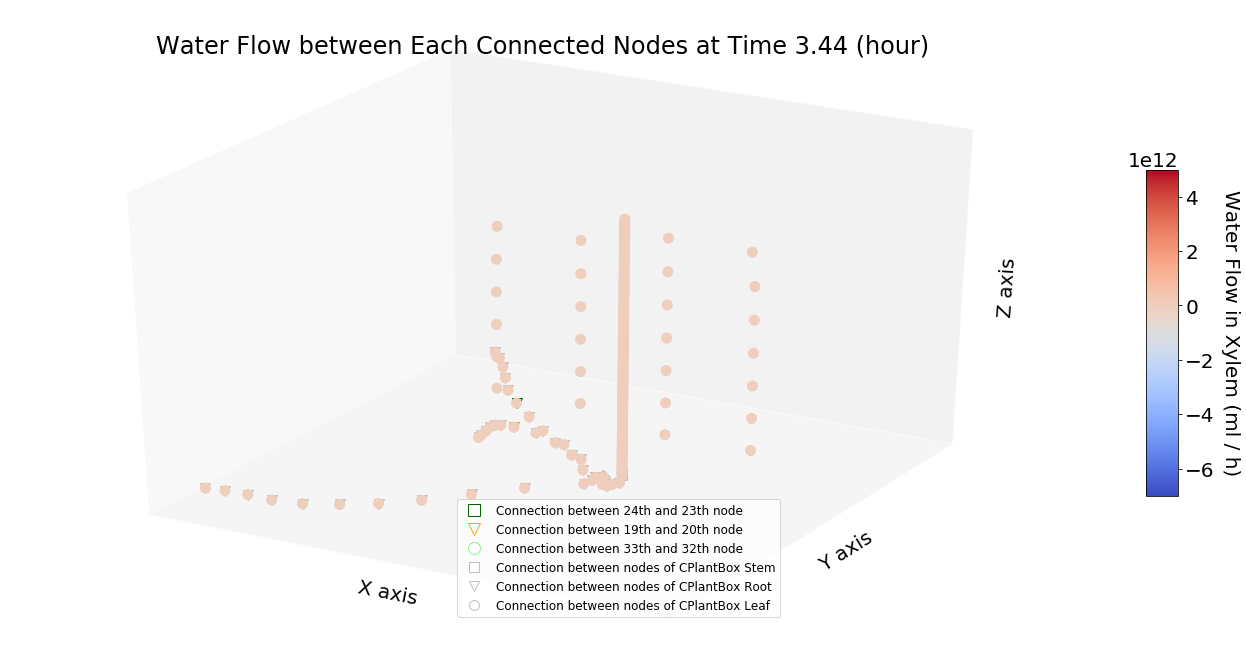

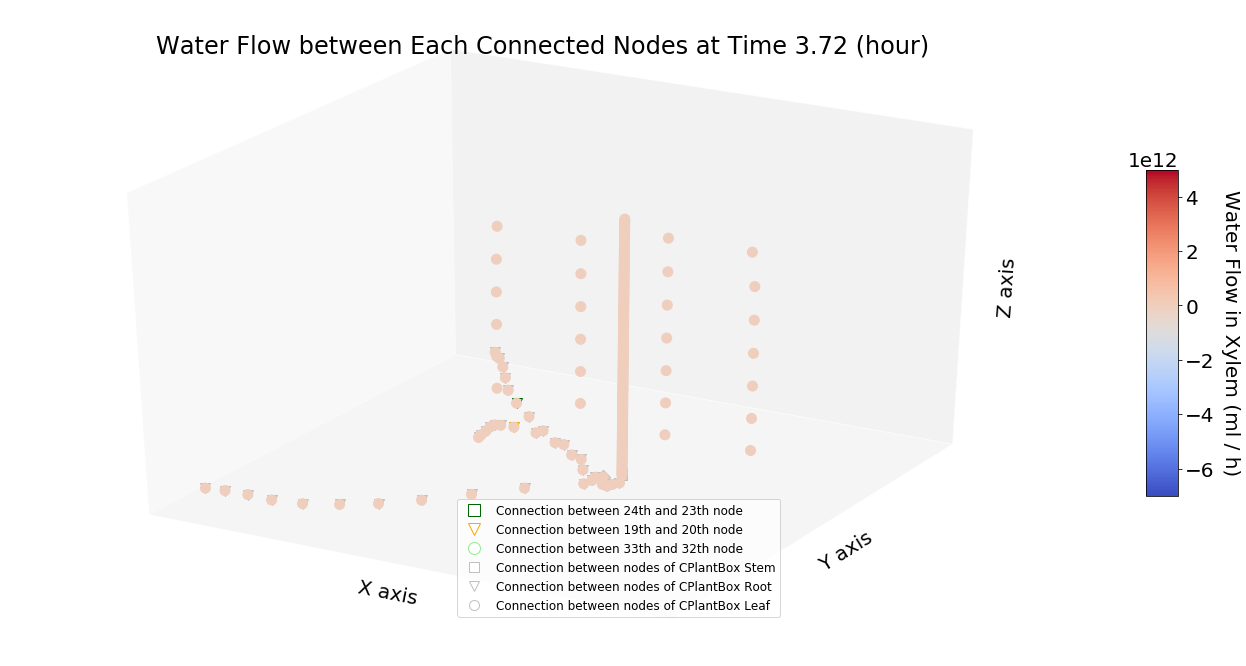

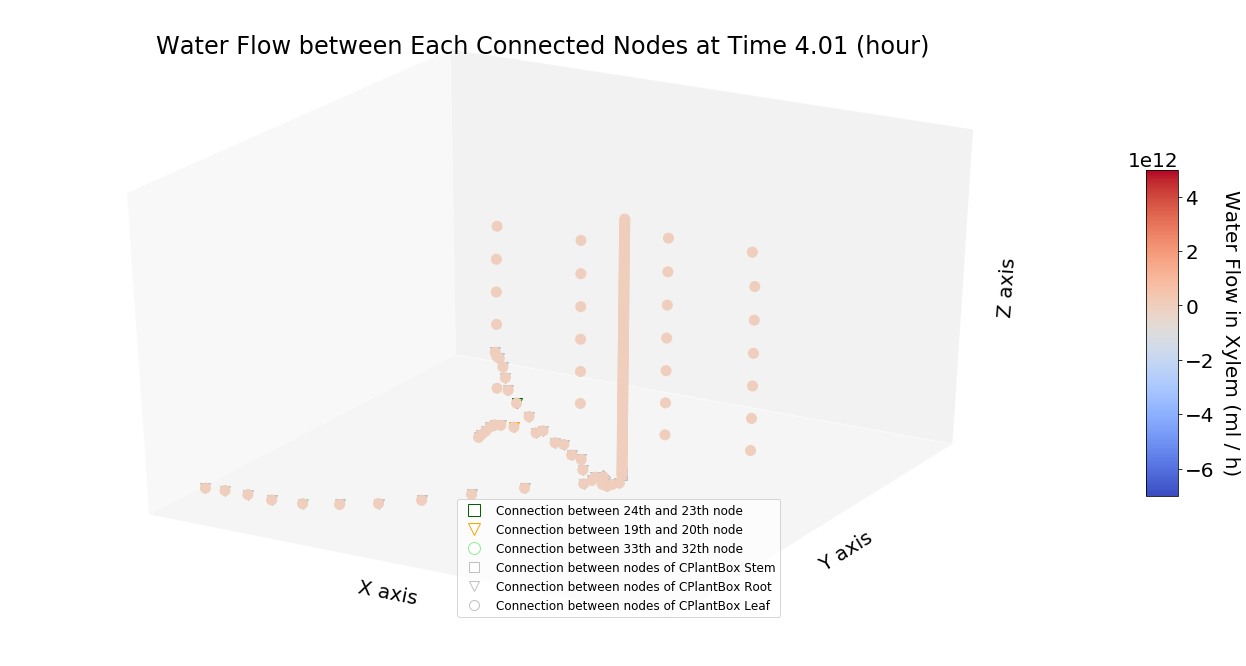

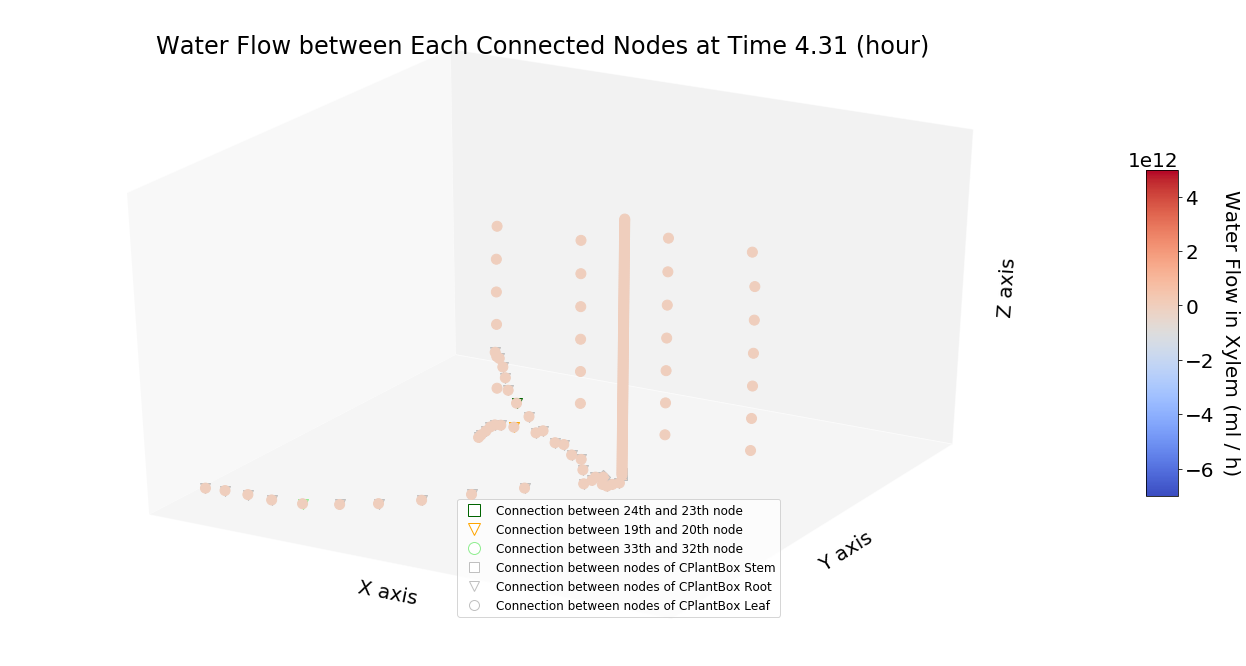

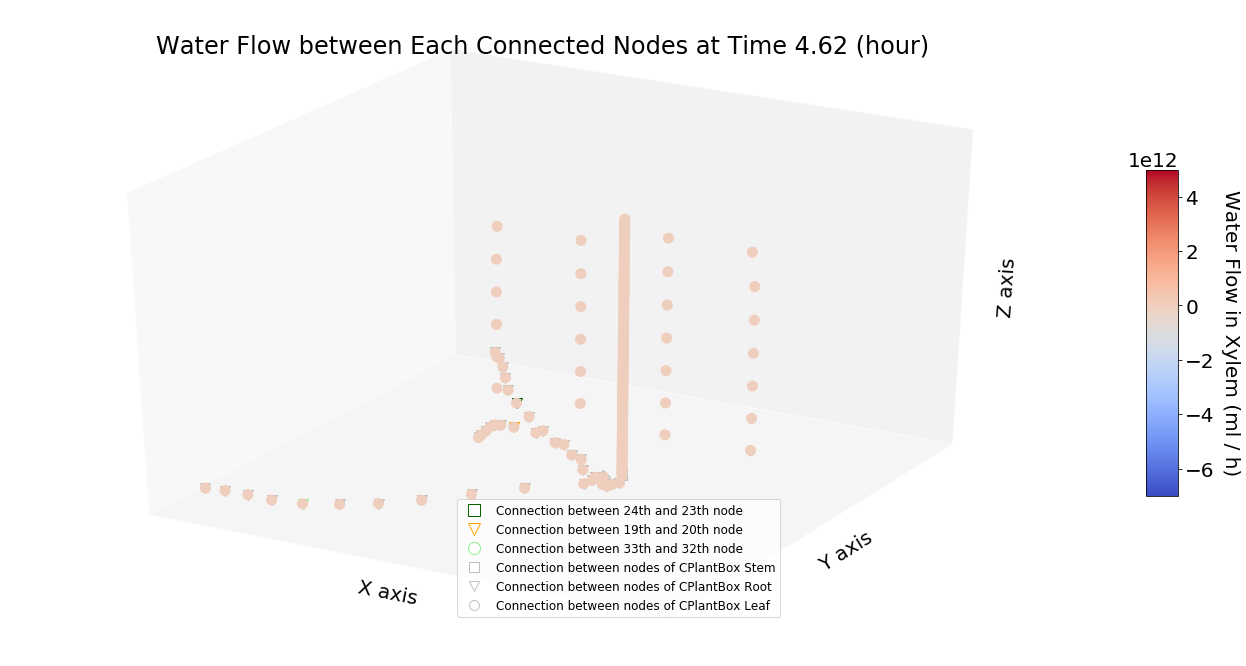

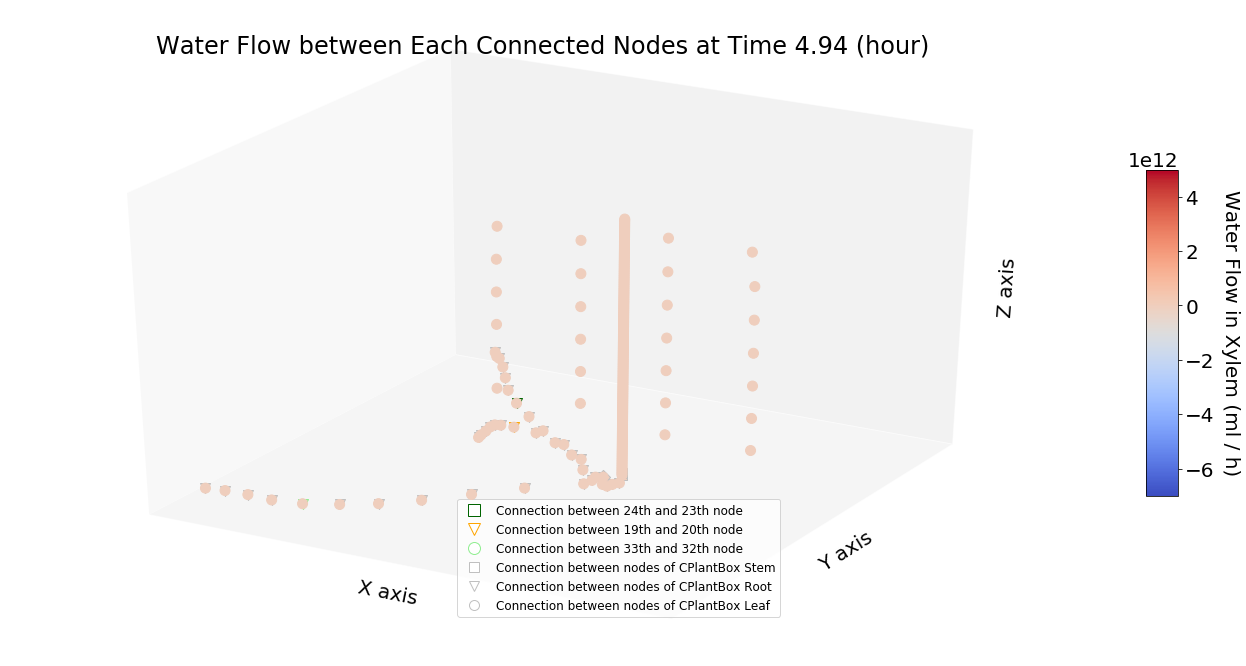

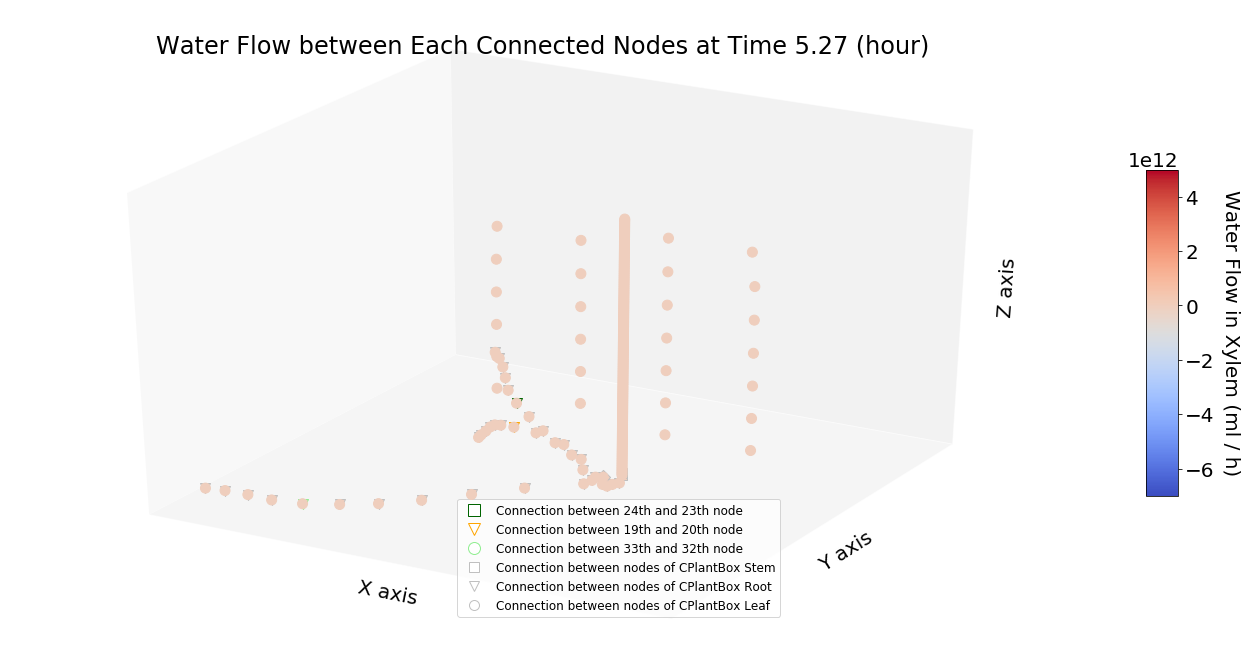

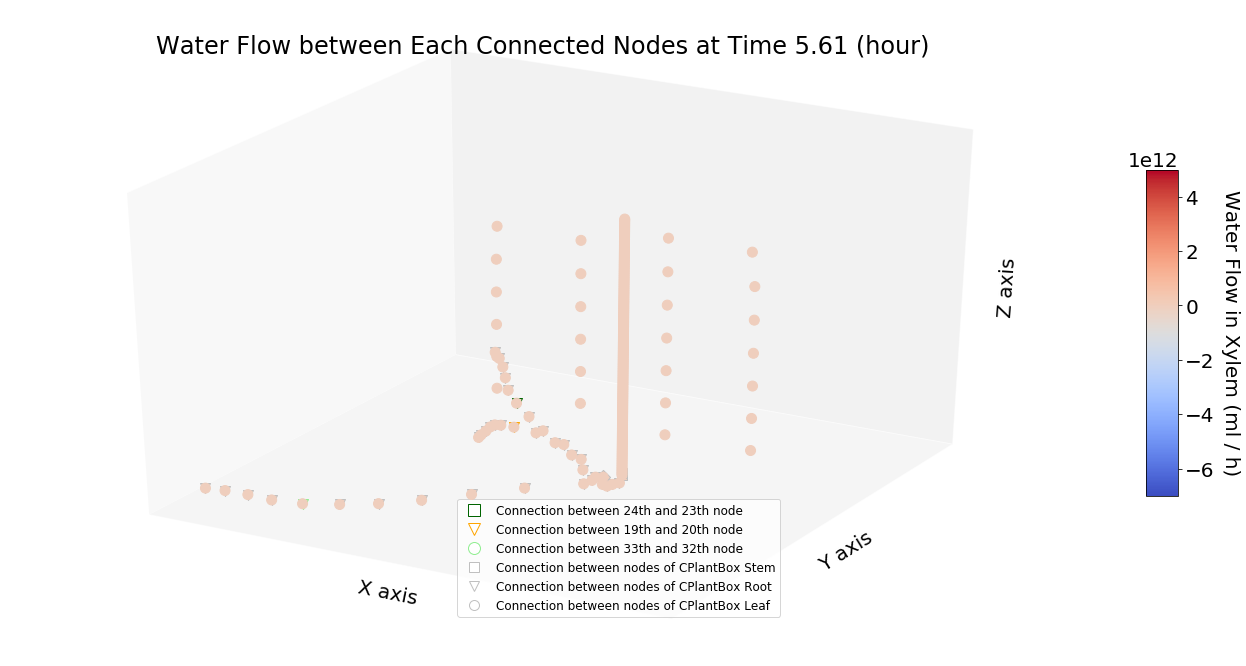

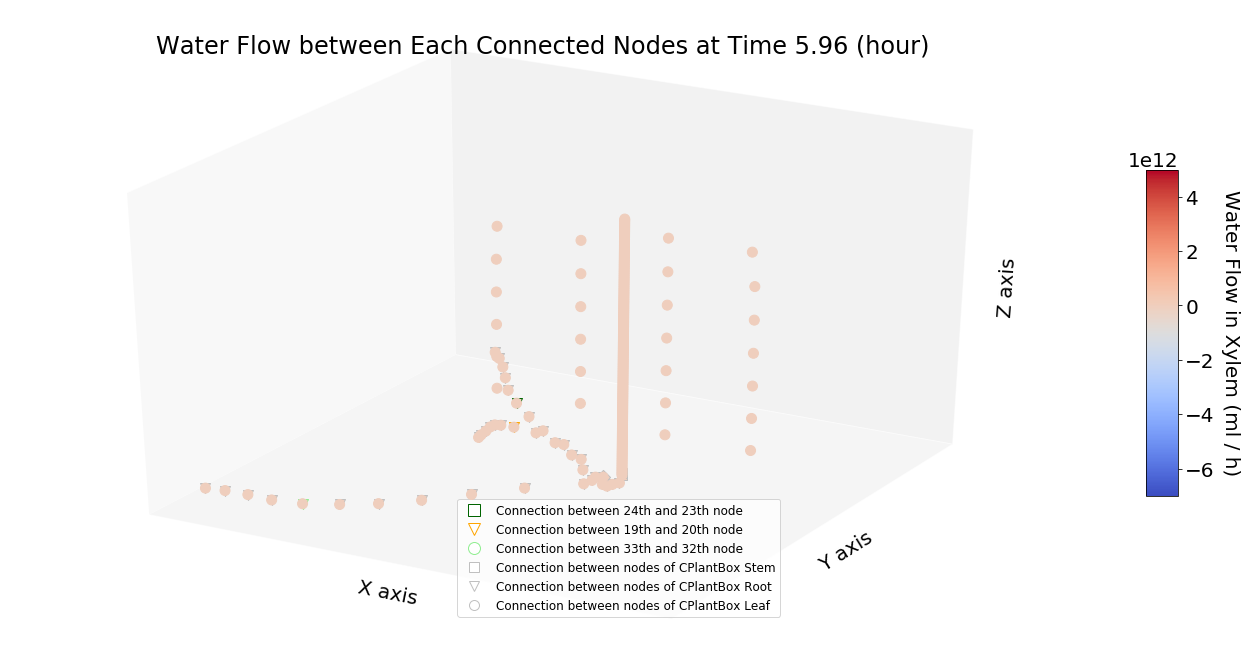

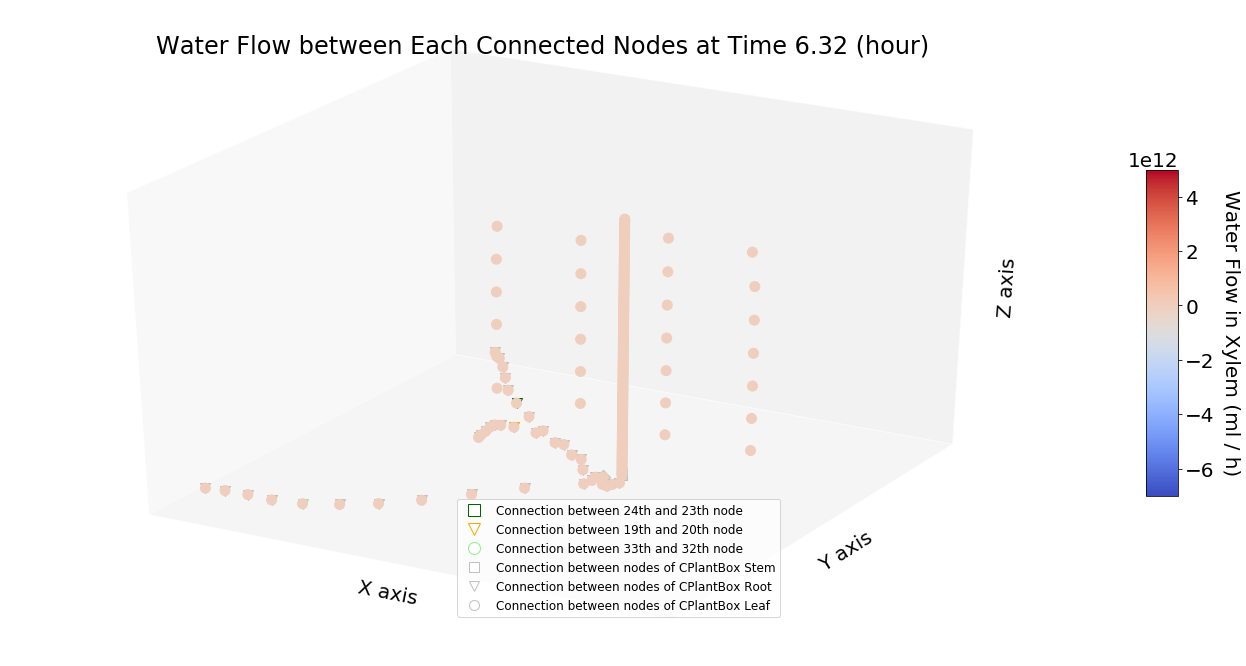

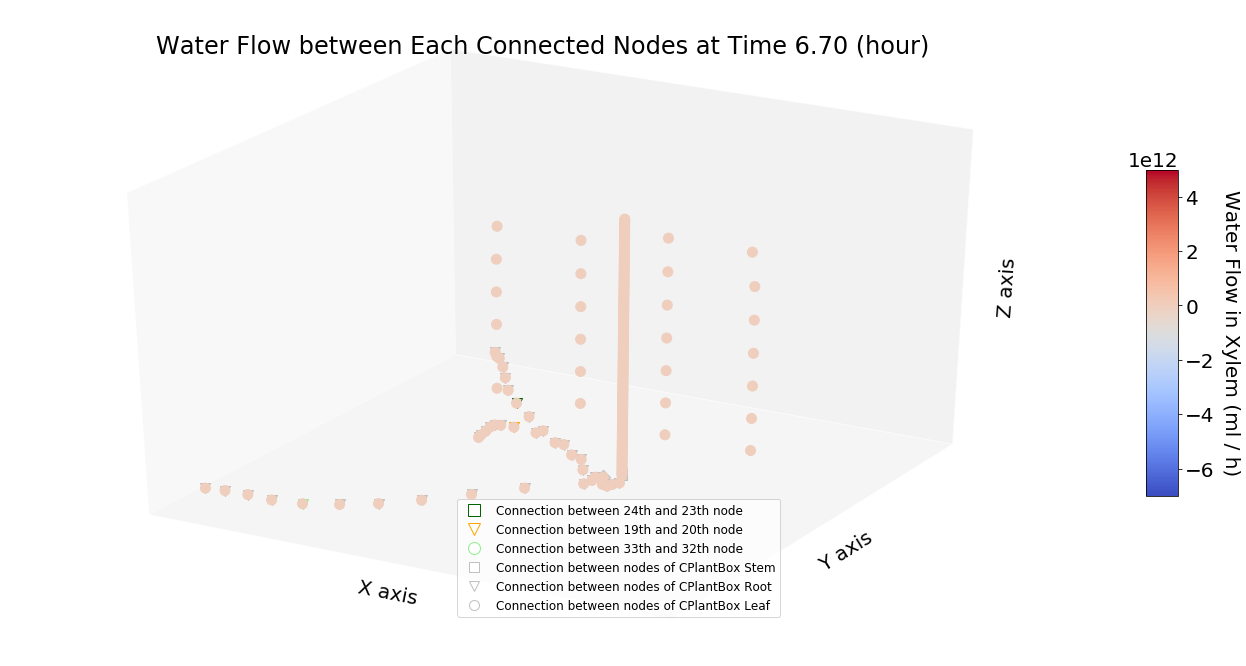

SystemError: <built-in method write of _io.BufferedWriter object at 0x7f7f401bfd58> returned a result with an error set

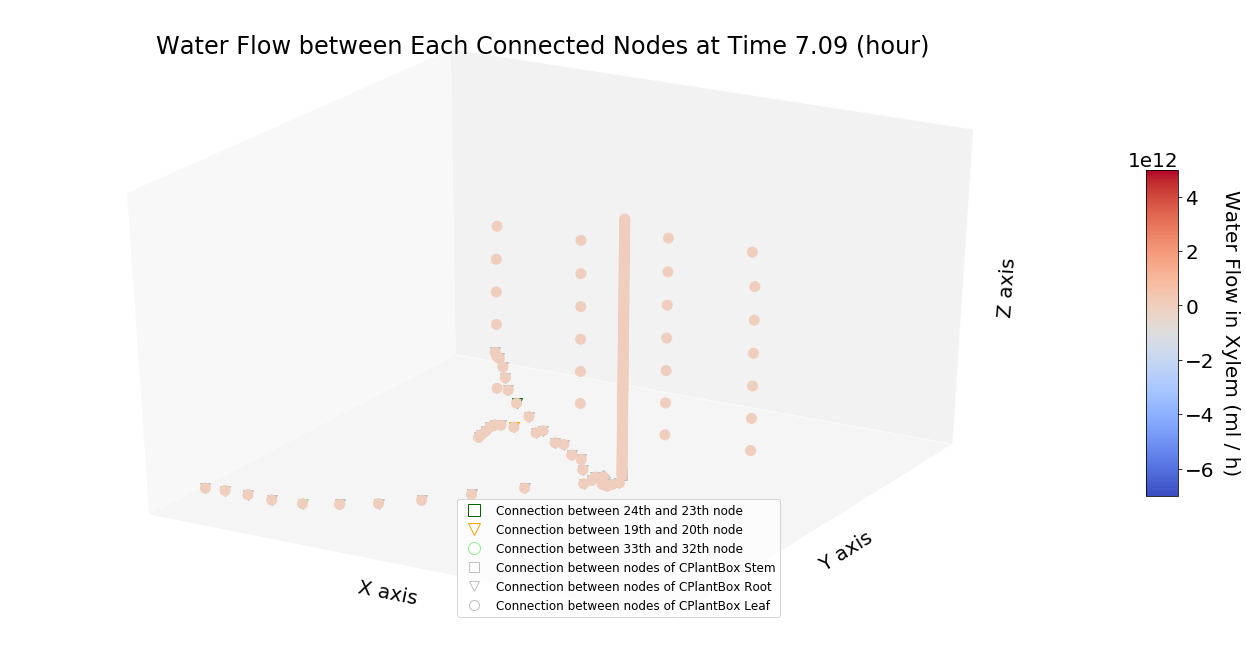

In [139]:
import matplotlib.lines as mlines
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
# nodes_cor = np.column_stack([nodes_organtype, nodes])

plt.rcParams['figure.figsize'] = [24, 12]
# path = 'PiafMunch2_python_test_mg_2018-12-21_10-46-36.673_output.txt'
path = 'morning_glory_7mconnection_220_vml_larger0_output.txt'
#pd.read_table(path,sep='\t')
output = pd.read_table(path,sep='\t',header=1)
JS_ST_begin = (len(node_connection)+1)*31+1
JS_ST_end = JS_ST_begin +(len(node_connection))
output.iloc[100, JS_ST_begin:JS_ST_end]

#JS_ST_1_out=output.iloc[2, JS_ST_begin:JS_ST_end]
#JS_ST_1_out_array = JS_ST_1_out.values
def organ_marker(int):
    if int in leaf_nodes:
    #if int == 21: #int is source 
        return 'o'
    elif int in root_nodes : #int is sink
        return 'v'
    elif int == 1 : #int is sink
        return 'D'
    #elif int == 40 :
    elif int in stem_nodes:
        return 's'
    else:
        return 'None'

cor_x =nodes_c_cor[:,0]
cor_y =nodes_c_cor[:,1]
cor_z =nodes_c_cor[:,2]
cor_m = nodes_c_marker[:,0]
    
def organ_color3(int):
    if int == 34: #int is source 
        return 'lime'
    elif int == 10: #int is source 
        return 'orange'
    elif int == 22:
        return 'darkgreen'
    else:
        return 'silver'

for i in range(0,100):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    # Get rid of colored axes planes
    # First remove fill
    #ax.set_axis_off()
    # Get rid of the panes
    #ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    #ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    #ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # Get rid of the spines
    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')


    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

    # Bonus: To get rid of the grid as well:
    ax.grid(False)
    for j in range(41):
        ax.scatter(cor_x[j], cor_y[j],cor_z[j], s=100, marker = organ_marker(node_connection[j,0]) ,edgecolors= organ_color3(j),
                   c=output.iloc[i, JS_ST_begin+j:JS_ST_begin+j+1] , cmap=cm.coolwarm,  
                   alpha=1, vmin=-7e12, vmax=5e12)
        
    connectionflow = ax.scatter(cor_x, cor_y, cor_z, s=100 , c=output.iloc[i, JS_ST_begin:JS_ST_end] , cmap=cm.coolwarm, alpha=1, vmin=-7e12, vmax=5e12) #vmin = 0, vmax =0.0005

    
    
    plt.rcParams.update({'font.size': 20})

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    #ax.set_xlim3d(0, 0.03)
    #ax.set_ylim3d(0.03 ,0)
    #ax.set_zlim3d(-0.03,0.02)
    #plt.title('Carbon Flow at Time {:.2f} (Hours)'.format(output.iloc[i, 0]))
    plt.title('Water Flow between Each Connected Nodes at Time {:.2f} (hour)'.format(output.iloc[i, 0]))

    #ax.elev = 89.9
    #ax.azim = 270.1
    #ax.dist = 8.0
    #ax.view_init(0, 90)

    cbar = fig.colorbar(connectionflow, shrink=0.5, aspect=10 )
    cbar.ax.get_yaxis().labelpad = 25
    #cbar.ax.set_ylabel('Carbon Flow in Sieve Tube (mmol / h)', rotation=270)
    cbar.ax.set_ylabel('Water Flow in Xylem (ml / h)', rotation=270)
    
    green_star1 = mlines.Line2D([], [],color='darkgreen', markerfacecolor='white', marker='s', linestyle='',
                          markersize=12, label='Connection between 24th and 23th node')
    orange_cross1 = mlines.Line2D([], [],color='orange', markerfacecolor='white', marker='v', linestyle='',
                              markersize=12, label='Connection between 19th and 20th node')
    lgreen_circle1 = mlines.Line2D([], [],color='lightgreen', markerfacecolor='white', marker='o', linestyle='',
                              markersize=12, label='Connection between 33th and 32th node')
    star1 = mlines.Line2D([], [], color='silver', marker='s', linestyle='',
                              markersize=10,markerfacecolor='white', label='Connection between nodes of CPlantBox Stem')
    cross1 = mlines.Line2D([], [], color='silver', marker='v', linestyle='',
                              markersize=10,markerfacecolor='white', label='Connection between nodes of CPlantBox Root')
    circle1 = mlines.Line2D([], [], color='silver', marker='o', linestyle='',
                              markersize=10, markerfacecolor='white',label='Connection between nodes of CPlantBox Leaf')




    plt.legend(handles=[green_star1,orange_cross1, lgreen_circle1, star1, cross1, circle1],
               bbox_to_anchor=(0.42, 0.245), loc=2, borderaxespad=0. , fontsize = 12)

    
    filename='step{:02d}.png'.format(i)
    plt.savefig(filename, dpi=96)
    plt.show()

# Then use image magick (this is bash, not python)
#convert -delay 80 *.png animated_chart.gif



#fig.savefig("{}.pdf".format('JW_ST'), bbox_inches='tight')


#def animate(i):
#    connectionflow.set_c(output.iloc[i, JS_ST_begin:JS_ST_end])  # update the data
#    return connectionflow


# Init only required for blitting to give a clean slate.
#def init():
#    connectionflow.set_c(output.iloc[1, JS_ST_begin:JS_ST_end])
#    return connectionflow

#ani = animation.FuncAnimation(fig, animate, np.arange(1, 100), init_func=init,
#                              interval=25, blit=True)
#plt.show()

/home/xr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.


IndexError: index 53 is out of bounds for axis 0 with size 53

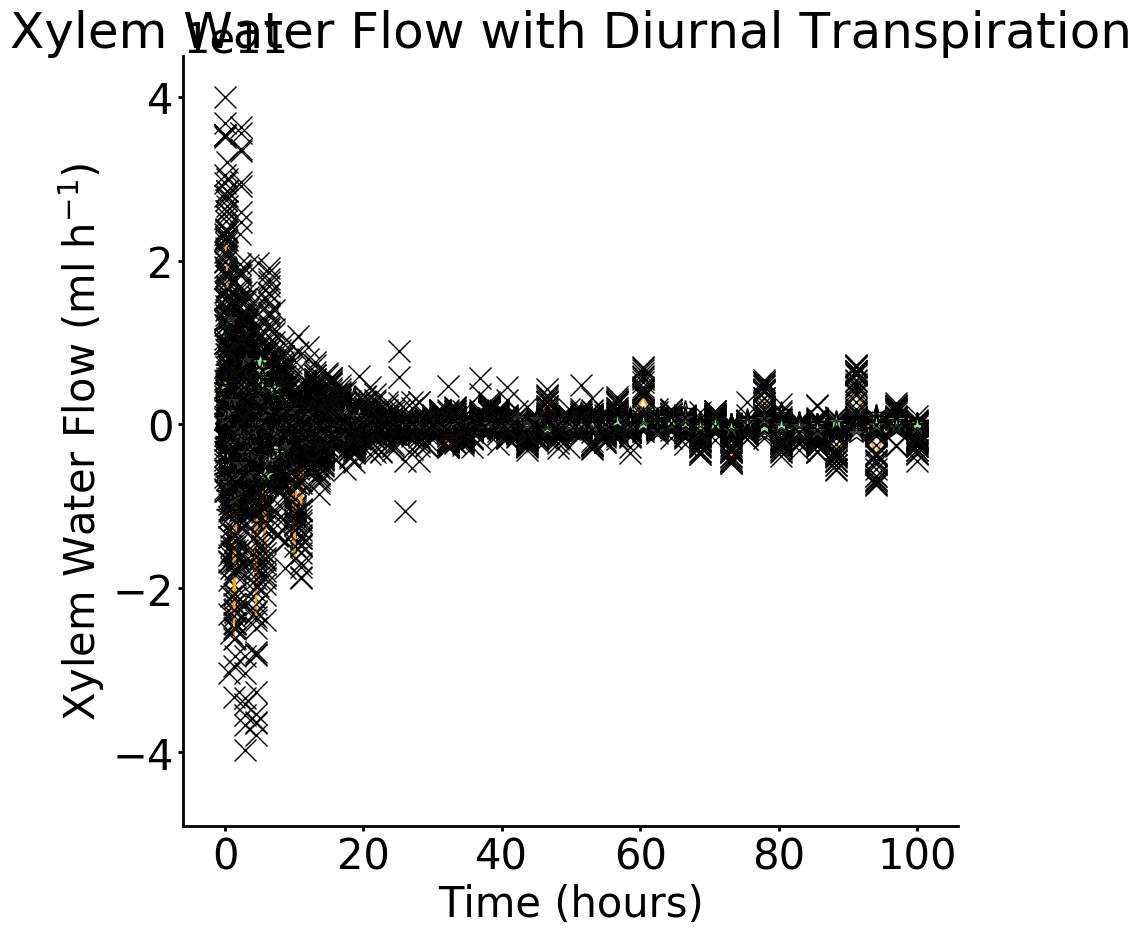

In [19]:
plt.style.use('default')
path = 'testmorning_glory_7mconnection_2110_output.txt'
#pd.read_table(path,sep='\t')
output = pd.read_table(path,sep='\t',header=1)

def organ_color(int):
    if int == 49: #int is source 
        return 'lightgreen'
    elif int == 10: #int is source 
        return 'orange'
    elif int == 22:
        return 'darkgreen'
    else:
        return 'silver'
def organ_color1(int):
    if int == 49: #int is source 
        return 'lightgreen'
    elif int == 10: #int is source 
        return 'orange'
    elif int == 22:
        return 'darkgreen'
    else:
        return 'None'
def zorder(int):    
    if int == 49: #int is source 
        return 11.
    elif int == 10: #int is source 
        return 11.
    elif int == 22:
        return 11.
    else:
        return 0.
stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 4)][:,0] 
root_nodes = nodes_organtype[(nodes_organtype[:,1]== 2)][:,0] 
leaf_nodes = nodes_organtype[(nodes_organtype[:,1]== 8)][:,0] 
time = np.array(output.iloc[:, 0])

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 30})
i=37
f = plt.figure()
ax = plt.subplot(111)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
#ax = f.gca(projection='3d')
n_begin = (len(node_connection))*34-22
n_end = n_begin +(len(node_connection))
var_all = np.array(output.iloc[:,n_begin:n_end])
x = np.array(time)
y = np.array(var_all)
plt.xlabel("Time (hours)")
plt.ylabel("Xylem Water Flow (ml h$^{-1}$)")
#plt.ylabel("Xylem water flow (ml h$^{-1}$)".format(output.columns[n_begin]))
#plt.title("{}th figure {} ".format(i ,output.columns[n_begin]))
plt.title("Xylem Water Flow with Diurnal Transpiration".format(i ,output.columns[n_begin]))
    
for i in range(len(node_connection)):
    ax.plot(x,[pt[i] for pt in y], marker = organ_marker(node_connection[i,0]),markersize=16, markeredgewidth = 1, markeredgecolor = 'black',  label = '{0}'.format(node_connection[i,0])
                ,c=organ_color1(node_connection[i,0]),alpha=1,zorder=zorder(i))
    ax.scatter(x,[pt[i] for pt in y], marker = organ_marker(node_connection[i,0]),s=160,  label = '{0}'.format(node_connection[i,0])
                ,c=organ_color(node_connection[i,0]),alpha=0.2,zorder=zorder(i))
#plt.legend()
#labelLines(plt.gca().get_lines(), xvals=(0, 100), zorder=0)
plt.rcParams.update({'font.size': 18})

green_star = mlines.Line2D([], [], color='darkgreen', marker='s', markeredgewidth = 1, markeredgecolor = 'black', linestyle='-',
                          markersize=16, label='22nd node')
orange_cross = mlines.Line2D([], [], color='orange', marker='v', markeredgewidth = 1, markeredgecolor = 'black', linestyle='-',
                          markersize=16, label='10th node')
lgreen_circle = mlines.Line2D([], [], color='lightgreen', marker='o', markeredgewidth = 1, markeredgecolor = 'black', linestyle='-',
                          markersize=16, label='49th node')
star = mlines.Line2D([], [], color='grey', marker='s', linestyle='',
                          markersize=16, label='Stem')
cross = mlines.Line2D([], [], color='grey', marker='v', linestyle='',
                          markersize=16, label='Root')
circle = mlines.Line2D([], [], color='grey', marker='o', linestyle='',
                          markersize=16, label='Leaf')




plt.legend(handles=[green_star,orange_cross, lgreen_circle, star, cross, circle],bbox_to_anchor=(0.6, 0.4), loc=2, borderaxespad=0., prop={'size': 22})

plt.show()
s =output.columns[n_begin]
s = s.replace('/', '')
f.savefig("diural{}.pdf".format(s), bbox_inches='tight')